# What makes a good book?

![books](books_pattern.jpg)


# Table of Contents


**Title** - description
1) **Problem Statement & Outcome** - identify the project goal and tools
2) **Preliminary Data Cleaning** - perform minimal data cleaning to prepare for model building
3) **Baseline Model Building** - using the dataset prepared in the previous step, we build a quick ML model, seeking to achieve our goal
4) **Comprehensive Preprocessing & EDA** - thorough cleaning of each column in the dataset, we add new features, identify feature patterns, and understandour data more deeply
5) **Finalize Dataset for Model Building** - merge all dataframes into one large dataframe that will be used to train our final model; two dataframes will be created: one comprising unique book values and another whose granularity is book reviews
6) **Model Training & Evaluation** - using our cleaned and revised dataset, we evaluate model performance across different feature sets to find the best one that achieves our goal
7) **Model Deployment** - Testing the model with a test set sample
8) **Which Features Make a Book Popular?** - answering the fundamental question of this project with machine learning

# Problem Statement & Outcome

## Goal
We work for an online bookstore as a data scientist. Our company would like to predict whether a book in its inventory will be popular or unpopular. Our model needs to achieve at least 70% prediction accuracy on a cross-validated test set. We define accuracy as the following:

$$\text{Accuracy} = \frac{TP + TN}{TP + FP + TN + FN}$$
$$ \text{where } \text{TP} = True Positives, \text{TN} = True Negatives, \text{FP} = False Positives, \text{FN} = False Negatives$$


## Tools
We have been provided a single dataset comprising nine columns, including the target feature ("popularity").

| Column     | Description              |
|------------|--------------------------|
| `'title'` | Book title |
| `'price'` | Book price |
| `'review/helpfulness'` | The number of helpful reviews over the total number of reviews | 
| `'review/summary'` | The summary of the review |
| `'review/text'`| The review's full text |
| `'description'` | The book's description |
| `'authors'` | Author | 
| `'categories'` | Book categories |
| `'popularity'` | Whether the book was popular or unpopular | 

## Outcome
A good prediction model will help the online bookstore better manage its inventory and tailor its marketing strategies to satisfy its clients' interest. As a data scientist in the firm, delivering a quality good model is also in our interests, as building such models is presumably part of our job description; delivering a good model may lead to better job security or an internal firm promotion. Regardless, we work at this firm. We signed a contract with this firm to deliver best-in-class machine learning. So let's achieve that at minimum.


## Success Parameters
I define these to be:
1) Deliver a model that achieves greater than 70% accuracy on the test set during model validation. Ideally, this test set accuracy is as high as possible. I will use the XGBoost Classifier as my baseline machine learning algorithm.
2) Answer the question at the heart of the problem: "what makes a good book?" In this case, what makes a book 'popular,' a word I use to be synonymous with good. I would like to know what book's features most account for a book's categorization as 'popular.'

# Library & Data Imports

In [2]:
# Import essential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# nltk and nlp
import string
import re

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, FunctionTransformer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, roc_curve
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

#from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob

# Custom libraries
import maps as m
import textcleaner as tc
import authorcleaner as ac
import helpers as helper

# Custom transformer library
import customtransformers as ct

import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# magic functions
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/repl/nltk_data...
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/repl/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


In [3]:
# Read in the dataset
books_original = pd.read_csv("data/books.csv")
print(f"The original dataset comprises {books_original.shape[0]} rows and {books_original.shape[1]} columns")
books_original.head(3)

The original dataset comprises 15719 rows and 9 columns


,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
0,We Band of Angels: The Untold Story of America...,10.88,2/3,A Great Book about women in WWII,I have alway been a fan of fiction books set i...,"In the fall of 1941, the Philippines was a gar...",'Elizabeth Norman','History',Unpopular
1,Prayer That Brings Revival: Interceding for Go...,9.35,0/0,Very helpful book for church prayer groups and...,Very helpful book to give you a better prayer ...,"In Prayer That Brings Revival, best-selling au...",'Yong-gi Cho','Religion',Unpopular
2,The Mystical Journey from Jesus to Christ,24.95,17/19,Universal Spiritual Awakening Guide With Some ...,The message of this book is to find yourself a...,THE MYSTICAL JOURNEY FROM JESUS TO CHRIST Disc...,'Muata Ashby',"'Body, Mind & Spirit'",Unpopular


In [4]:
# Determine the feature types
books_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15719 entries, 0 to 15718
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               15719 non-null  object 
 1   price               15719 non-null  float64
 2   review/helpfulness  15719 non-null  object 
 3   review/summary      15718 non-null  object 
 4   review/text         15719 non-null  object 
 5   description         15719 non-null  object 
 6   authors             15719 non-null  object 
 7   categories          15719 non-null  object 
 8   popularity          15719 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


# Preliminary Data Cleaning

## Drop Duplicates

Of the **15,719** rows in the original dataframe, there are **3,294** duplicate rows. This is a problem, as duplicate rows can lead to overfitting, where the model learns the specifics of the duplicate examples too well and performs poorly on new, unseen data. The concern is that the model might give undue importance to these duplicates, especially if they are significant in quantity compared to unique examples. Moreover, duplicates skew the distribution of classes or values, particularly if they are not evenly distributed. For classification problems, this could result in biased predictions, especially if certain classes are overrepresented due to duplicates.

After dropping the duplicate entries, the total dataset observation count is **12,425** rows.

In [5]:
# Check for duplicates
row_count = books_original.shape[0]
duplicate_count = row_count - books_original.drop_duplicates().shape[0]
print(f"There are {row_count} rows in the dataset, of which {duplicate_count} are duplicate rows")

books_original.sort_values(by = 'title').head(3)

There are 15719 rows in the dataset, of which 3294 are duplicate rows


,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
11136,"""Cool Stuff"" They Should Teach in School: Crui...",11.21,1/1,More style than substance,I bought this on the basis of the reviews. I t...,Offers advices to young people on such topics ...,"'Kent Healy', 'Kyle Healy'",'Education',Unpopular
449,"""Cool Stuff"" They Should Teach in School: Crui...",11.21,1/1,More style than substance,I bought this on the basis of the reviews. I t...,Offers advices to young people on such topics ...,"'Kent Healy', 'Kyle Healy'",'Education',Unpopular
14016,"""Happiness Is Not My Companion"": The Life of G...",24.95,2/2,Solid Bio on Warren and the Controversy of Fiv...,"Solid bio on General Warren, like George Picke...",The valorous but troubled career of the Civil ...,'David M. Jordan','History',Popular


In [6]:
# Drop duplicates
books = books_original.drop_duplicates()
books = books.sort_values(by = 'title')
new_row_count = books.shape[0]
print(f"After dropping {duplicate_count} duplicates, there are now {new_row_count} rows in the dataframe")
books.head(3)

After dropping 3294 duplicates, there are now 12425 rows in the dataframe


,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
449,"""Cool Stuff"" They Should Teach in School: Crui...",11.21,1/1,More style than substance,I bought this on the basis of the reviews. I t...,Offers advices to young people on such topics ...,"'Kent Healy', 'Kyle Healy'",'Education',Unpopular
14016,"""Happiness Is Not My Companion"": The Life of G...",24.95,2/2,Solid Bio on Warren and the Controversy of Fiv...,"Solid bio on General Warren, like George Picke...",The valorous but troubled career of the Civil ...,'David M. Jordan','History',Popular
12727,"""Then Junior Said to Jeff. . ."": The Best NASC...",18.36,0/0,Great Stories!,"If you like NASCAR stories, facts, trivia, sta...",This collection of behind-the-scenes happening...,"'Jim McLaurin', 'David Poole', 'Tom Gillispie'",'Sports & Recreation',Popular


## Drop Null Values

Null values must be addressed before building a machine learning model. Only one item in 'review/summary' column has a null entry. Dropping this one row will have a minimal impact on the machine learning model output and therefore will be the strategy.

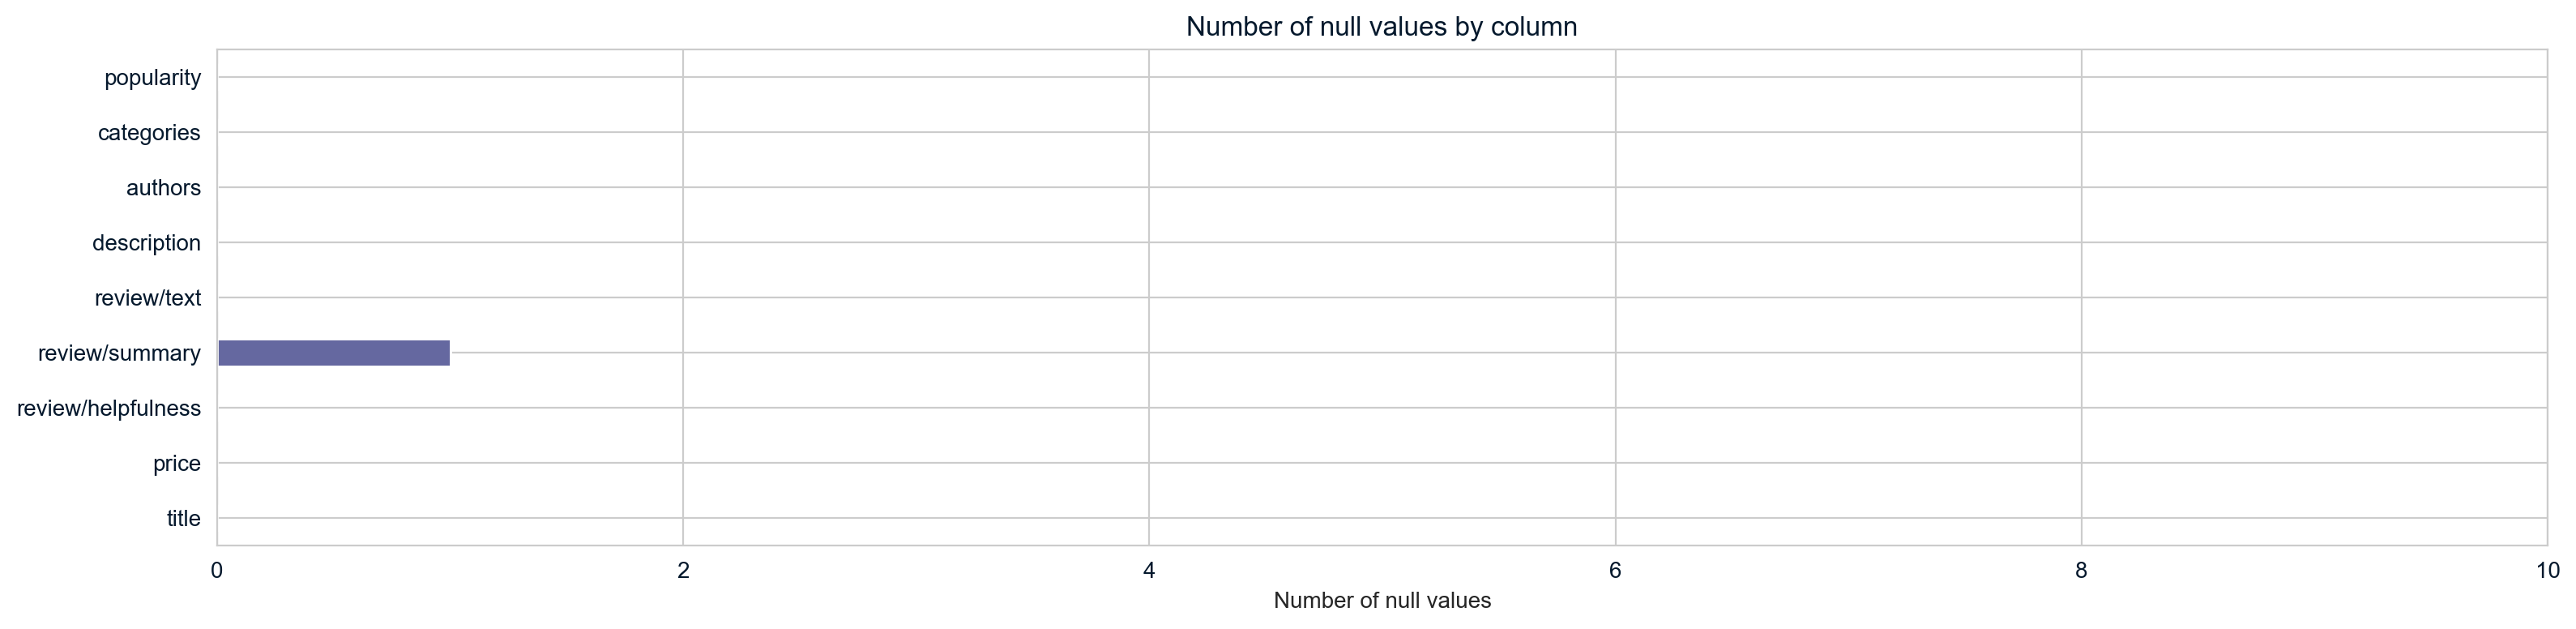

In [7]:
plt.figure(figsize = (16, 4))
books.isnull().sum().plot(kind = 'barh')
plt.xlim([0, 10])
plt.xlabel("Number of null values")
plt.title("Number of null values by column")
plt.tight_layout()

In [8]:
original_count = books.shape[0]
books = books[~books['review/summary'].isnull()].reset_index(drop = True)
print(f"After dropping {original_count - books.shape[0]} null instances, there are now {books.shape[0]} rows in the dataframe")
books.head(3)

After dropping 1 null instances, there are now 12424 rows in the dataframe


,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
0,"""Cool Stuff"" They Should Teach in School: Crui...",11.21,1/1,More style than substance,I bought this on the basis of the reviews. I t...,Offers advices to young people on such topics ...,"'Kent Healy', 'Kyle Healy'",'Education',Unpopular
1,"""Happiness Is Not My Companion"": The Life of G...",24.95,2/2,Solid Bio on Warren and the Controversy of Fiv...,"Solid bio on General Warren, like George Picke...",The valorous but troubled career of the Civil ...,'David M. Jordan','History',Popular
2,"""Then Junior Said to Jeff. . ."": The Best NASC...",18.36,0/0,Great Stories!,"If you like NASCAR stories, facts, trivia, sta...",This collection of behind-the-scenes happening...,"'Jim McLaurin', 'David Poole', 'Tom Gillispie'",'Sports & Recreation',Popular


## Assess Target Variable Distribution

Approximately **42.1%** of the observations are categorized as popular, with the remainder categorized as unpopular. When splitting the data into training and test sets, I will seek to preserve class proportions to ensure that both training and test sets have similar class distributions. This will improve model reliability and generalize better to the data.

Otherwise, given the imbalanced state of the dataset, I could build a baseline machine learning model that is expected to be 57.9% accurate (i.e. 100% - 42.1%) simply by predicting 'Unpopular' for every observation fed into the model.

57.9% of rows are categorized as Unpopular
42.1% of rows are categorized as Popular


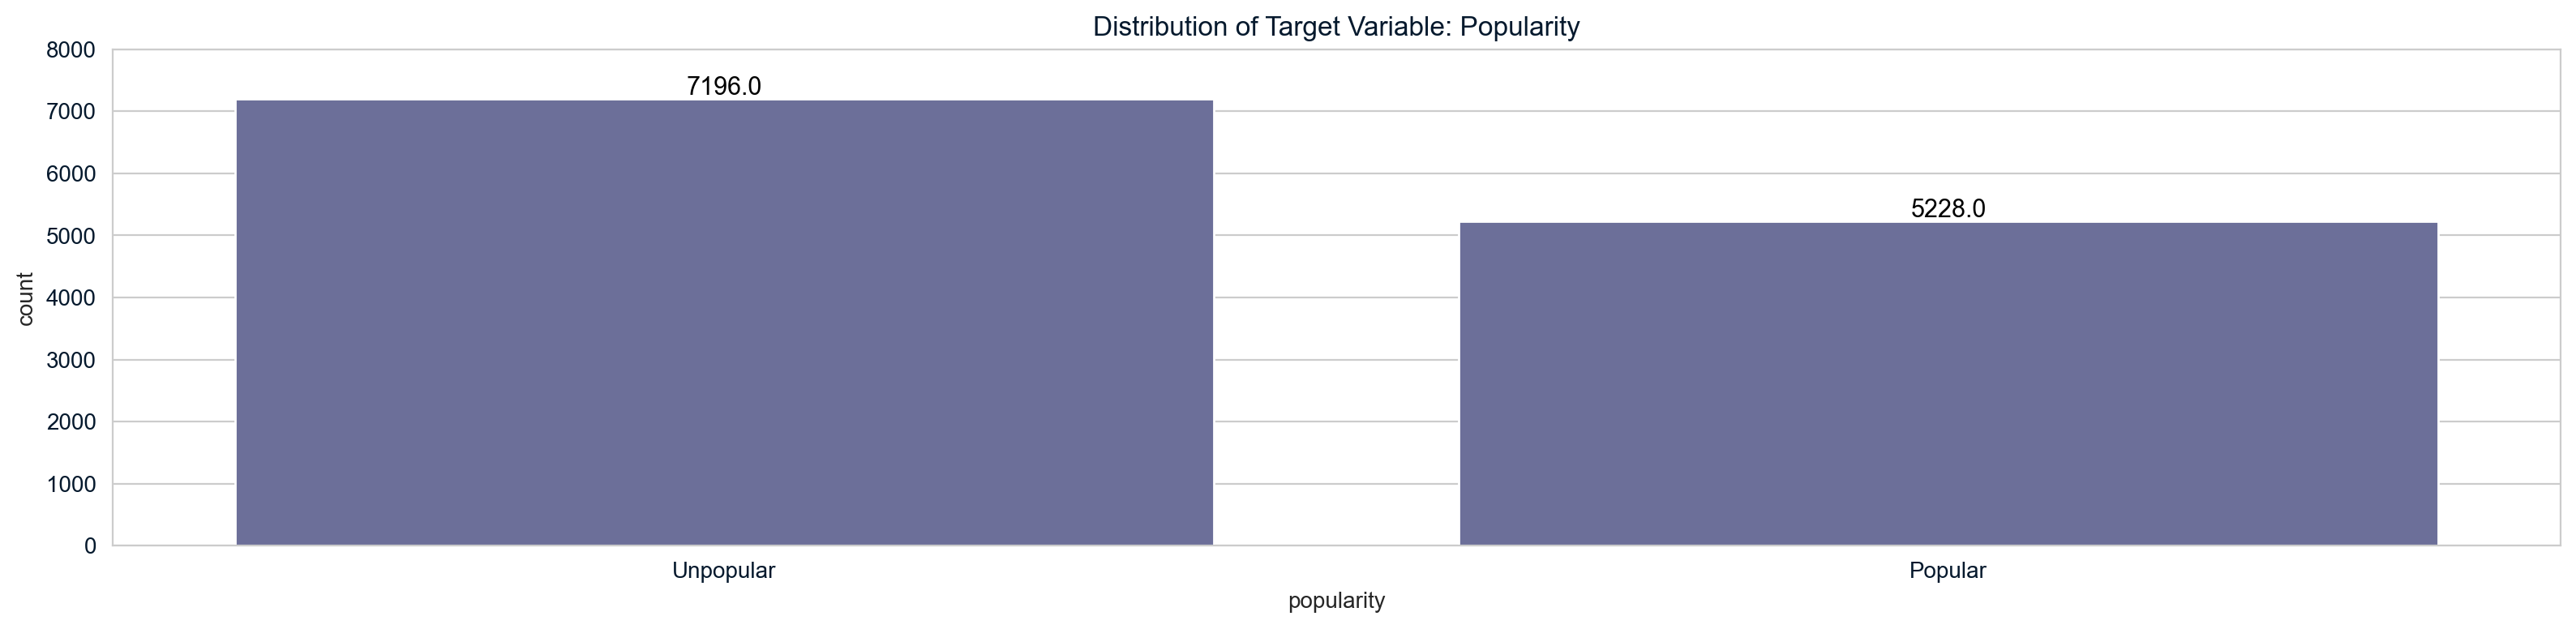

In [9]:
df = books.copy()
target = 'popularity'
tmp = df[target].value_counts(normalize = True).reset_index()

for i, row in tmp.iterrows():
    print(f"{round(row['proportion'], 3) * 100}% of rows are categorized as {row['popularity']}")

plt.figure(figsize = (16, 4))
sns.countplot(data = df, x = target)

plt.ylim([0, 8000])

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title("Distribution of Target Variable: Popularity")

plt.tight_layout()

# Baseline Model Building

In [10]:
# this is our default classifier for the entire project
project_classifier = XGBClassifier(random_state = 42)

## Pipeline Model 1: Sentiment CountVectorizer

The first model will absorb all the dataset features. The price category will be standardized. The categories category will be simplified such that infrequent features are recategorized as 'other' and then one-hot encoded into numeric values. The review/helpfulness column is parsed from a text column into numeric column and standardized. The three text columns - review text, summary, and description - are all cleaned and vectorized using the CountVectorizer. Each column is evaluated based on the count of 'positive' or 'negative' sentiment words (sourced for nltk.opinion_lexicon). The word count for the respective text column is then standardized.

All of the preprocessed data is fed to a classification estimator (decision tree).

In [11]:
# list object to save model results
results = []
good_models = []

price_transformer = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('recode', ct.RecodeCategory()),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))    
])

review_transformer = Pipeline([
    ('split_reviews', ct.SplitReviewCount()),
    ('scaler', StandardScaler())
])

text_transformer = Pipeline([
    ('cleaner', ct.CleanText()),
    ('vectorize', FeatureUnion([
        ('positive', ct.VectorizeCount(sentiment = 'positive')),
        ('negative', ct.VectorizeCount(sentiment = 'negative'))
    ])),
    ('scaler', StandardScaler())
])

preproc = ColumnTransformer([
    ('price_transformer', price_transformer, ['price']),
    ('review_helpfulness_transformer', review_transformer, ['review/helpfulness']),
    ('categories_transformer', cat_transformer, ['categories']),
    ('text_transformer', text_transformer, ['review/text', 'review/summary', 'description']),    
], remainder='drop')

pipeline = Pipeline([
    ('preprocessing', preproc),
    ('classifier', project_classifier)
])

pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('price_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['price']),
                                                 ('review_helpfulness_transformer',
                                                  Pipeline(steps=[('split_reviews',
                                                                   SplitReviewCount()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['review/helpfulness']),
                                                 ('categories_transformer',
                                                  Pipeline(steps=[('recode',
                                                                   RecodeCategory...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [12]:
model_name = 'pipeline_model_1'
model_description = 'a baseline model receiving minimal data cleaning, assesses text features based on the total count of positive or negative words in each text column.'

X = books.drop('popularity', axis = 1)
y = books['popularity'].map({'Popular': 1, 'Unpopular': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)

print("Processing and fitting model")
pipeline.fit(X_train, y_train)

print("Running cross validation")
result = cross_validate(pipeline, X_test, y_test, cv = 5, n_jobs = -1, scoring = 'accuracy')

accuracy = round(result['test_score'].mean(), 3)
print(f"Cross-validated accuracy score is {accuracy}")

print(f"Achieved goal of 70% accuracy? {accuracy > 0.70}")

result_details = {
    'model_name': model_name,
    'model_desc': model_description,
    'training_observations': X_train.shape[0],
    'accuracy_score': accuracy,
    'dataset_cleaning': 'preliminary'
}

results.append(result_details)

if accuracy > 0.70:
    result_details['model'] = pipeline
    good_models.append(result_details)

Processing and fitting model
Running cross validation


[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/repl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/repl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/repl/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/repl/nltk_data...
[nltk_data]   Package opinion_lexicon

Cross-validated accuracy score is 0.631
Achieved goal of 70% accuracy? False


## Pipeline Model 2: Applying the TFIDF Vectorizer

The second model also absorbs all the dataset features. The price category will be standardized. The categories category will be simplified such that infrequent features are recategorized as 'other' and then one-hot encoded into numeric values. The review/helpfulness column is parsed from a text column into numeric column and standardized. 

Unlike the first model, the three text columns - review text, summary, and description - are all cleaned and vectorized using the TfIDF Vectorizer. A cap of 1,000 features is enforced on the number of features created by each vectorizer in order to prevent overfitting and the curse of dimensionality problem. I cleaned the text columns outside of the pipeline.

In [13]:
token_pattern = r'(?u)\b[A-Za-z]{2,}\b'

price_transformer = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('recode', ct.RecodeCategory()),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))    
])

review_transformer = Pipeline([
    ('split_reviews', ct.SplitReviewCount()),
    ('scaler', StandardScaler())
])

tfidf_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(token_pattern=token_pattern, max_features=1000))
])

preproc = ColumnTransformer([
    ('price', price_transformer, ['price']),
    ('review_helpfulness_transformer', review_transformer, ['review/helpfulness']),
    ('categories_transformer', cat_transformer, ['categories']),
    ('summary_text', tfidf_transformer,'review/summary'),
    ('review_text', tfidf_transformer,'review/text'),
    ('description', tfidf_transformer,'description')
], remainder = 'drop')


pipeline = Pipeline([
    ('preprocessing', preproc),
    ('classifier', project_classifier)
])

pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('price',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['price']),
                                                 ('review_helpfulness_transformer',
                                                  Pipeline(steps=[('split_reviews',
                                                                   SplitReviewCount()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['review/helpfulness']),
                                                 ('categories_transformer',
                                                  Pipeline(steps=[('recode',
                                                                   RecodeCategory()),
                                                                  ('ohe',
                                                                   O...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [14]:
model_name = 'pipeline_model_2'
model_description = 'a baseline model receiving minimal data cleaning, assesses text features using Tfidf Vectorizer for each text column.'

print("Duplicating dataframe")
df = books.copy()

print("Cleaning text independently")
df['review/text'] = df['review/text'].apply(tc.clean_text)
df['review/summary'] = df['review/summary'].apply(tc.clean_text)
df['description'] = df['description'].apply(tc.clean_text)

X = df.drop('popularity', axis = 1)
y = df['popularity'].map({'Popular': 1, 'Unpopular': 0})

print("Splitting into training and test set")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)

print("Processing and fitting model")
pipeline.fit(X_train, y_train)

print("Running cross validation")
result = cross_validate(pipeline, X_test, y_test, cv = 5, n_jobs = -1, scoring = 'accuracy')

accuracy = round(result['test_score'].mean(), 3)
print(f"Cross-validated accuracy score is {accuracy}")
print(f"Achieved goal of 70% accuracy? {accuracy > 0.70}")

result_details = {
    'model_name': model_name,
    'model_desc': model_description,
    'training_observations': X_train.shape[0],
    'accuracy_score': accuracy,
    'dataset_cleaning': 'preliminary'
}

results.append(result_details)

if accuracy > 0.70:
    result_details['model'] = pipeline
    good_models.append(result_details)

Duplicating dataframe
Cleaning text independently
Splitting into training and test set
Processing and fitting model
Running cross validation
Cross-validated accuracy score is 0.684
Achieved goal of 70% accuracy? False


## Result Assessments

So far, with minimal data preprocessing, we have nearly achieved our machine learning target objective of building a book prediction model that achieves 70% accuracy on a cross-validated test set. This is quite remarkable considering the contents of the training and testing data still haven't been thoroughly parsed and cleaned (as we will see subsequently).

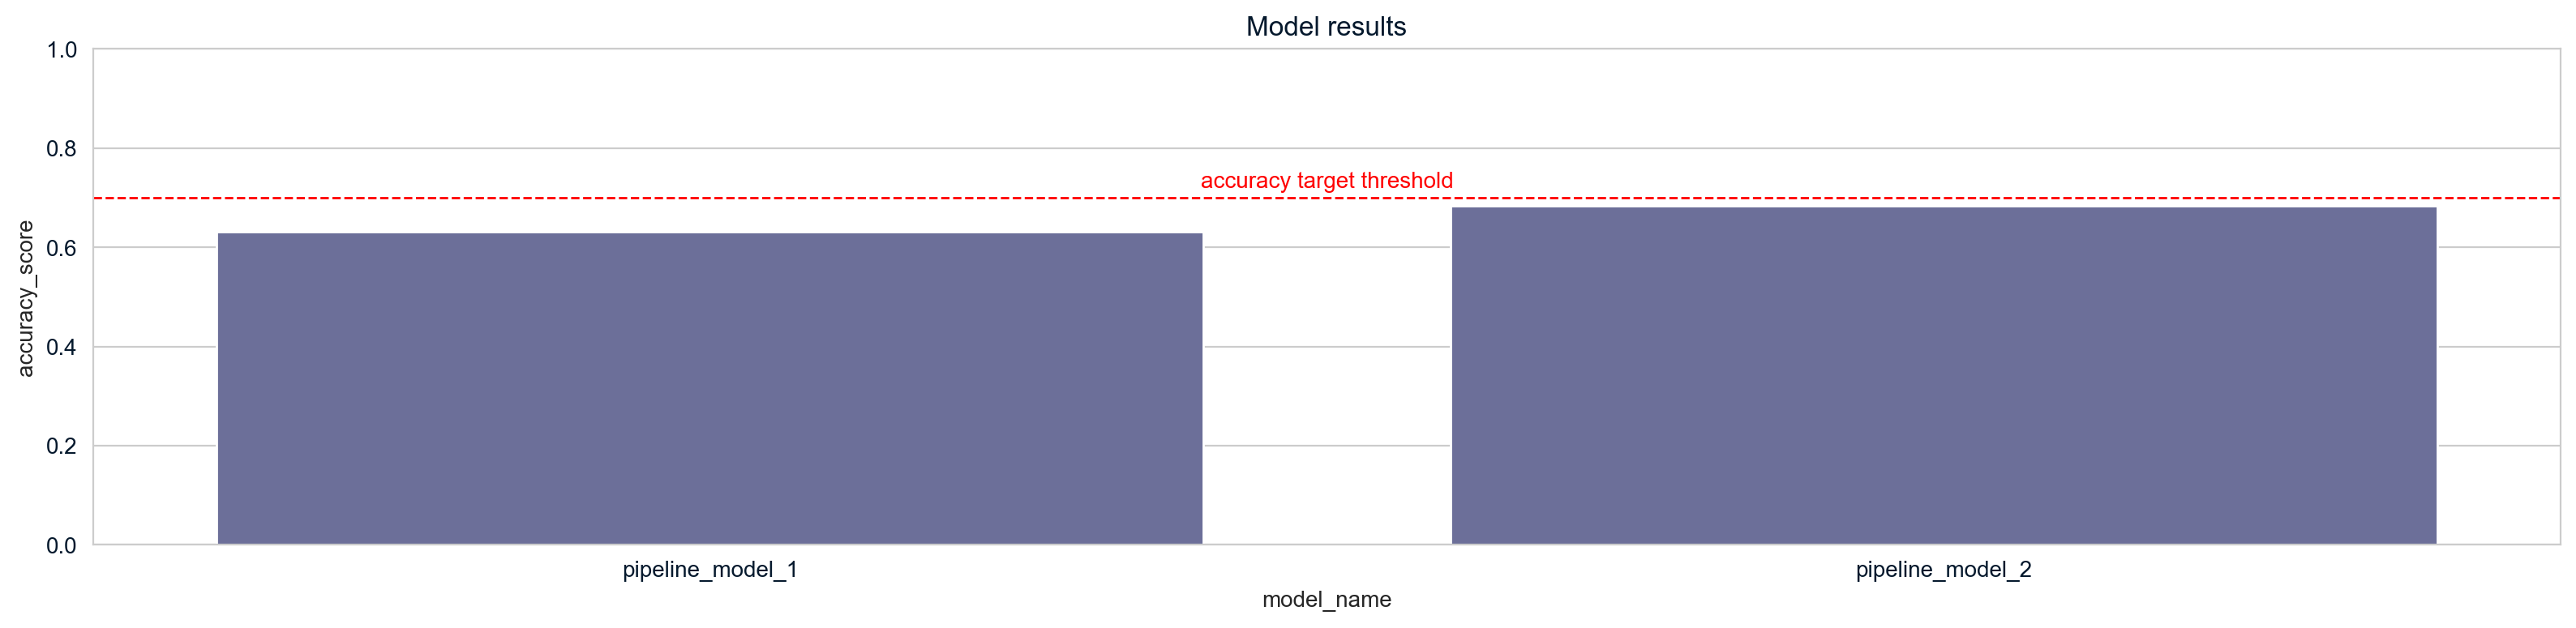

In [15]:
plt.figure(figsize = (16, 4))

tmp = pd.DataFrame(results)
ax = sns.barplot(data = tmp, x = 'model_name', y = 'accuracy_score')
ax.axhline(0.70, color = 'red', linestyle='--', linewidth = 1)
annotation = "accuracy target threshold"
ax.text(x = 0.5, y = 0.72, s = annotation, color = 'red', ha = 'center')

plt.title("Model results")
plt.ylim([0, 1])
plt.tight_layout()

## Pipeline Model 3: Combining CountVectorizer and TFIDF Vectorizer

The third model also absorbs all the dataset features. The price category will be standardized. The categories category will be simplified such that infrequent features are recategorized as 'other' and then one-hot encoded into numeric values. The review/helpfulness column is parsed from a text column into numeric column and standardized. 

In this model, the three text columns - review text, summary, and description - are all cleaned and vectorized using the CountVectorizer for sentiment terms and using the TfIDF Vectorizer. A cap of 1000 columns is enforced on the number of features created by the latter. Unlike the previous models, I cleaned the text columns outside of the pipeline.

In [16]:
token_pattern = r'(?u)\b[A-Za-z]{2,}\b'

price_transformer = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('recode', ct.RecodeCategory()),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))    
])

review_transformer = Pipeline([
    ('split_reviews', ct.SplitReviewCount()),
    ('scaler', StandardScaler())
])

text_transformer = Pipeline([
    ('vectorize', FeatureUnion([
        ('positive', ct.VectorizeCount(sentiment = 'positive')),
        ('negative', ct.VectorizeCount(sentiment = 'negative'))
    ])),
    ('scaler', StandardScaler())
])

tfidf_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(token_pattern=token_pattern, max_features=1000))
])

preproc = ColumnTransformer([
    ('price', price_transformer, ['price']),
    ('review_helpfulness_transformer', review_transformer, ['review/helpfulness']),
    ('categories_transformer', cat_transformer, ['categories']),
    ('text_transformer', text_transformer, ['review/text', 'review/summary', 'description']),    
    ('summary_text', tfidf_transformer,'review/summary'),
    ('review_text', tfidf_transformer,'review/text'),
    ('description', tfidf_transformer,'description')
], remainder = 'drop')


pipeline = Pipeline([
    ('preprocessing', preproc),
    ('classifier', project_classifier)
])

pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('price',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['price']),
                                                 ('review_helpfulness_transformer',
                                                  Pipeline(steps=[('split_reviews',
                                                                   SplitReviewCount()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['review/helpfulness']),
                                                 ('categories_transformer',
                                                  Pipeline(steps=[('recode',
                                                                   RecodeCategory()),
                                                                  ('ohe',
                                                                   O...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [17]:
model_name = 'pipeline_model_3'
model_description = 'a baseline model receiving minimal data cleaning, assesses text features using Tfidf Vectorizer for each text column; Count Vectorizer for positive/negative words.'

print("Duplicating dataframe")
df = books.copy()

print("Cleaning text independently")
df['review/text'] = df['review/text'].apply(tc.clean_text)
df['review/summary'] = df['review/summary'].apply(tc.clean_text)
df['description'] = df['description'].apply(tc.clean_text)

X = df.drop('popularity', axis = 1)
y = df['popularity'].map({'Popular': 1, 'Unpopular': 0})

print("Splitting into training and test set")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)

print("Processing and fitting model")
pipeline.fit(X_train, y_train)

print("Running cross validation")
result = cross_validate(pipeline, X_test, y_test, cv = 5, n_jobs = -1, scoring = 'accuracy')

accuracy = round(result['test_score'].mean(), 3)
print(f"Cross-validated accuracy score is {accuracy}")
print(f"Achieved goal of 70% accuracy? {accuracy > 0.70}")

result_details = {
    'model_name': model_name,
    'model_desc': model_description,
    'training_observations': X_train.shape[0],
    'accuracy_score': accuracy,
    'dataset_cleaning': 'preliminary'
}

results.append(result_details)

if accuracy > 0.70:
    result_details['model'] = pipeline
    good_models.append(result_details)

Duplicating dataframe
Cleaning text independently
Splitting into training and test set
Processing and fitting model
Running cross validation
Cross-validated accuracy score is 0.699
Achieved goal of 70% accuracy? False


## Results Assessment

As we can see below, our model performance has continually improved via the introduction of new text features. Our cross-validated accuracy score of model is 69.9%! We are so close to our target threshold.

In short, with minimal data preprocessing, we have nearly achieved our machine learning target objective of building a book prediction model that achieves close to 70% accuracy on a cross-validated test set.

Nevertheless, we are not there yet. The contents of the training and testing data still haven't been thoroughly parsed and cleaned. There are additional features that we can create that will further improve our model's accuracy score. We have not yet fulfilled our original success parameters.

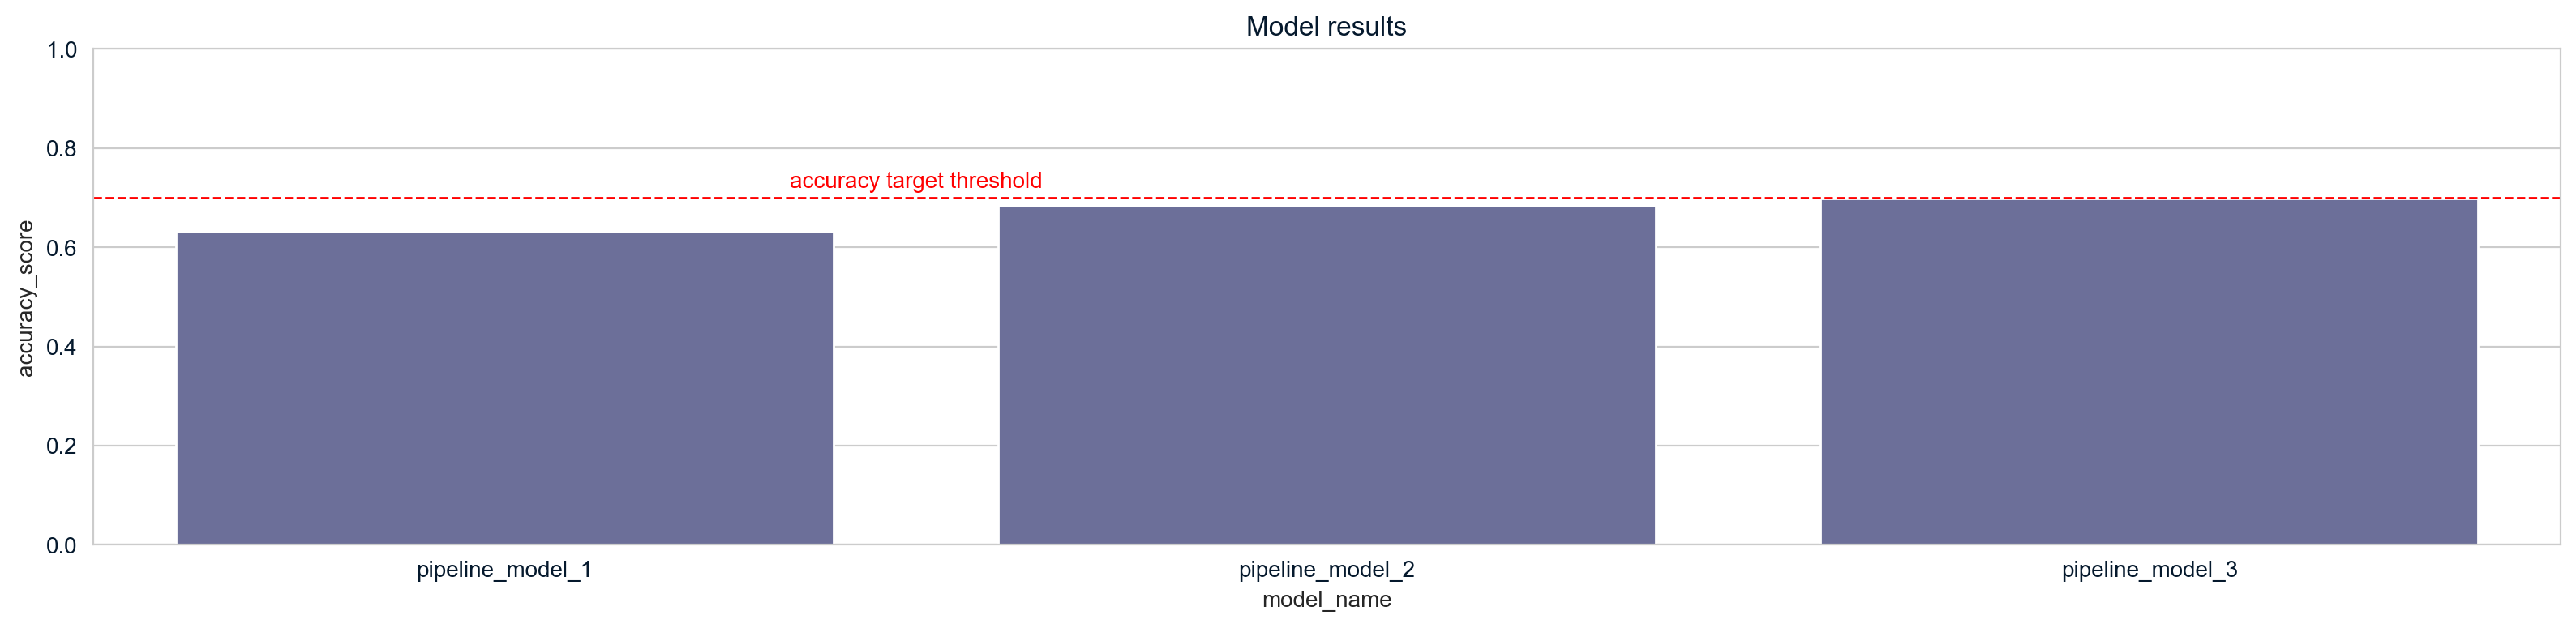

In [18]:
plt.figure(figsize = (16, 4))

tmp = pd.DataFrame(results)
ax = sns.barplot(data = tmp, x = 'model_name', y = 'accuracy_score')
ax.axhline(0.70, color = 'red', linestyle='--', linewidth = 1)
annotation = "accuracy target threshold"
ax.text(x = 0.5, y = 0.72, s = annotation, color = 'red', ha = 'center')

plt.title("Model results")
plt.ylim([0, 1])
plt.tight_layout()

# Comprehensive Data Cleaning & EDA

## Removing duplicate books / Creating a unique books dataframe

The presence of so many duplicated rows suggests that the dataset granularity is questionable for model building purposes. Indeed, a closer inspection reveals that the granuality of the dataset is not books (as it should be), but rather reviews. For instance, the book **Hannibal** by Thomas Harris appears 64 times in the dataset.

In [19]:
c = Counter(books['title'])
df = pd.DataFrame.from_dict(c, orient = 'index').reset_index()
df.columns = ['title','appearance']
df = df.sort_values(by = ['appearance', 'title'], ascending = False).head(10).reset_index(drop = True)
print("Most frequent duplicate books")
print("----------------------")
for i, row in df.iterrows():
    print(f"{i+1}) {row['title']}; appears {row['appearance']} times")

Most frequent duplicate books
----------------------
1) Hannibal; appears 64 times
2) Eldest (Inheritance, Book 2); appears 62 times
3) Jane Eyre (Large Print); appears 53 times
4) Jane Eyre (New Windmill); appears 44 times
5) Great Expectations; appears 41 times
6) A Tale of Two Cities - Literary Touchstone Edition; appears 41 times
7) The Five Love Languages: The Secret to Love that Lasts; appears 35 times
8) Good to Great; appears 30 times
9) Blue Like Jazz: Nonreligious Thoughts on Christian Spirituality; appears 30 times
10) Why Men Love Bitches: From Doormat to Dreamgirl - A Woman's Guide to Holding Her Own in a Relationship; appears 29 times


Let's dive deeper into this duplication issue and use the famous novel, **The Picture of Dorian Gray** by Oscar Wilde, as an example. The book title appears **28 times** in the dataset and is categorized both as a popular book and an unpopular book. This is logically impossible. About 43% (i.e. 12/28) of the Dorian Gray entries are encoded as 'Popular,' with the remainder labeled as 'Unpopular.' So how should the model interpret this book: popular or unpopular? We need a consistent definition for each unique book entry.

In [20]:
example_book = 'the Picture of Dorian Gray'
print("Sample of 10 'The Picture of Dorian Gray' entries")
books[books['title'] == example_book].sort_values(by = "popularity").reset_index(drop = True).sample(10, replace = False)

Sample of 10 'The Picture of Dorian Gray' entries


,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
7,the Picture of Dorian Gray,12.99,1/3,an outstanding book,This book is mainly about the corruption of th...,The Picture of Dorian Gray was first published...,'Oscar Wilde','Fiction',Popular
5,the Picture of Dorian Gray,12.99,1/1,This book is rich with hidden meaning.,This story is positively a masterpiece. Dorian...,The Picture of Dorian Gray was first published...,'Oscar Wilde','Fiction',Popular
17,the Picture of Dorian Gray,12.99,0/0,Book Before Movie,It has been said that this book is one of Osca...,The Picture of Dorian Gray was first published...,'Oscar Wilde','Fiction',Unpopular
27,the Picture of Dorian Gray,12.99,2/4,Not an easy book for modern readers,"This cautionary tale of sensuality, excess, va...",The Picture of Dorian Gray was first published...,'Oscar Wilde','Fiction',Unpopular
13,the Picture of Dorian Gray,12.99,1/1,The material soul,This book offers its readers a chance to under...,The Picture of Dorian Gray was first published...,'Oscar Wilde','Fiction',Unpopular
11,the Picture of Dorian Gray,12.99,0/0,Loved everyting about this edition!,My grown daughter bought this for me as a Chri...,The Picture of Dorian Gray was first published...,'Oscar Wilde','Fiction',Popular
25,the Picture of Dorian Gray,12.99,2/4,Unbalanced and Vague,Unfortunately I didn't like this classic story...,The Picture of Dorian Gray was first published...,'Oscar Wilde','Fiction',Unpopular
22,the Picture of Dorian Gray,12.99,0/0,Picture of Dorian Gray,This free classic version for my Kindle was ve...,The Picture of Dorian Gray was first published...,'Oscar Wilde','Fiction',Unpopular
10,the Picture of Dorian Gray,12.99,1/1,A Chilling Read,"""It is the spectator, and not life, that art r...",The Picture of Dorian Gray was first published...,'Oscar Wilde','Fiction',Popular
2,the Picture of Dorian Gray,12.99,0/2,"Spooky, creepy and downright fun!",A novel about an especially gorgeous young man...,The Picture of Dorian Gray was first published...,'Oscar Wilde','Fiction',Popular


### Determining book popularity when the dataset is ambiguous

I am going to make an subjective call here. 

For all unique book entries that have been duplicated, if half of the entries are categorized as popular, then the book will be categorized as popular for the sake of model building. Otherwise, it will be categorized as unpopular. In my code, I call this my "popularity threshold." 

As you can see below, **1,237 books** (18% of unique book instances) were not universally categorized as either popular and unpopular and therefore had to go through my simple popularity threshold decision tree. Of course, I would much rather prefer that the dataset were more unambiguous about the target value. If this were a real company scenario, then I would seek to define popularity through more formal procedural channels to reach collective agreement on the definition of popular.

For this instance, I define a popular book to mean any book in the dataset whose popularity percentage (defined as the ratio of instances labeled popular over total observations) is greater than or equal to 50%. **The Picture of Dorian Gray**, having only 43% of its entries encoded as popular, does not meet the defintion of a being a popular book. Sorry, Oscar Wilde.

In [21]:
# determining book popularity
popularity_threshold = 0.5

df = books.copy()
df = tc.clean_popularity(df)

# add title foreign key
df['title_fk'] = df['title'].apply(tc.clean_text)

# add authors foreign key
df = ac.clean_authors(df)
df['authors_fk'] = df['authors_list'].apply(lambda x: "".join(x))
df['fk'] = df['authors_fk'] + df['title_fk']

# split the book details from the popularity metrics
detail_df = df[['fk','title','authors','categories', 'description']]
detail_df = detail_df.groupby('fk')[['title','authors','categories', 'description']].first().reset_index()

# split the popularity metrics from the book details
df = df.groupby('fk').agg({'popularity': ['count', 'sum']}).reset_index()
#df = df.groupby(['title','authors','categories', 'description']).agg({'popularity': ['count', 'sum']}).reset_index()
df.columns = list(map("_".join, df.columns.values))
df.columns = [c.replace("_","") for c in df.columns]
df['popularitypct'] = df['popularitysum'] / df['popularitycount']

df = pd.merge(detail_df, df, on = 'fk')

df['popular'] = df['popularitypct'].apply(lambda x: 1 if x >= popularity_threshold else 0)

pop_df = df.copy()
print(f"Total of {pop_df.shape[0]} books remaining.")

Total of 6979 books remaining.


In [22]:
tmp = df[(df['popularitypct'] != 0) & (df['popularitypct'] != 1)]
print(f"{tmp.shape[0]} books ({round(tmp.shape[0] / df.shape[0], 2) * 100}% of the total) were not universally categorized as Popular or Unpopular")
tmp.sort_values(by = 'popularitypct', ascending = False)[['title', 'authors','categories','popularitypct']].head()

1237 books (18.0% of the total) were not universally categorized as Popular or Unpopular


,title,authors,categories,popularitypct
4185,Gods and Kings (Chronicles of the Kings #1),'Lynn Austin','Fiction',0.909091
975,Half of a Yellow Sun,'Chimamanda Ngozi Adichie','Fiction',0.857143
3832,The Supernatural Ways of Royalty: Discovering ...,"'Kris Vallotton', 'Bill Johnson'",'Religion',0.833333
4085,Warped Passages: Unraveling the Mysteries of t...,'Lisa Randall','Science',0.833333
4068,"Life Is Hard, Food Is Easy: The 5-Step Plan to...",'Linda Spangle','Health & Fitness',0.833333


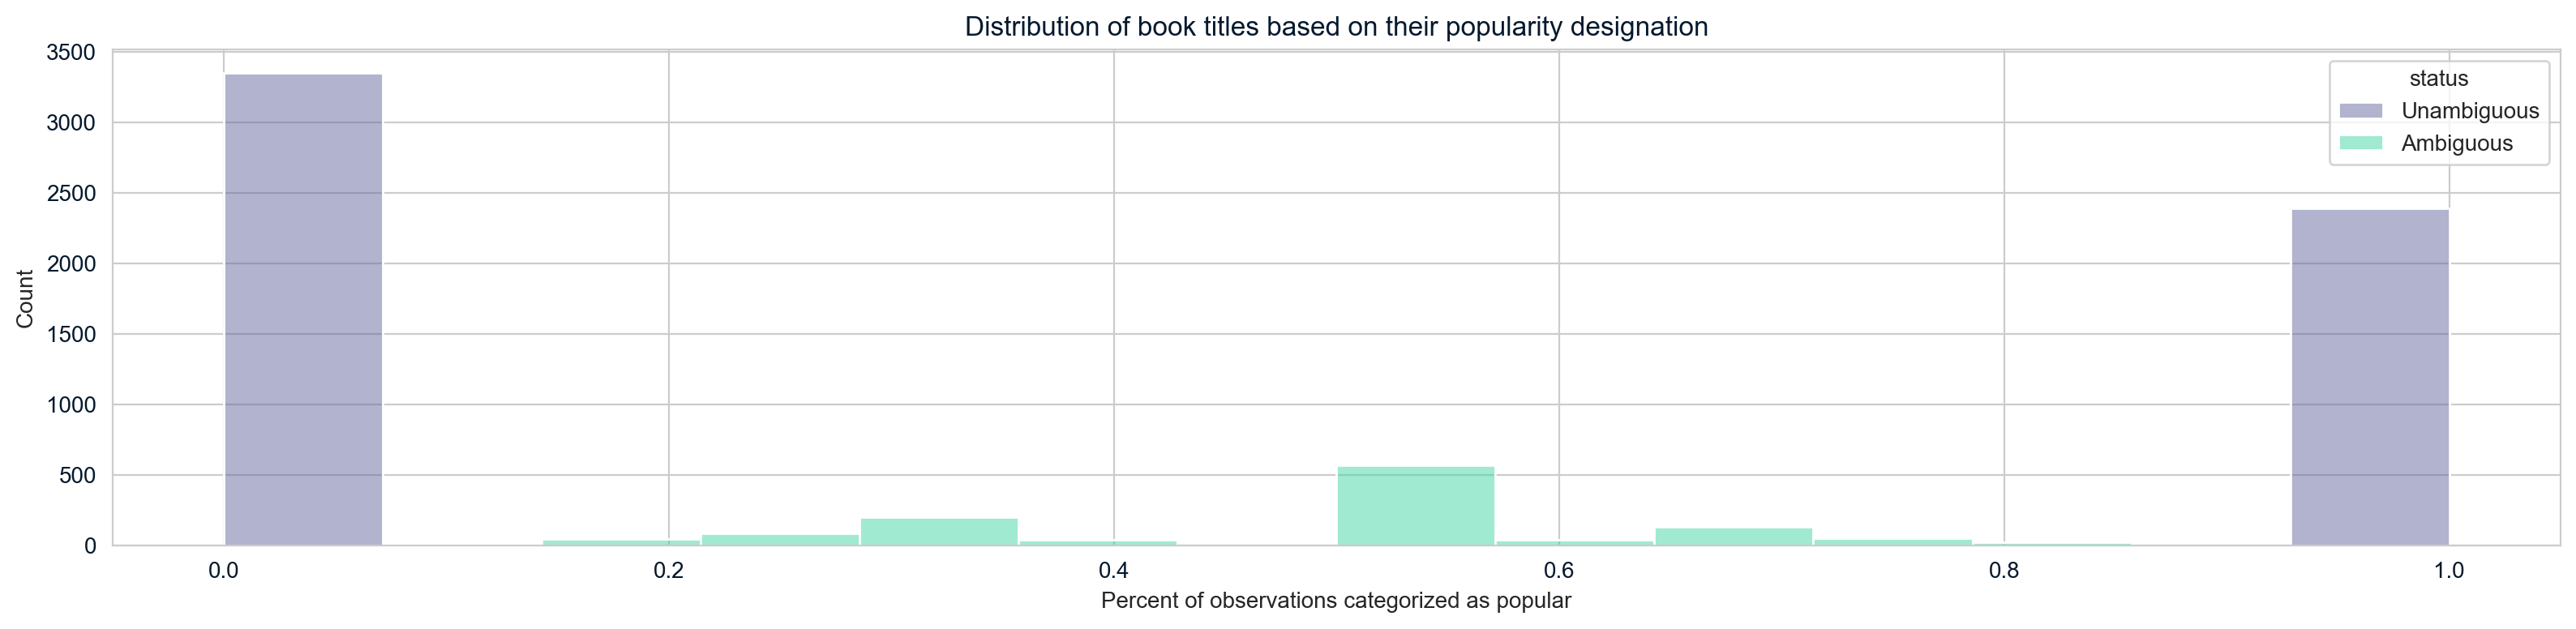

In [23]:
pop_df['status'] = pop_df['popularitypct'].apply(lambda x: "Ambiguous" if (x > 0) and (x < 1) else "Unambiguous")

plt.figure(figsize = (16, 4))
sns.histplot(data = pop_df, x = 'popularitypct', hue="status")
plt.title("Distribution of book titles based on their popularity designation")
plt.xlabel("Percent of observations categorized as popular")

pop_df = pop_df.drop(['popularitycount', 'popularitysum', 'popularitypct', 'status'], axis = 1).sort_values(by = 'title')
plt.tight_layout()

In the chart above, you can see the number of books with an ambiguous popularity classification. These items, colored in orange, will become unambiguous after I apply my logic across the target column.

### Revising the Target Column

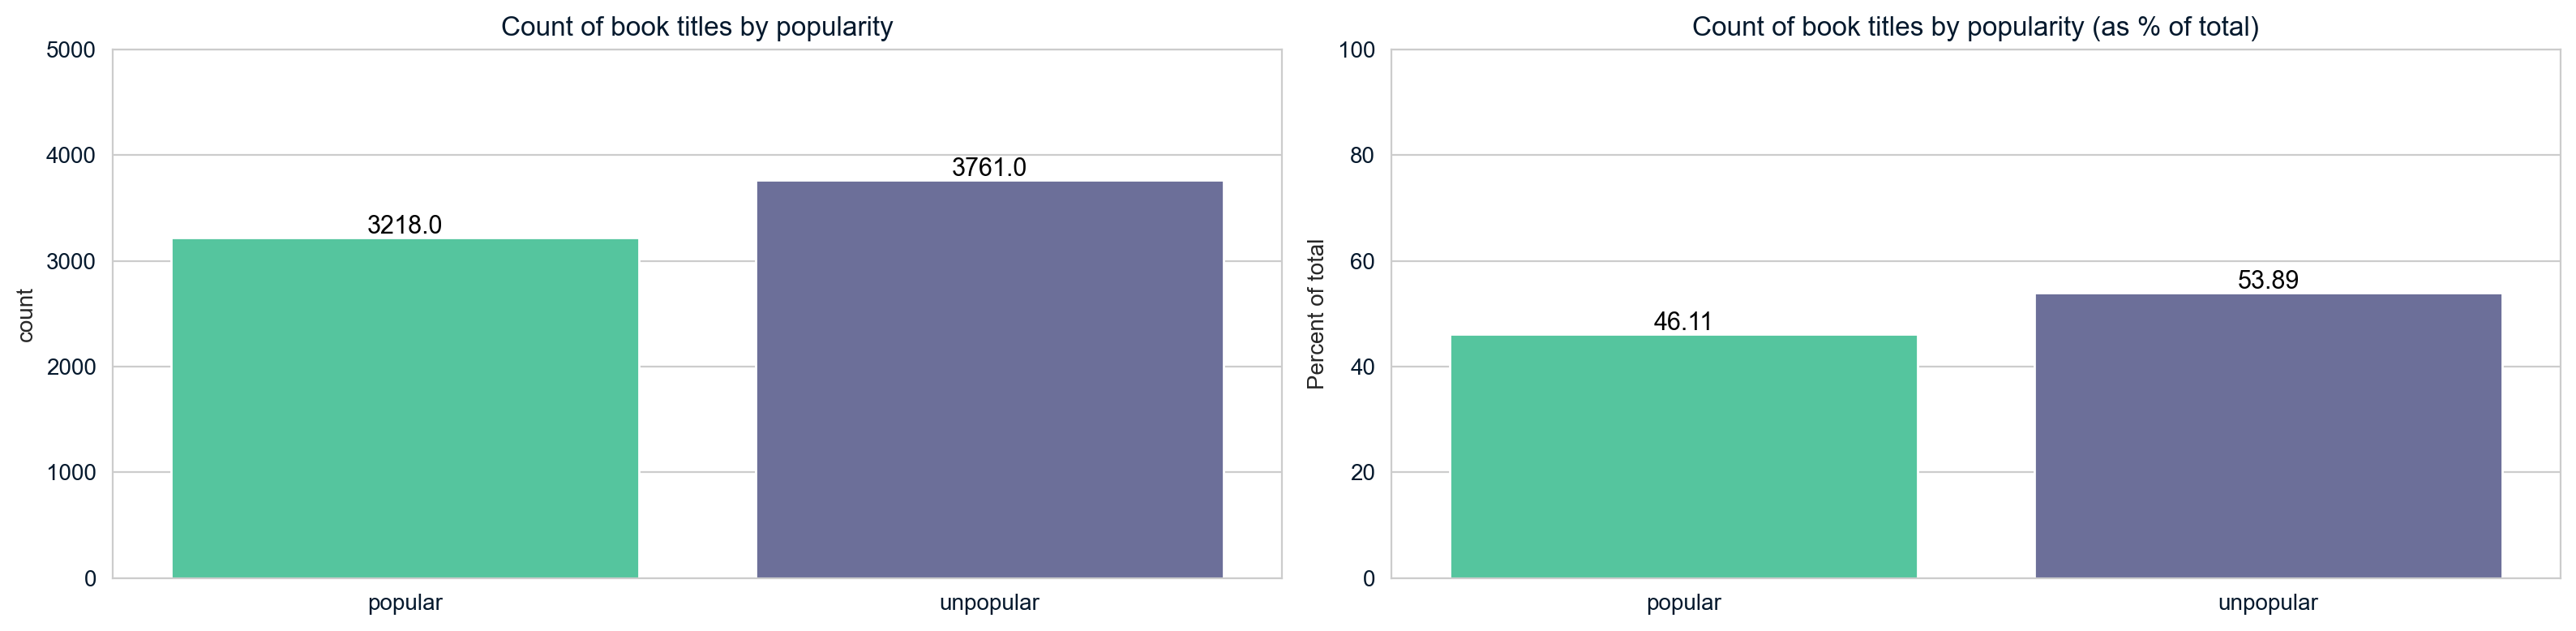

In [24]:
tmp = pop_df.copy()
tmp['popular'] = tmp['popular'].map(m.map_reverse_popular)

plt.figure(figsize = (16, 4))
plt.subplot(1, 2, 1)
sns.countplot(data = tmp, x = 'popular', order = ['popular', 'unpopular'], hue='popular')
plt.title("Count of book titles by popularity")
plt.xlabel("")
plt.ylim([0, 5000])

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.subplot(1, 2, 2)
tmp = tmp['popular'].value_counts(normalize = True).reset_index()
tmp['proportion'] = tmp['proportion'].apply(lambda x: round(x * 100, 2))
sns.barplot(data = tmp, x = 'popular', y = 'proportion',  order = ['popular', 'unpopular'], hue='popular')
plt.title("Count of book titles by popularity (as % of total)")
plt.ylabel("Percent of total")
plt.ylim([0, 100])
plt.xlabel("")

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()

A new dataset of **6,979 books** was created out of unique title indexing. A total of 53.8% of books were categorized as unpopular, with the remainder categorized as popular. Although not perfectly balanced among the two groups, this target distribution is more balanced than that of the original dataset. Based on the aforementioned 50% threshold for determining an ambiguous book's popularity, each book has now been classified distinctly as popular or unpopular. The column for 'popular' has been remapped as a binary column for the purposes of model building, where 1 = popular and 0 = unpopular.

## Feature Engineering: Title

This column category is not essential to model building, but I expect to make a feature that measures the length of the title. Therefore, I want to remove all text that is inessential to the overall title. This text can be identified by the presence of brackets in the title text. This is not universally true, but rather is generalizable as a rule.

For instance, the book **"Cool Stuff" They Should Teach in School: Cruise into the Real World...with styyle (jobs/people skills/attiude/goals/money)** has excess text in its parentheses that I would like to filter out. Then I will measure the overall length of the book title text and append it as a feature to the dataframe.

In [25]:
print("Book titles with excess text")
print("----------------------")
tmp = pop_df[pop_df['title'].apply(lambda x: '(' in x)].reset_index(drop = True)
for i, row in tmp.iterrows():
    print(f"{i + 1}) {row['title']}")
    if i == 9:
        break

Book titles with excess text
----------------------
1) "Cool Stuff" They Should Teach in School: Cruise into the Real World...with styyyle (jobs/people skills/attitude/goals/money)
2) "Then Junior Said to Jeff. . .": The Best NASCAR Stories Ever Told (Best Sports Stories Ever Told)
3) 10. St. Athanasius: The Life of St. Antony (Ancient Christian Writers)
4) 100 Simple Secrets of Happy Families: What Scientists Have Learned and How You Can Use It (100 Simple Secrets Series)
5) 100 Ways to Build Self-Esteem and Teach Values (Loomans, Diane)
6) 101 Hiring Mistakes Employers Make...and How to Avoid Them (The Careersavvy Series)
7) 101 Performance Projects for Your BMW 3 Series 1982-2000 (Motorbooks Workshop)
8) 101 Sportbike Performance Projects (Motorbooks Workshop)
9) 110 People Who Are Screwing Up America (and Al Franken Is #37)
10) 12 Steps for the Recovering Pharisee (like me)


In [26]:
# Clean titles with excess text
pop_df = tc.clean_title(pop_df)

# View list again
filter_list = tmp['fk'].to_list()
tmp = pop_df[pop_df['fk'].isin(filter_list)].reset_index(drop = True)

print("Book titles after removing parentheses")
print("----------------------")
for i, row in tmp.iterrows():
    print(f"{i + 1}) {row['title']}")
    if i == 10:
        break

Book titles after removing parentheses
----------------------
1) "Cool Stuff" They Should Teach in School: Cruise into the Real World...with styyyle
2) "Then Junior Said to Jeff. . .": The Best NASCAR Stories Ever Told
3) 10. St. Athanasius: The Life of St. Antony
4) 100 Simple Secrets of Happy Families: What Scientists Have Learned and How You Can Use It
5) 100 Ways to Build Self-Esteem and Teach Values
6) 101 Hiring Mistakes Employers Make...and How to Avoid Them
7) 101 Performance Projects for Your BMW 3 Series 1982-2000
8) 101 Sportbike Performance Projects
9) 110 People Who Are Screwing Up America
10) 12 Steps for the Recovering Pharisee
11) 12,000 Miles in the Nick of Time: A Semi-Dysfunctional Family Circumnavigates the Globe


### EDA: Book Title Length

In this instance, I create a feature called book_title_length, measured using my revised book title column. There does not appear to be a significant difference in book popularity based on title length: the means and distributions of both groups are quite similar upon visual inspection. The value of this feature to the overall model is questionable.

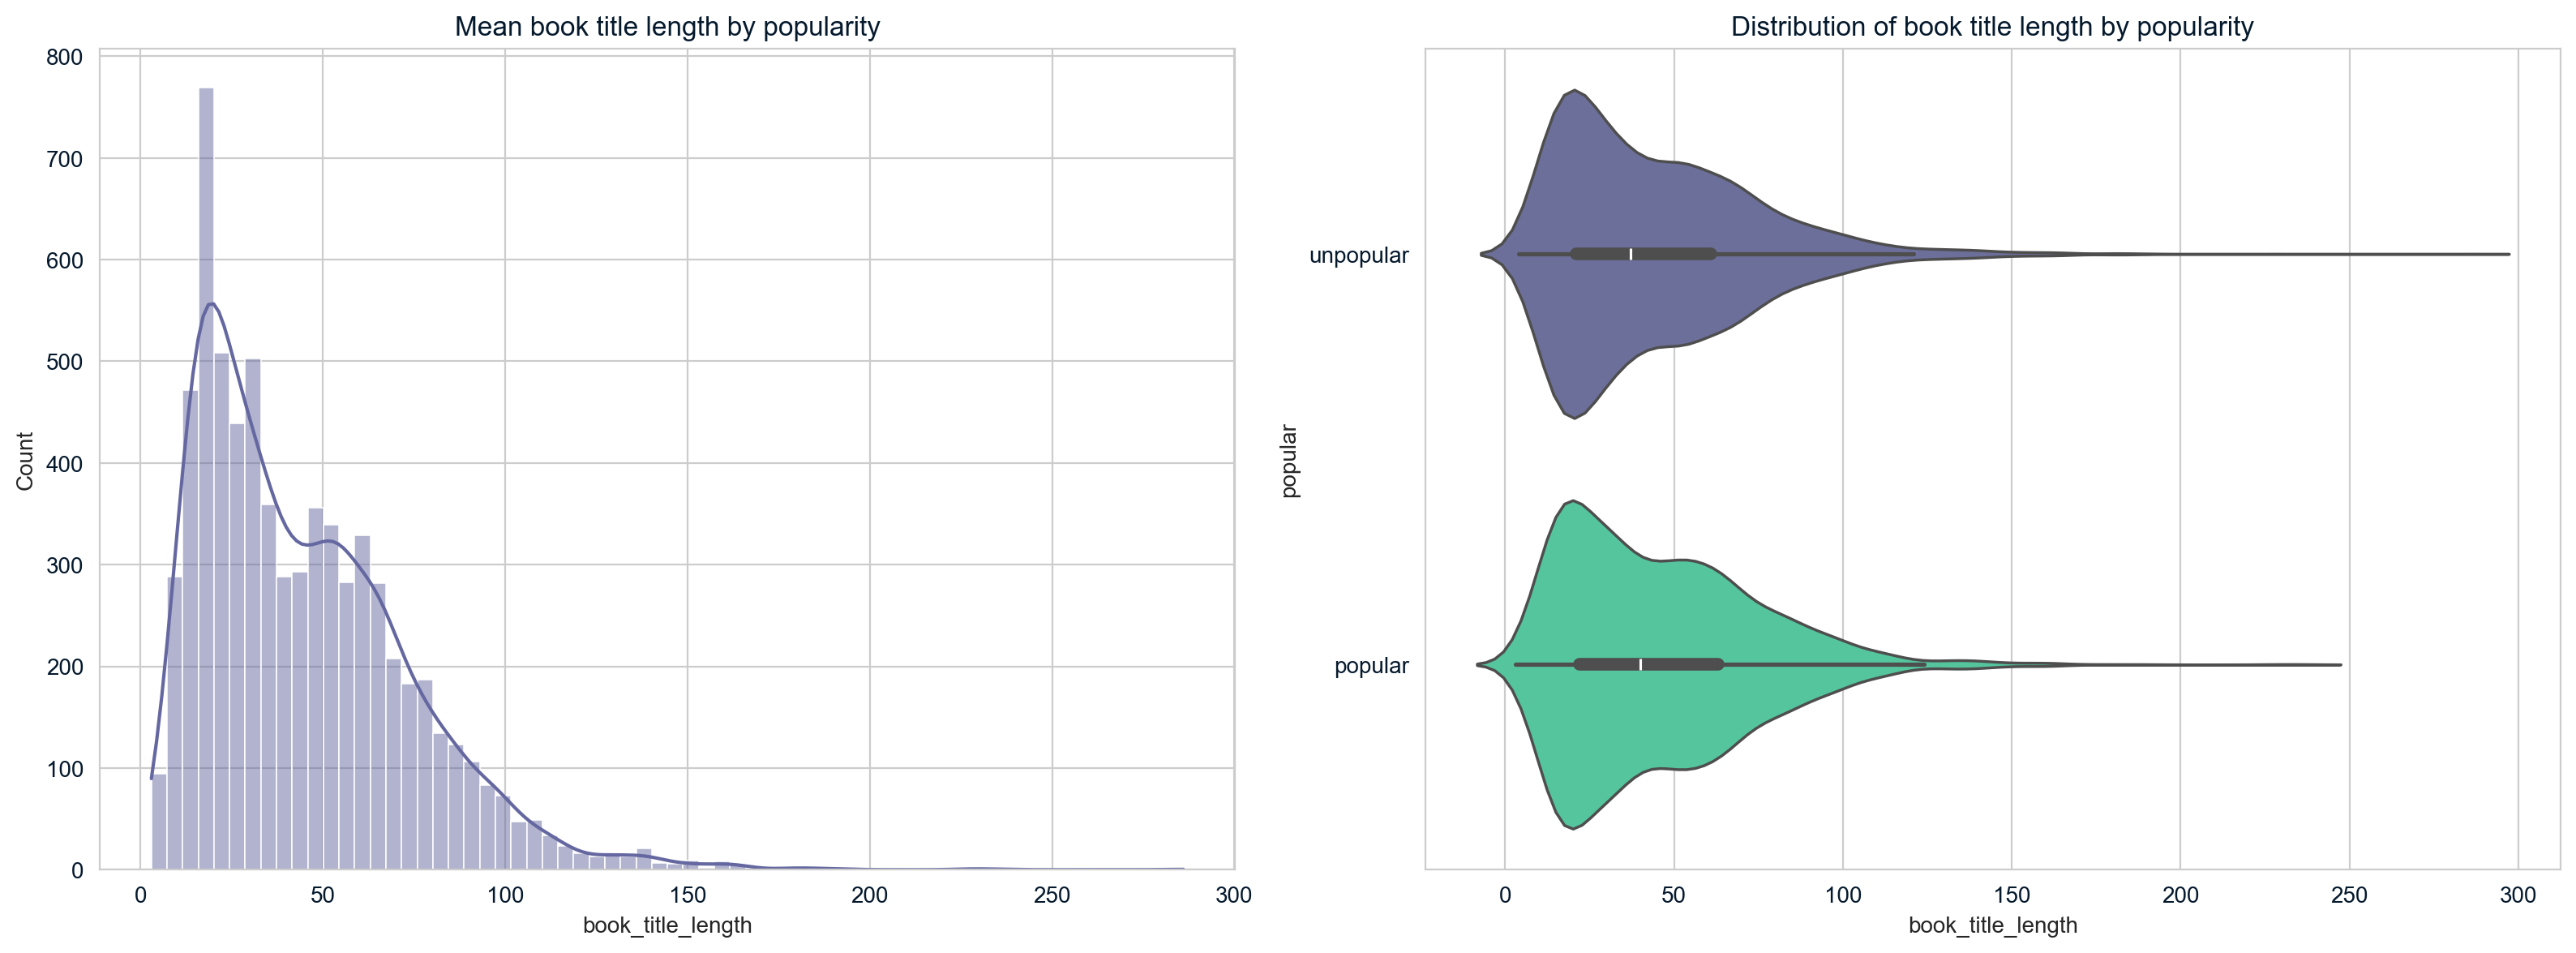

In [27]:
tmp = pop_df.copy()
tmp['popular'] = tmp['popular'].map(m.map_reverse_popular)
tmp1 = tmp.groupby('popular')['book_title_length'].mean().reset_index()
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.histplot(data = tmp, x = 'book_title_length', kde = True)
#sns.barplot(data = tmp1, y = 'popular', x = 'book_title_length', hue = 'popular')
plt.title("Mean book title length by popularity")

plt.subplot(1, 2, 2)
sns.violinplot(data = tmp, x = 'book_title_length', y = 'popular', hue = 'popular')
plt.title("Distribution of book title length by popularity")
plt.tight_layout()

## Feature Engineering: Category names

The category column is not only poorly encoded, but it contains 313 unique values, some of which are idiosyncratic and would benefit from remapping into genres and sub-genres.

In the end, I conclude on seven distinct genres: non-fiction, literature & fiction, lifestyle & home, children's & young adult, arts & entertainment, special topics, and travel & adventure. For sub-genres, I empowered AI to review the original categories and determine logical groupings. To avoid overfitting, I intend to reduce infrequent sub-genres into a blanket category called 'other'. Ultimately, I do not want my model to overfit based on the book genre.

In [28]:
c = Counter(pop_df['categories'])
tmp = pd.DataFrame.from_dict(c, orient = 'index').reset_index()
tmp.columns = ['category', 'count']
tmp['category'] = tmp['category'].str.replace("'","")
tmp.sort_values(by = 'count', ascending = False).head(10)

,category,count
24,Fiction,1143
17,Religion,554
7,Biography & Autobiography,368
1,History,360
16,Business & Economics,337
4,Juvenile Fiction,323
30,Computers,268
27,Health & Fitness,191
12,Family & Relationships,183
19,"Body, Mind & Spirit",176


In [29]:
# remap categories
pop_df = tc.clean_categories(pop_df, m.map_genres)
pop_df[['title','genre','sub_genre']].head()

0 remapped genres missing
remapped categories


,title,genre,sub_genre
0,"""Cool Stuff"" They Should Teach in School: Crui...",non-fiction,education
1,"""Happiness Is Not My Companion"": The Life of G...",non-fiction,history
2,"""Then Junior Said to Jeff. . ."": The Best NASC...",special topics,sports & recreation
3,'Filming of Gone With the Wind',arts & entertainment,performing arts
4,.Hack//Legend of the Twilight Vol. 3,children's & young adult,children's fiction


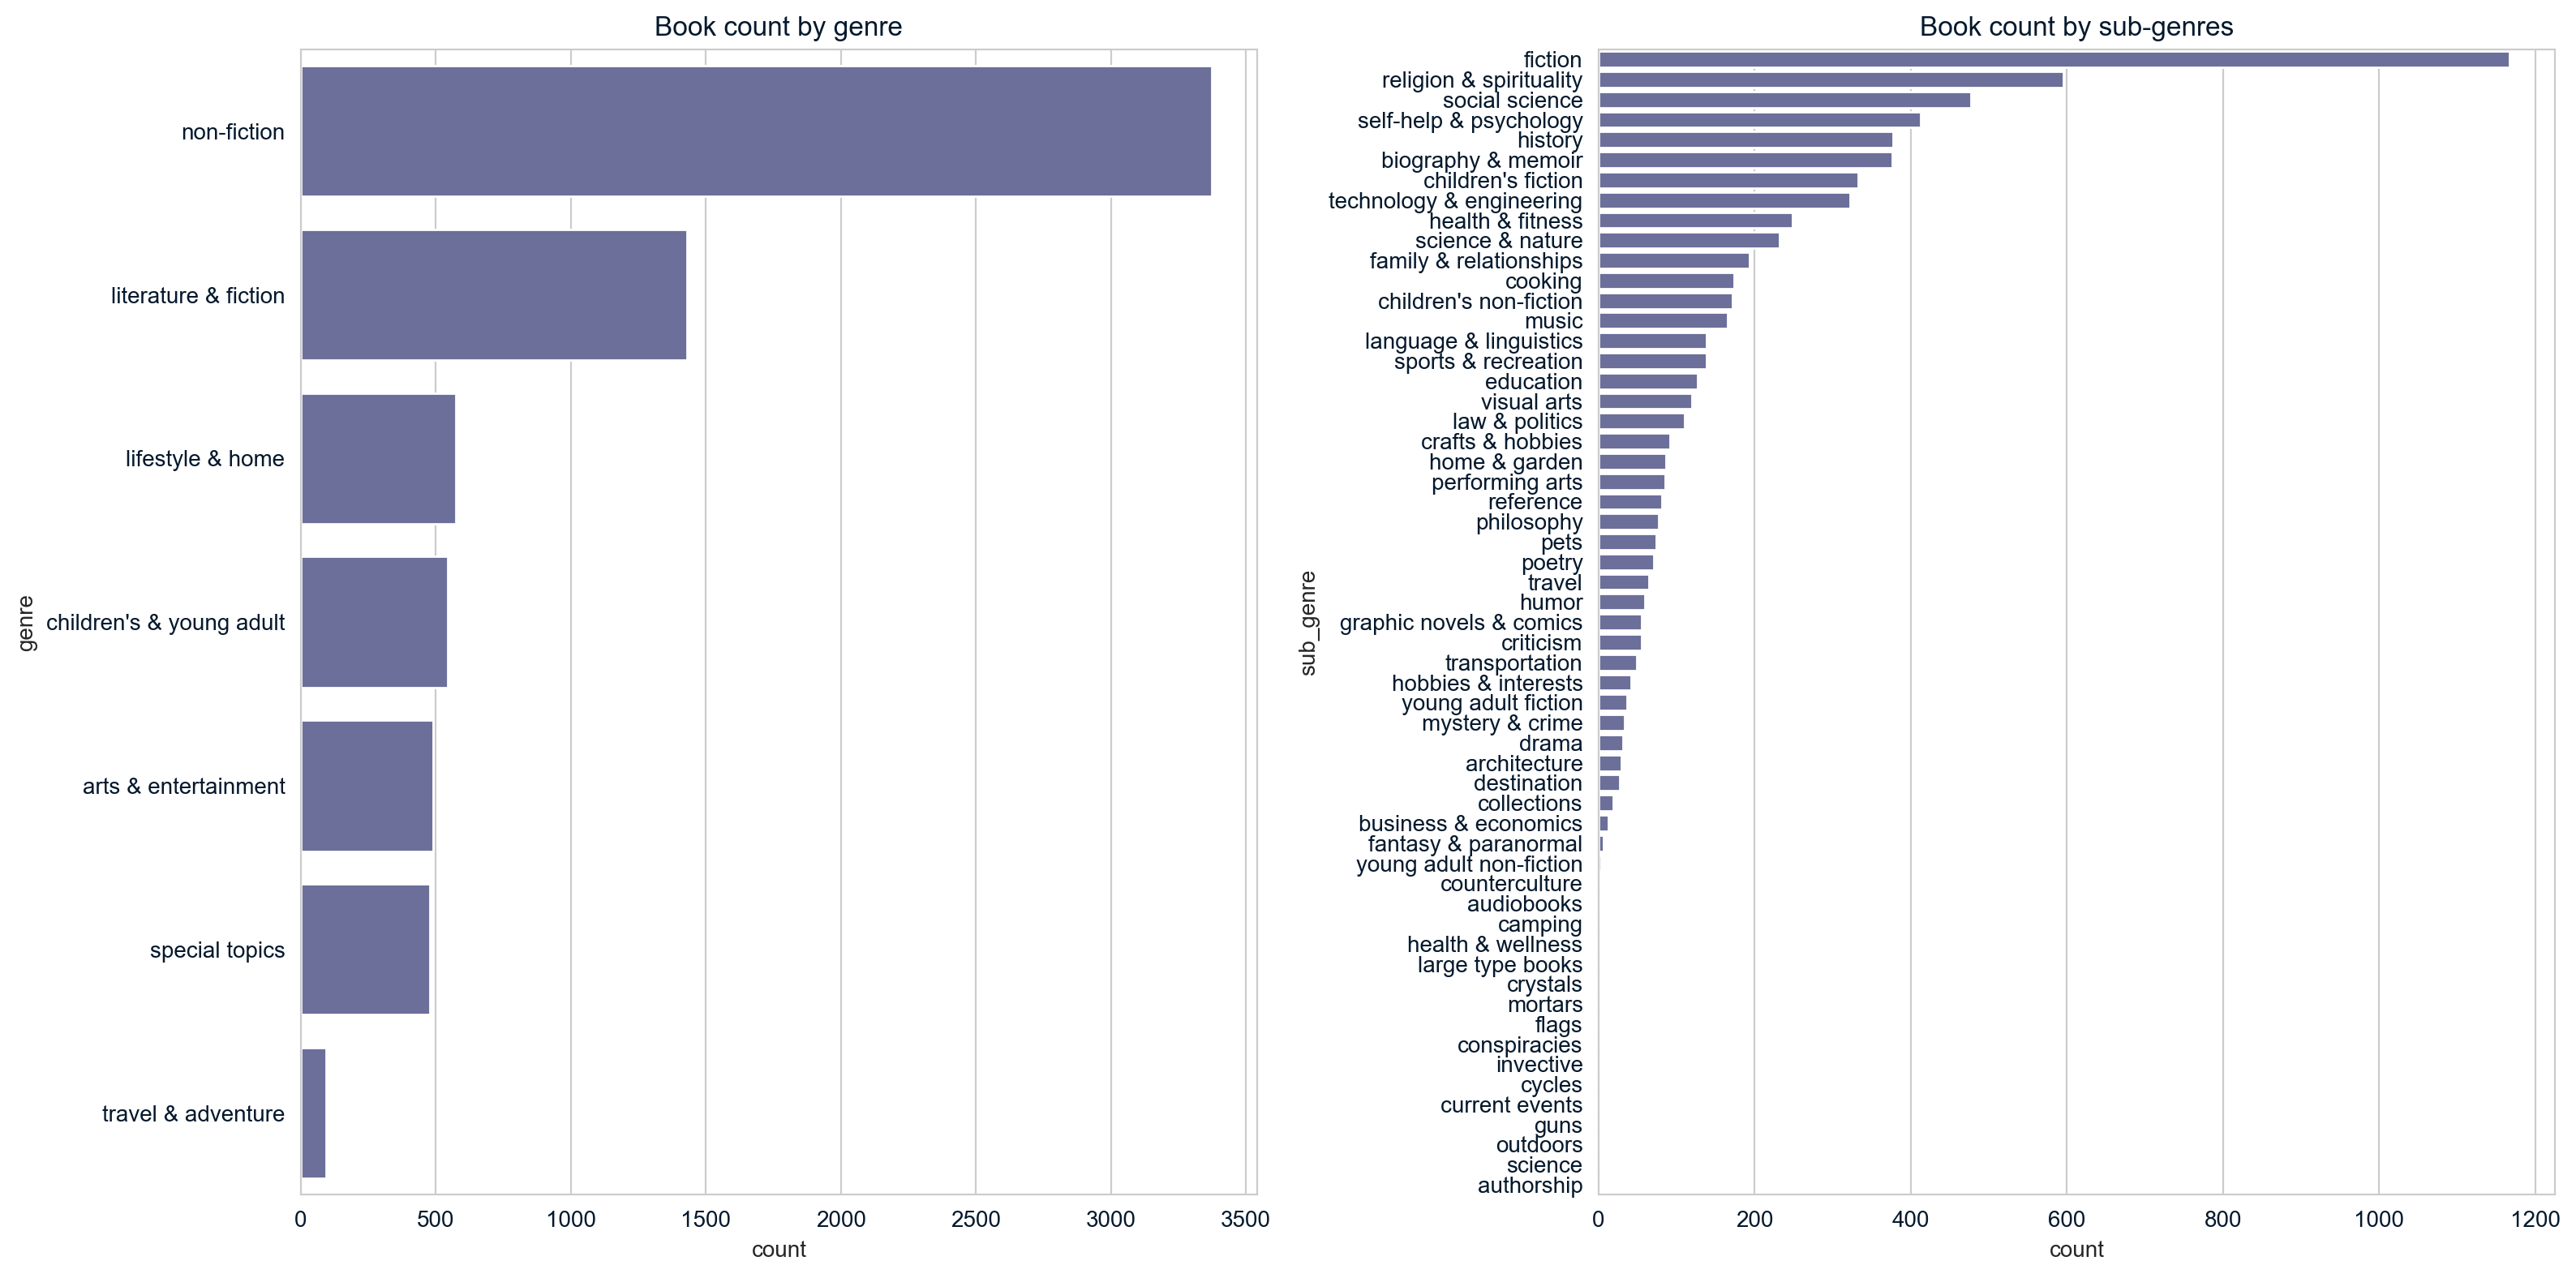

In [30]:
plt.figure(figsize = (16, 8))

plt.subplot(1, 2, 1)
plt.title("Book count by genre")
tmp = pop_df['genre'].value_counts().reset_index()
sns.barplot(data = tmp, y = 'genre', x = 'count')

plt.subplot(1, 2, 2)
plt.title("Book count by sub-genres")
tmp = pop_df['sub_genre'].value_counts().reset_index()
sns.barplot(data = tmp, y = 'sub_genre', x = 'count')

plt.tight_layout()

The above chart shows the new distributions of the newly-created genre and sub-genre categories. I am not satisfied with the sub-genre category count and as a means to lower the risk of my model overfitting, will reduce the number of unique sub-genres as a next step.

### Recategorized rare sub-genres to blanket category 'other'

As you see in the chart above on the right, the remapping process has produced an excess count of sub-genres, 22 of which have few than 30 observations in the dataset. I would like to regroup these minority classes into an umbrella class called 'other' to prevent my model from overfitting.

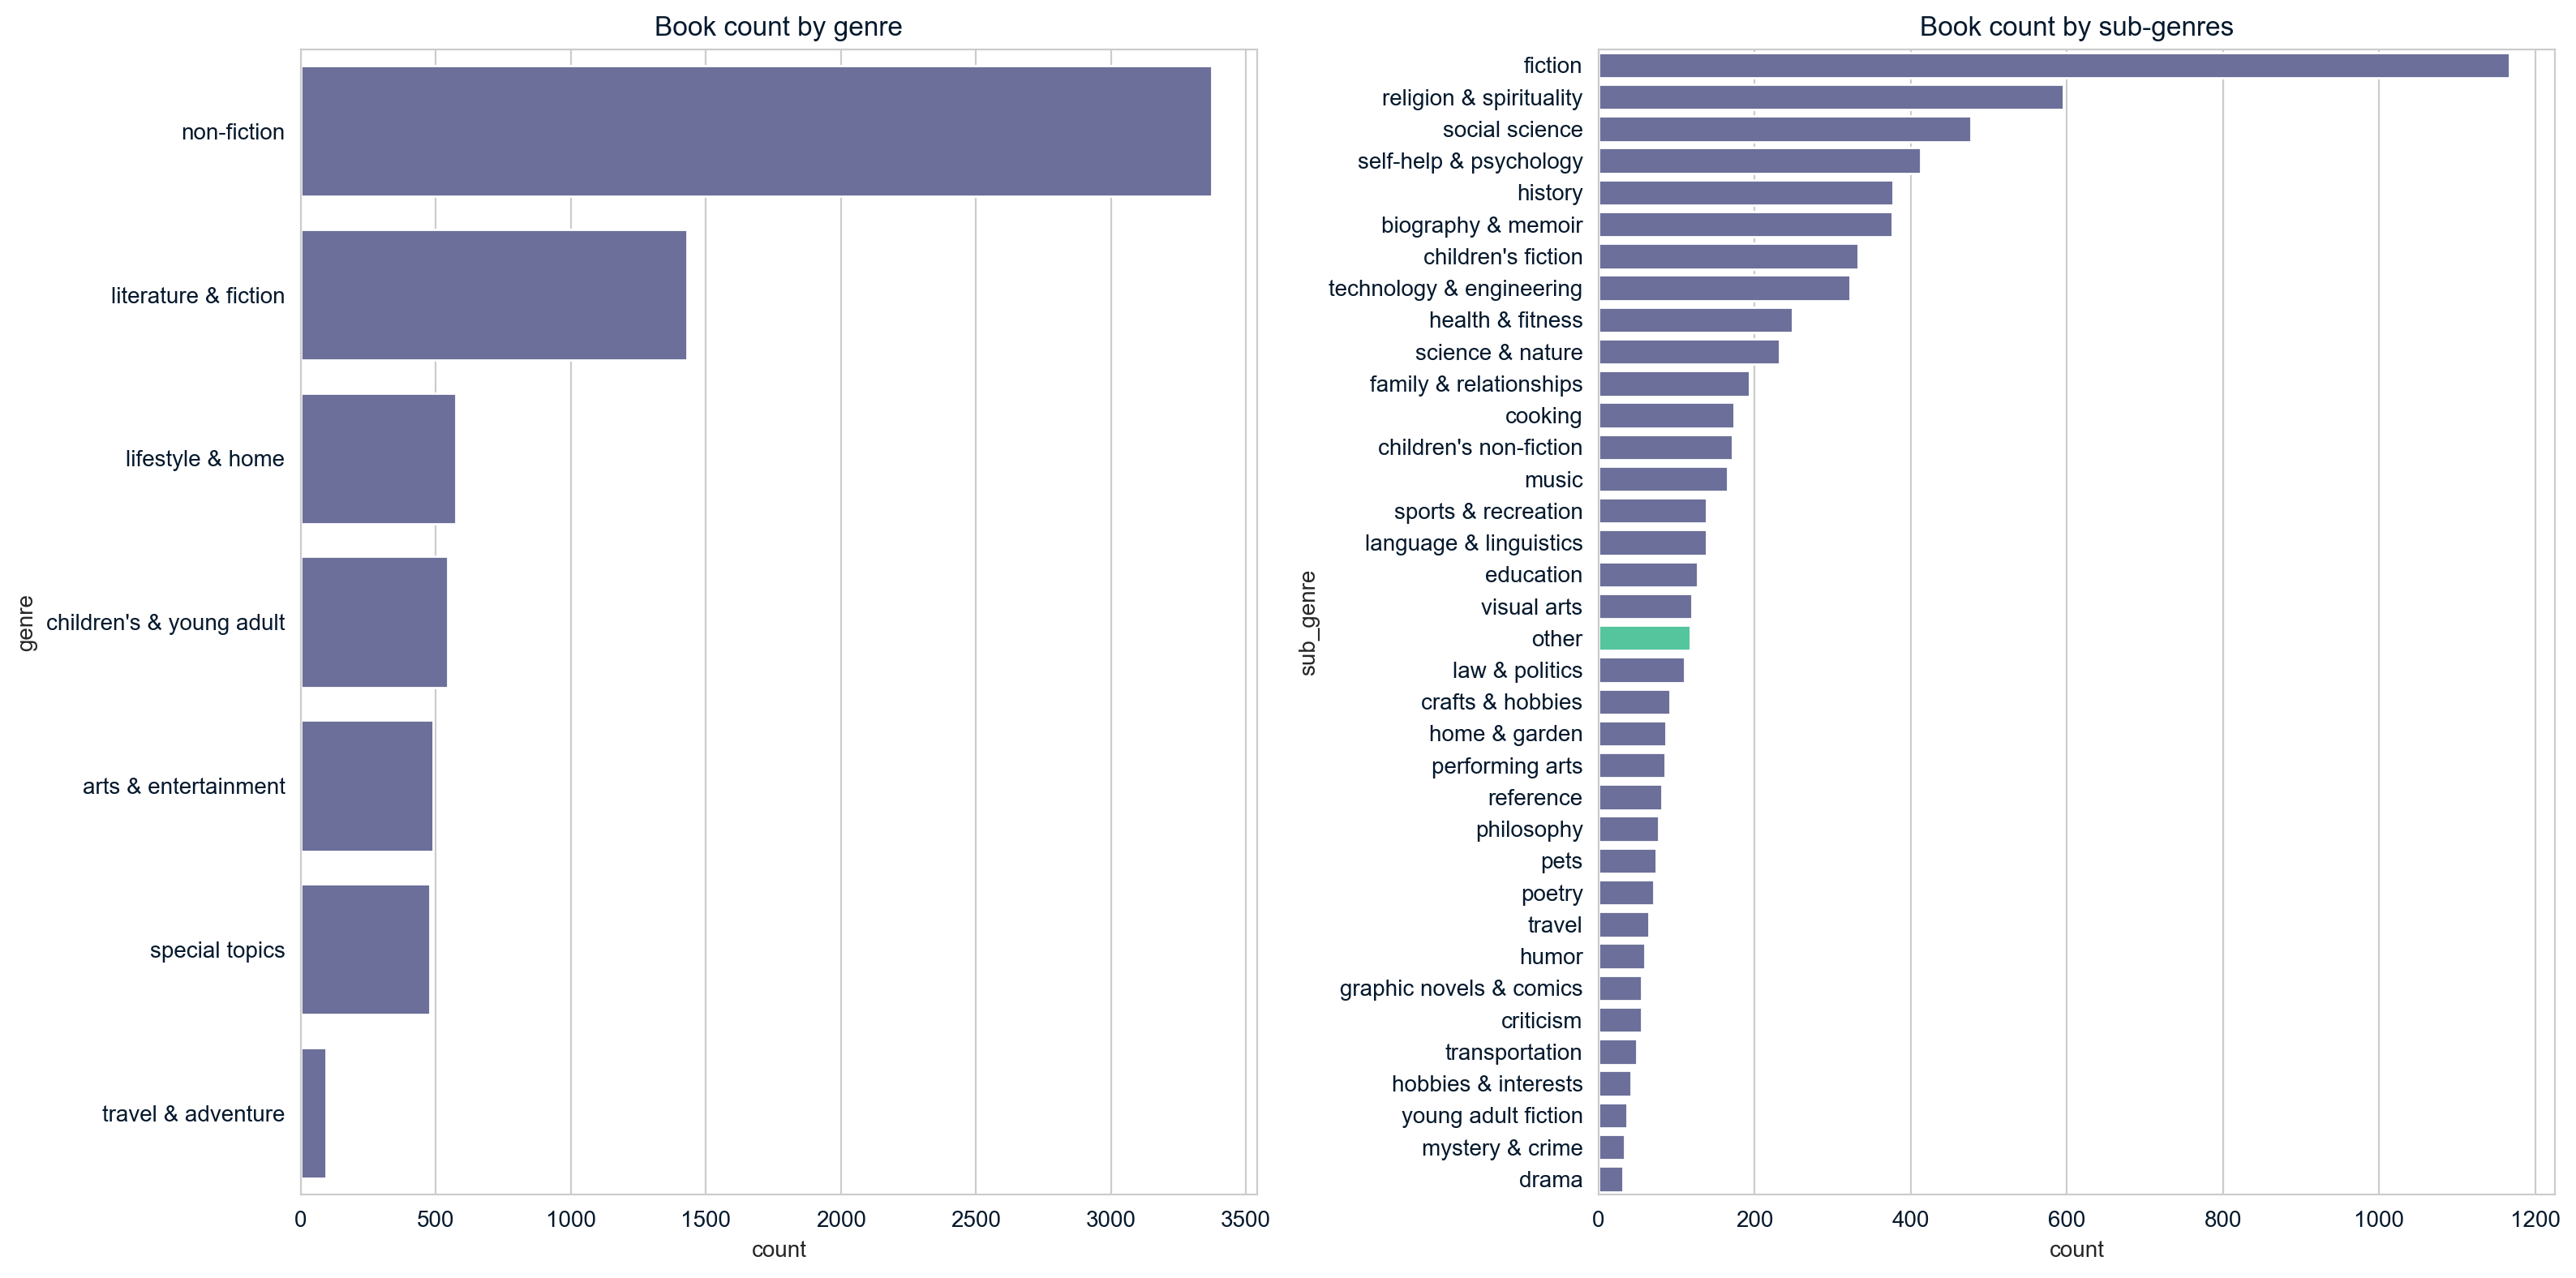

In [31]:
# If there are fewer than this many books in sub-genre category, change it to 'other'
threshold = 30

tmp = pop_df['sub_genre'].value_counts().reset_index()
tmp['check'] = tmp['count'] < threshold

mapping = {}
for i, row in tmp.iterrows():
    if row['check']:
        mapping[row['sub_genre']] = 'other'
    else:
        mapping[row['sub_genre']] = row['sub_genre']
pop_df['sub_genre'] = pop_df['sub_genre'].map(mapping)

plt.figure(figsize = (16, 8))

plt.subplot(1, 2, 1)
plt.title("Book count by genre")
tmp = pop_df['genre'].value_counts().reset_index()
sns.barplot(data = tmp, y = 'genre', x = 'count')

plt.subplot(1, 2, 2)
plt.title("Book count by sub-genres")
tmp = pop_df['sub_genre'].value_counts().reset_index()
tmp['normal'] = tmp['sub_genre'].apply(lambda x: 1 if x == 'other' else 0)
sns.barplot(data = tmp, y = 'sub_genre', x = 'count', hue = 'normal')

plt.legend().remove()

plt.tight_layout()

The newly-remapped sub-genre column has 36 unique values, all of which have an observation count greater than 30. The new 'other' sub-genre has 117 observations, falling into the middle rank in terms of observation count.

### EDA: Genre Count and Net Difference in Popularity

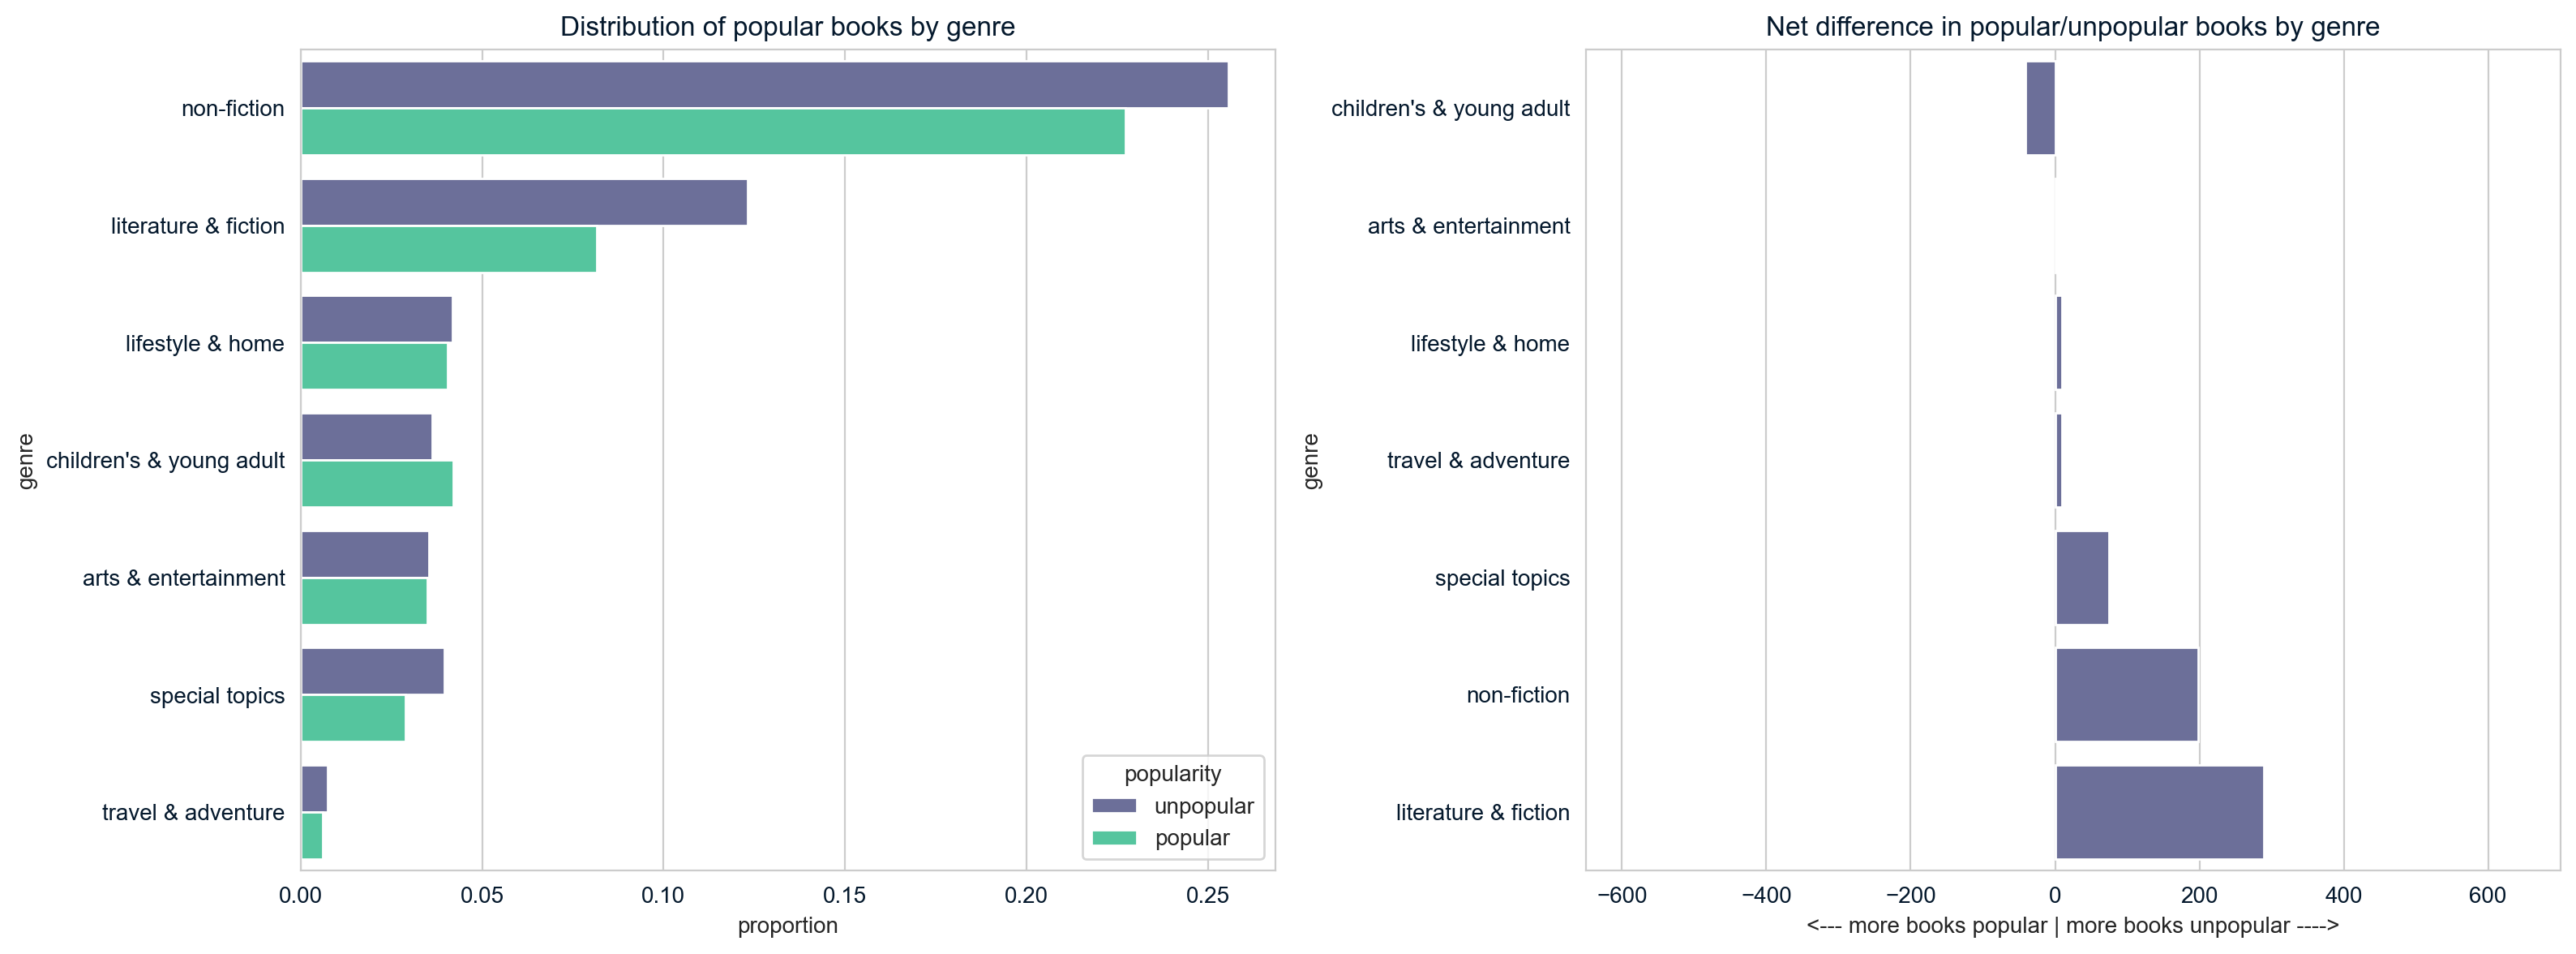

In [32]:
tmp = pop_df.copy()
threshold = 20

tmp = tmp.groupby(['genre', 'popular'])['title'].count().reset_index()
tmp = pd.pivot_table(data = tmp, index = 'genre', columns = 'popular', values = 'title').fillna(0)
#tmp.columns = ['unpopular', 'popular']
tmp.columns = [m.map_reverse_popular[c] for c in tmp.columns]
tmp = tmp.reset_index()
tmp['total'] = tmp['unpopular'] + tmp['popular']
tmp = tmp.sort_values(by = 'total', ascending = False)

# Plot 1
tmp3 = tmp.copy()
total = tmp3['total'].sum()
tmp3['unpopular'] = tmp3['unpopular'] / total
tmp3['popular'] = tmp3['popular'] / total
tmp3 = tmp3.drop('total', axis = 1)
tmp3 = pd.melt(tmp3, id_vars = 'genre', value_vars=['unpopular', 'popular'], value_name='proportion')
tmp3.columns = ['genre', 'popularity', 'proportion']
tmp3

tmp2 = tmp.copy()
tmp2['diff'] = tmp2['unpopular'] - tmp2['popular']
tmp2 = tmp2.sort_values(by = 'diff', ascending = True)


plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
plt.title("Distribution of popular books by genre")
sns.barplot(data = tmp3, y = 'genre', x = 'proportion', hue = 'popularity')

plt.subplot(1, 2, 2)
plt.title("Net difference in popular/unpopular books by genre")
sns.barplot(data = tmp2, y = 'genre', x = 'diff')
plt.xlabel("<--- more books popular | more books unpopular ---->")
plt.xlim([-650, 700])

plt.tight_layout()

How does book popularity vary by genre?

After remapping, we observe the following in the left chart above:

- Non-Fiction has the highest proportion of both popular and unpopular books; Popular non-fiction books are slightly fewer than unpopular ones.
- Literature & Fiction: A significant proportion of popular books; More unpopular than popular books in this genre.
- Lifestyle & Home, Children’s & Young Adult, Arts & Entertainment: These genres have a more balanced distribution of popular and unpopular books.
- Special Topics: Shows a higher proportion of unpopular books compared to popular ones.
- Travel & Adventure: The least proportion of books, both popular and unpopular are relatively even.

From the right chart we observe:
- Literature & Fiction: A large positive net difference (-300 books), indicating more unpopular literature & fiction books.
- Non-Fiction: Significant positive net difference (-200 books), indicating many more unpopular non-fiction books than popular ones.
- Special Topics: A positive net difference, indicating more unpopular books.
- Arts & Entertainment, Lifestyle & Home: These genres have small positive net differences, indicating a relatively balanced distribution but still more unpopular books.
- Travel & Adventure: A very small positive net difference, indicating a nearly equal number of popular and unpopular books.
- Children’s & Young Adult: On net, has more popular than unpopular titles in the dataset.

### EDA: Sub-Genre Count and Net Difference in Popularity

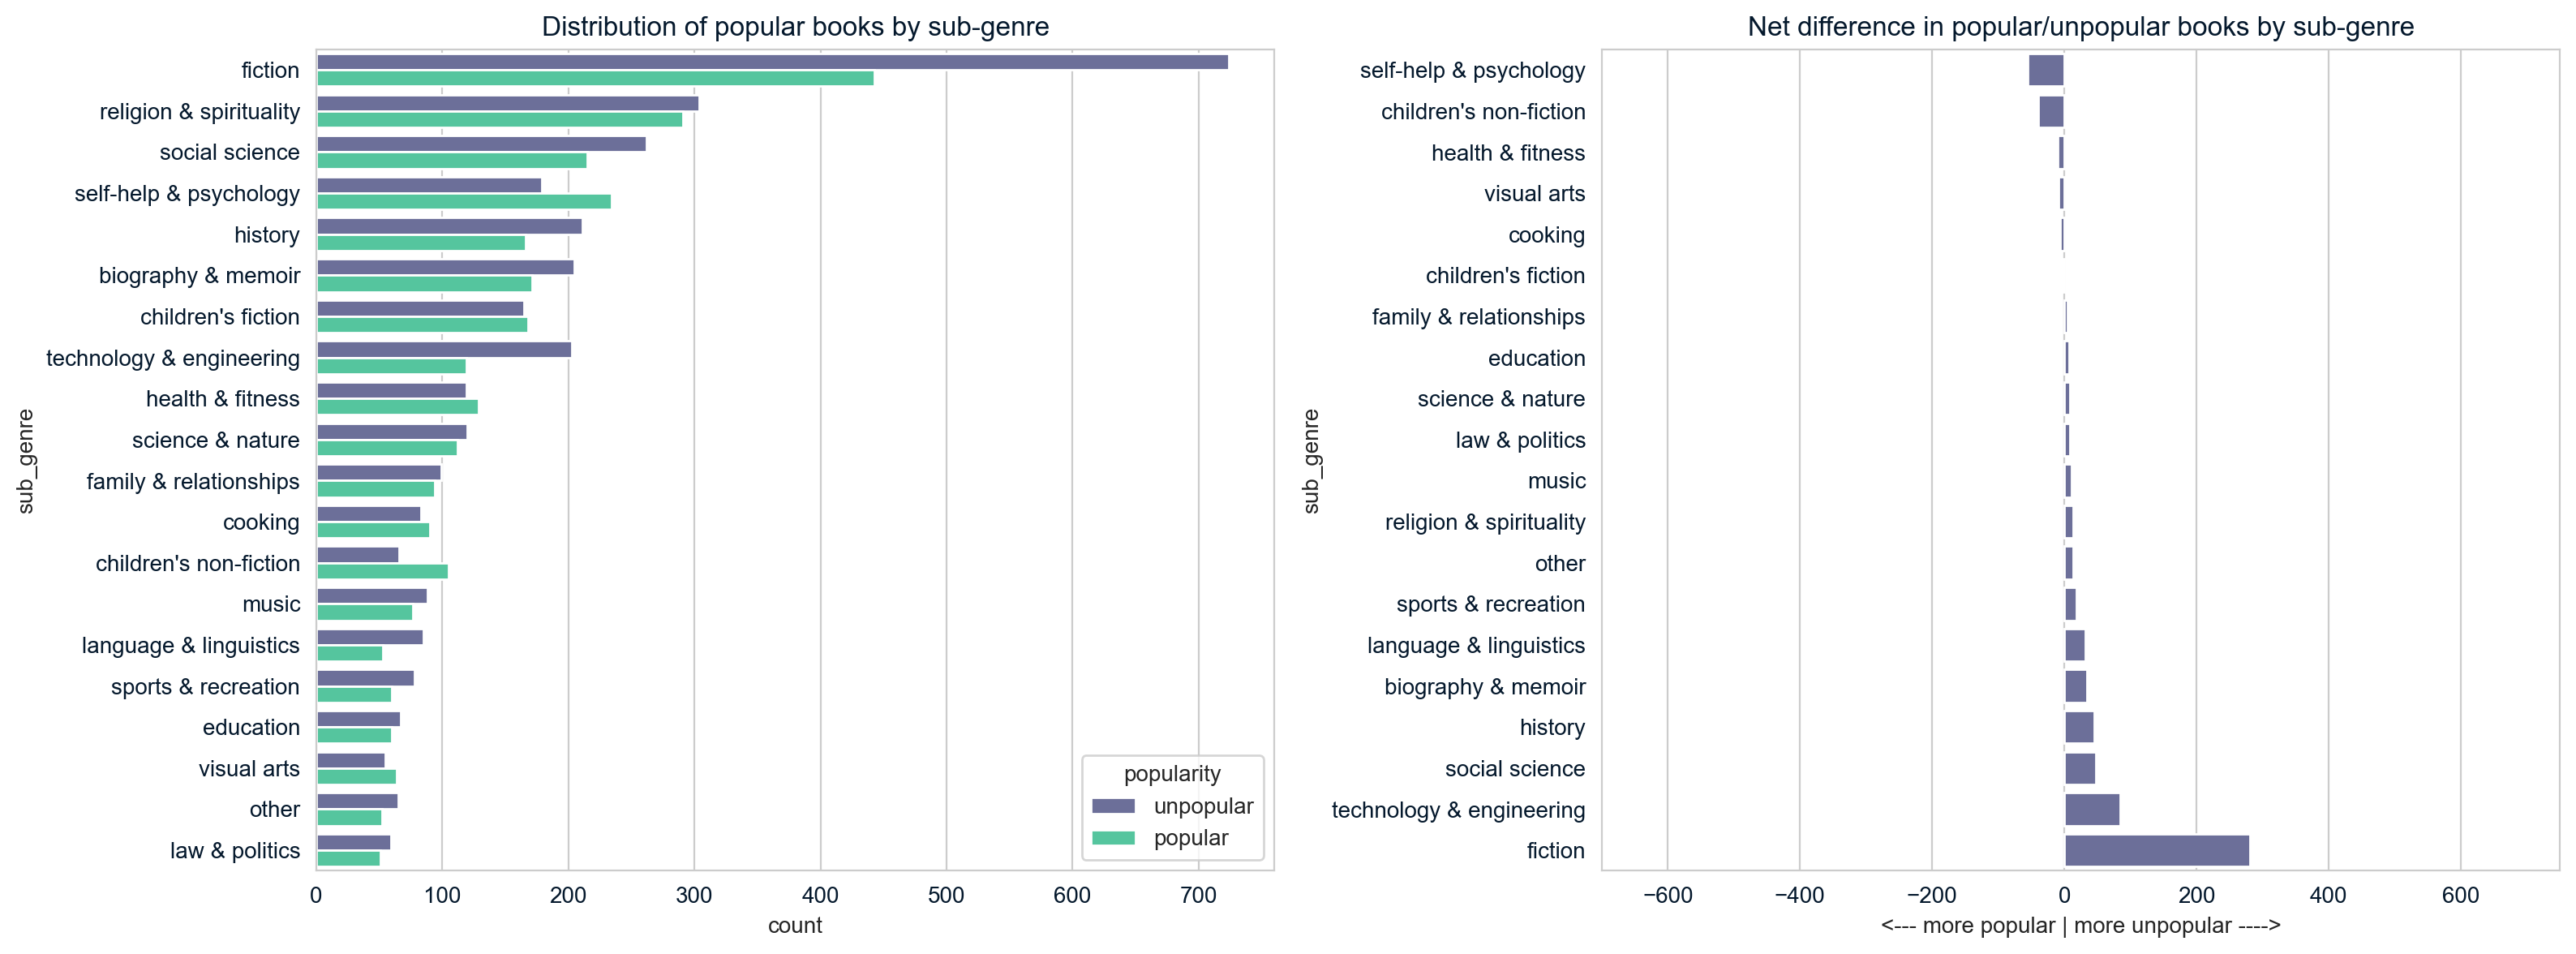

In [33]:
tmp = pop_df.copy()
threshold = 100

tmp = tmp.groupby(['sub_genre', 'popular'])['title'].count().reset_index()
tmp = pd.pivot_table(data = tmp, index = 'sub_genre', columns = 'popular', values = 'title').fillna(0)
#tmp.columns = ['unpopular', 'popular']
tmp.columns = [m.map_reverse_popular[c] for c in tmp.columns]
tmp = tmp.reset_index()
tmp['total'] = tmp['unpopular'] + tmp['popular']
tmp = tmp.sort_values(by = 'total', ascending = False)

tmp = tmp[tmp['total'] > threshold].reset_index(drop = True)

# Plot 1
tmp3 = tmp.copy()
total = tmp3['total'].sum()
tmp3 = tmp3.sort_values(by = 'total', ascending = False)
tmp3 = tmp3.drop('total', axis = 1)
tmp3 = pd.melt(tmp3, id_vars = 'sub_genre', value_vars=['unpopular', 'popular'], value_name='count')
tmp3.columns = ['sub_genre', 'popularity', 'count']

# Plot 2
tmp['diff'] = tmp['unpopular'] - tmp['popular']
tmp = tmp.sort_values(by = 'diff', ascending = True)

plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
plt.title("Distribution of popular books by sub-genre")
sns.barplot(data = tmp3, y = 'sub_genre', x = 'count', hue = 'popularity')

plt.subplot(1, 2, 2)
plt.title("Net difference in popular/unpopular books by sub-genre")
sns.barplot(data = tmp, y = 'sub_genre', x = 'diff')
plt.xlabel("<--- more popular | more unpopular ---->")
plt.xlim([-700, 750])

plt.tight_layout()

How about the popularity distribution in the remapped book sub-genre?

After remapping, we observe the following in the left chart:

- Fiction: The highest number of both popular and unpopular books. Unpopular books significantly outnumber popular ones.
- Religion & Spirituality: More unpopular books than popular ones by a narrow margin.
- Social Science: More unpopular books than popular ones.
- Self-Help & Psychology: A significant number of popular books compared to unpopular ones.
- History and Biography & Memoir: A less-balanced distribution, with more unpopular books.
- Children's Fiction: A balanced distribution.
- Technology & Engineering: Second highest net difference in unpopular book count.
- Health & Fitness, Science & Nature: These sub-genres display a relative balance.
- Family & Relationships, Cooking, Children's Non-Fiction, Music: These sub-genres also display a balanced distribution.
- Sub-genres with fewer books (e.g., Language & Linguistics, Sports & Recreation, Education, Visual Arts, Other, Law & Politics): A balanced distribution, but a slight inclination towards more unpopular books.

From the right chart, we observe:

- Fiction: The highest positive net difference (~300 books), indicating many more unpopular fiction books than popular ones.
- Technology & Engineering: A significant positive net difference, indicating more unpopular books.
- Social Science, History, Biography & Memoir: Positive net differences, indicating more unpopular books.
- Language & Linguistics, Sports & Recreation, Education: Slight positive net differences.
- Children's Non-fiction: Negative net difference, indicating more popular books.
- Self-Help & Psychology: Negative net difference, indicating more popular books.

## Feature Engineering: Price

How should we interpret price for each of the book entries? 

In a minority of cases, there are books with multiple price values and the difference between the values is significant?

For instance, the book **Anyone But You** by Chelsea M. Cameron is listed as \$39.25 and \$18.96. Of the eight **Anyone But You** observations in the dataset, four observations list the price as the former and four other observations list the price as the latter. Which is the correct price?

In these instances, I simply apply the median rule here. For all book entries in the dataset, its price value will simply be the median of all its respective price observations. This means that Chelsea M. Cameron's book **Anyone But You** will be priced at \$29.10, the median of its two listed prices in the dataframe.

This rule affects only the following book entries below:

In [34]:
tmp = books.groupby(['title', 'authors'])['price'].unique().reset_index()
tmp.columns = ['title', 'authors', 'unique prices']
mask = tmp['unique prices'].apply(len) > 1
print("Sample of books with multiple price values")
tmp[mask].head(10)

Sample of books with multiple price values


,title,authors,unique prices
500,Angels in the Gloom (World War One Series),'Anne Perry',"[18.96, 28.08]"
518,Anyone But You,'Chelsea M. Cameron',"[18.96, 39.25]"
1351,Crossing: A Memoir,'Deirdre N. McCloskey',"[20.0, 28.0]"
1599,Dragon's Kin (Dragonriders of Pern Series),"'Anne McCaffrey', 'Todd J. McCaffrey'","[31.95, 39.25]"
1703,Eleventh Hour (FBI Thriller),'Catherine Coulter',"[38.95, 32.95]"
2204,Great Expectations,'Charles Dickens',"[22.95, 14.95]"
2845,Joseph Andrews,'Henry Fielding',"[29.95, 15.56]"
3012,Lie by Moonlight,'Amanda Quick',"[26.56, 29.95]"
3934,Pirate (Hawke Series),'Ted Bell',"[30.36, 39.95]"
4395,Saucer,'Stephen Coonts',"[7.99, 18.96]"


In [35]:
author_query = "'Chelsea M. Cameron'"
books[books['authors'] == author_query][['title','authors','price']].sort_values(by = "price", ascending = False)

,title,authors,price
1010,Anyone But You,'Chelsea M. Cameron',39.25
1013,Anyone But You,'Chelsea M. Cameron',39.25
1014,Anyone But You,'Chelsea M. Cameron',39.25
1016,Anyone But You,'Chelsea M. Cameron',39.25
1009,Anyone But You,'Chelsea M. Cameron',18.96
1011,Anyone But You,'Chelsea M. Cameron',18.96
1012,Anyone But You,'Chelsea M. Cameron',18.96
1015,Anyone But You,'Chelsea M. Cameron',18.96


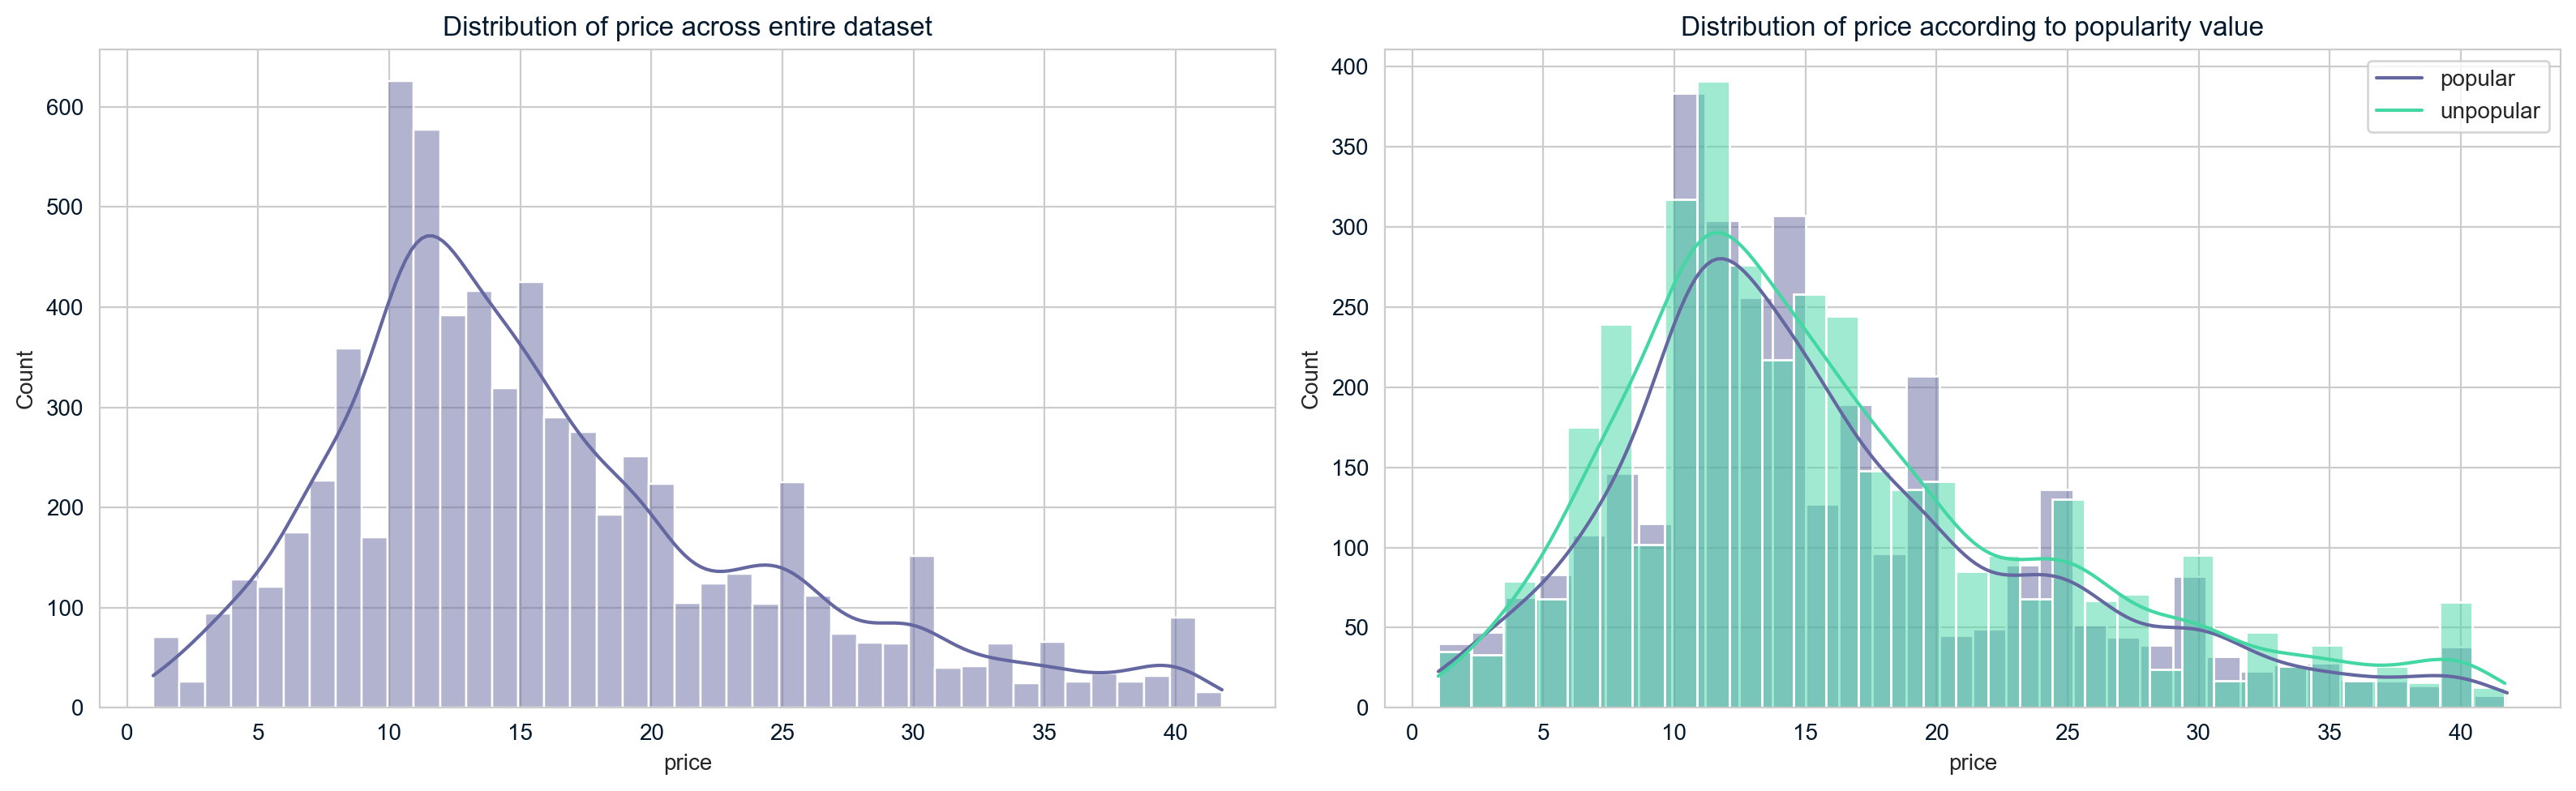

In [36]:
# get median price data
price_df = books.copy()

# add authors foreign key
price_df = ac.clean_authors(price_df)
price_df['authors_fk'] = price_df['authors_list'].apply(lambda x: "".join(x))
price_df = price_df.drop('authors_list', axis = 1)

# add title foreign key
price_df['title_fk'] = price_df['title'].apply(tc.clean_text)

price_df['fk'] = price_df['authors_fk'] + price_df['title_fk']
price_df = price_df.drop(['title_fk', 'authors_fk'], axis = 1)

# decouple the price values
price_df = price_df.groupby(['fk'])['price'].median().reset_index()


# merge the price values back onto the revised book dataframe
tmp = pd.merge(pop_df, price_df, on = 'fk')
tmp['popular'] = tmp['popular'].map(m.map_reverse_popular)

plt.figure(figsize = (16, 5))
plt.subplot(1, 2, 1)
sns.histplot(data = tmp, x = 'price', kde = True)
plt.title("Distribution of price across entire dataset")

plt.subplot(1, 2, 2)
grouped = tmp.groupby('popular')
for name, group in grouped:
    sns.histplot(group['price'], kde = True)
plt.title("Distribution of price according to popularity value")
plt.legend(['popular', 'unpopular'])
plt.tight_layout()

As you can see from the histograms above, the price value is centered at the mean (\$16), skewed right with a median of (\$14). The max value is \$41 and the lowest value is \$1. The distribution of price among popular and unpopular titles is quite similar.

Rather than preserve the numeric column price, I elected to convert this column into a categorical column by applying pandas qcut to the distribution. The column values are re-categorized according to their distribution block: either the lowest block for the cheapest books or highest block for the most expensive. I will use these categorical values to build the model later.

In [37]:
num_blocks = 8

#tmp = price_df.reset_index()
vals = pd.qcut(tmp['price'], num_blocks, labels = False)
#val_names = vals.value_counts().index

tmp['price_block'] = vals
tmp['price_block'] = tmp['price_block'].apply(lambda x: 'q' + str(x + 1))

# create finalized df
price_df_final = tmp.drop('price', axis = 1)
tmp1 = tmp.groupby('price_block')['price'].agg(["count", "min", "median", "max"]).reset_index().sort_values(by = 'price_block')
tmp1['range'] = tmp1['max'] - tmp1['min']
tmp1.set_index('price_block')

,count,min,median,max,range
price_block,,,,,
q1,1062,1.00,6.29,7.99,6.99
q2,688,8.00,9.95,10.36,2.36
q3,868,10.38,11.20,11.96,1.58
q4,897,11.97,12.99,14.00,2.03
q5,853,14.01,15.00,16.50,2.49
q6,885,16.55,18.19,19.95,3.40
q7,853,19.96,23.10,26.25,6.29
q8,873,26.32,31.43,41.77,15.45


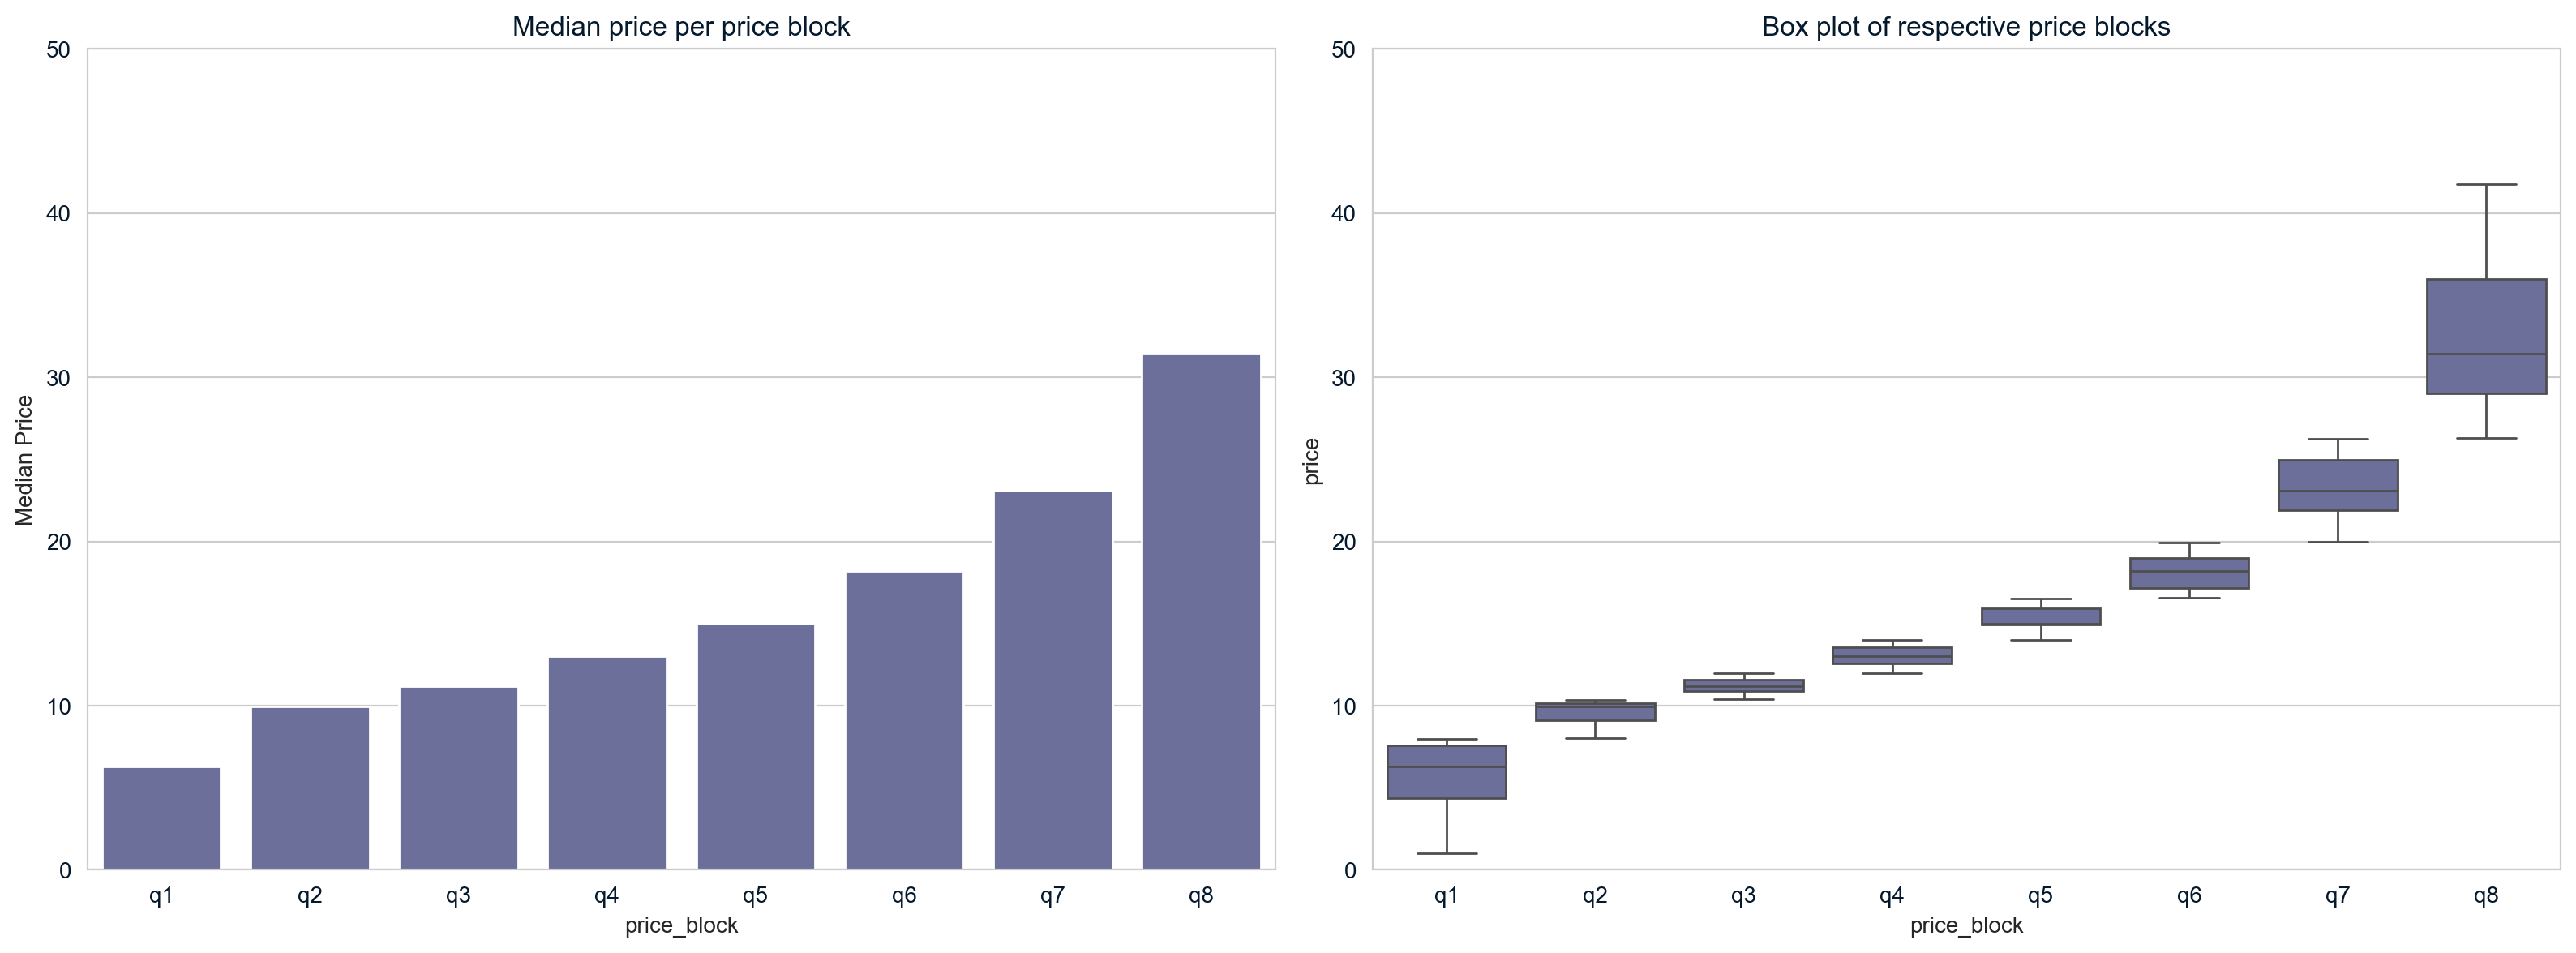

In [38]:
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.barplot(data = tmp1, x = 'price_block', y = 'median')
plt.title("Median price per price block")
plt.ylabel("Median Price")
plt.ylim([0, 50])

plt.subplot(1, 2, 2)
sns.boxplot(data = tmp, x = 'price_block', y = 'price', order=['q' + str(i) for i in range(1, num_blocks+1)])
plt.title("Box plot of respective price blocks")
plt.ylim([0, 50])
plt.tight_layout()

The chart on the left shows the media price per price_block category. As the price block increases from q1 to q8, the median price of books in such category increase. The chart on the right shows a box plot distribution of each price block, with the same median value visible as the central black line. The ranges of the lowest (q1) and highest (q8) price blocks are greatest.

In [39]:
author_query = "'Chelsea M. Cameron'"
tmp[tmp['authors'] == author_query][['title', 'authors', 'price', 'price_block']]

,title,authors,price,price_block
518,Anyone But You,'Chelsea M. Cameron',29.105,q8


As an aside, the book **Anyone But You** has been encoded in the price_block column as q8, the most expensive price block.

## Feature Engineering: Author

Besides the text column, this is one of the trickier columns to generate features from. Authors can appear individually or as part of a collective, as you can see from the example of Charlotte Brontë below. Her famous book **Jane Eyre** has two distinct entries. She was also an editor of **Agnes Grey** (written by her sister Anne Brontë) and is listed as one of its authors. 

Nevertheless there are a some helpful features that can be generated from this column. 

For instance, knowing that an author has authored another popular book in the dataset (**author_other_popular_book_count**) could help our model make predictions about the popularity of a specific book. Specifically a feature that indicates whether or not the author has multiple popular books (besides the book observation in question, because that would contaminate the judgment of our model).

In addition, a feature that measures the number of authors of a book may be a useful feature for our model.

In [40]:
author_query = "'Charlotte Brontë'"

books[books['authors'].apply(lambda x: author_query in x)][['title','authors','categories']].value_counts().reset_index()

,title,authors,categories,count
0,Jane Eyre (Large Print),"'Charlotte Brontë', 'Marc Cactus'",'Fiction',53
1,Jane Eyre (New Windmill),'Charlotte Brontë','Charity-schools',44
2,Agnes Grey (Barnes & Noble Classics Series),"'Charlotte Brontë', 'Emily Brontë', 'Anne Brontë'",'Fiction',5


In [41]:
c = Counter(pop_df['authors'])
tmp = pd.DataFrame.from_dict(c, orient = 'index').reset_index()
tmp.columns = ['authors', 'count']
tmp.sort_values(by = 'count', ascending = False).head()

,authors,count
143,'Stephanie Laurens',10
10,'Hal Leonard Publishing Corporation',8
1663,'Catherine Coulter',7
1069,'Nora Roberts',7
188,'William Shakespeare',7


In [42]:
pop_df = ac.clean_authors(pop_df)
pop_df[['title','authors', 'authors_list']].head()

,title,authors,authors_list
0,"""Cool Stuff"" They Should Teach in School: Crui...","'Kent Healy', 'Kyle Healy'","[kent healy, kyle healy]"
1,"""Happiness Is Not My Companion"": The Life of G...",'David M. Jordan',[david m. jordan]
2,"""Then Junior Said to Jeff. . ."": The Best NASC...","'Jim McLaurin', 'David Poole', 'Tom Gillispie'","[jim mclaurin, david poole, tom gillispie]"
3,'Filming of Gone With the Wind','Steve Wilson',[steve wilson]
4,.Hack//Legend of the Twilight Vol. 3,'Tatsuya Hamazaki',[tatsuya hamazaki]


In [43]:
# author mapping part 1
map_authors = ac.create_author_mapping(pop_df)
pop_df = ac.perform_author_mapping(pop_df, map_authors)
#pop_df[['title','authors','authors_list','author_total_book_count']].sort_values(by = "author_total_book_count", ascending = False).head()

author_query = "charlotte brontë"
#author_query = "stephanie laurens"
pop_df[pop_df['authors_list'].apply(lambda x: author_query in x)][['title','authors','popular','genre','sub_genre', 'author_total_book_count']].sort_values(by = ['popular', 'title'])

created author mapping
created author book count


,title,authors,popular,genre,sub_genre,author_total_book_count
379,Agnes Grey,"'Charlotte Brontë', 'Emily Brontë', 'Anne Brontë'",0,literature & fiction,fiction,3
2781,Jane Eyre,"'Charlotte Brontë', 'Marc Cactus'",1,literature & fiction,fiction,3
2782,Jane Eyre,'Charlotte Brontë',1,literature & fiction,fiction,3


In [44]:
# author mapping part 2
author_list = ac.create_unique_author_list(pop_df)
author_popular_map = ac.create_author_popular_map(pop_df, author_list)
pop_df = ac.count_total_popular(pop_df, author_popular_map)

pop_df['total_authors'] = pop_df['authors_list'].apply(len)

# check query
#author_query = "stephanie laurens"
pop_df[pop_df['authors_list'].apply(lambda x: author_query in x)][['title','authors','popular','genre','sub_genre', 'author_total_book_count', 'total_popular_book_count', 'author_other_popular_book_count', 'total_authors', 'book_title_length']].sort_values(by = ['popular', 'title'])

,title,authors,popular,genre,sub_genre,author_total_book_count,total_popular_book_count,author_other_popular_book_count,total_authors,book_title_length
379,Agnes Grey,"'Charlotte Brontë', 'Emily Brontë', 'Anne Brontë'",0,literature & fiction,fiction,3,2,1,3,10
2781,Jane Eyre,"'Charlotte Brontë', 'Marc Cactus'",1,literature & fiction,fiction,3,2,1,2,9
2782,Jane Eyre,'Charlotte Brontë',1,literature & fiction,fiction,3,2,1,1,9


### A Bayesian Perspective to Author Feature Engineering

Bayesian statistics involves updating the probability of a hypothesis based on new evidence. In this case, probability of a respective book's popularity is affected by the author's history of having other popular books.

From our perspective, we would like to hypothesize whether a book by a certain author is popular. The new evidence is whether the author has other popular books.

We can use the dataset to calculate the components of Bayes' formula to observe how our posterior probability that a book is popular shifts based on our knowledge that the author has written other popular books.

- Prior Probability Prob(book is popular): The overall probability that any given book is popular without considering the author's history. This equals 46.1%.
- Marginal Likelihood Prob(author has other popular book(s)): The overall probability that an author has other popular books in the dataframe. This equals 6.3%.
- Likelihood Prob(author has other popular book(s) | book is popular): The probability that an author has other popular books given that a book is popular. This equals 11.1%

Posterior Probability Prob(book is popular | author has other popular book(s)): The probability that a book is popular given that the author has other popular books. We solve for this with the above three inputs. 46.1% * 11.1% / 6.3% = 81.5%

By contrast:
Prob(book is popular | author has no other popular books): The probability that a book is popular given that the author has no other popular books, which is 43.7%.

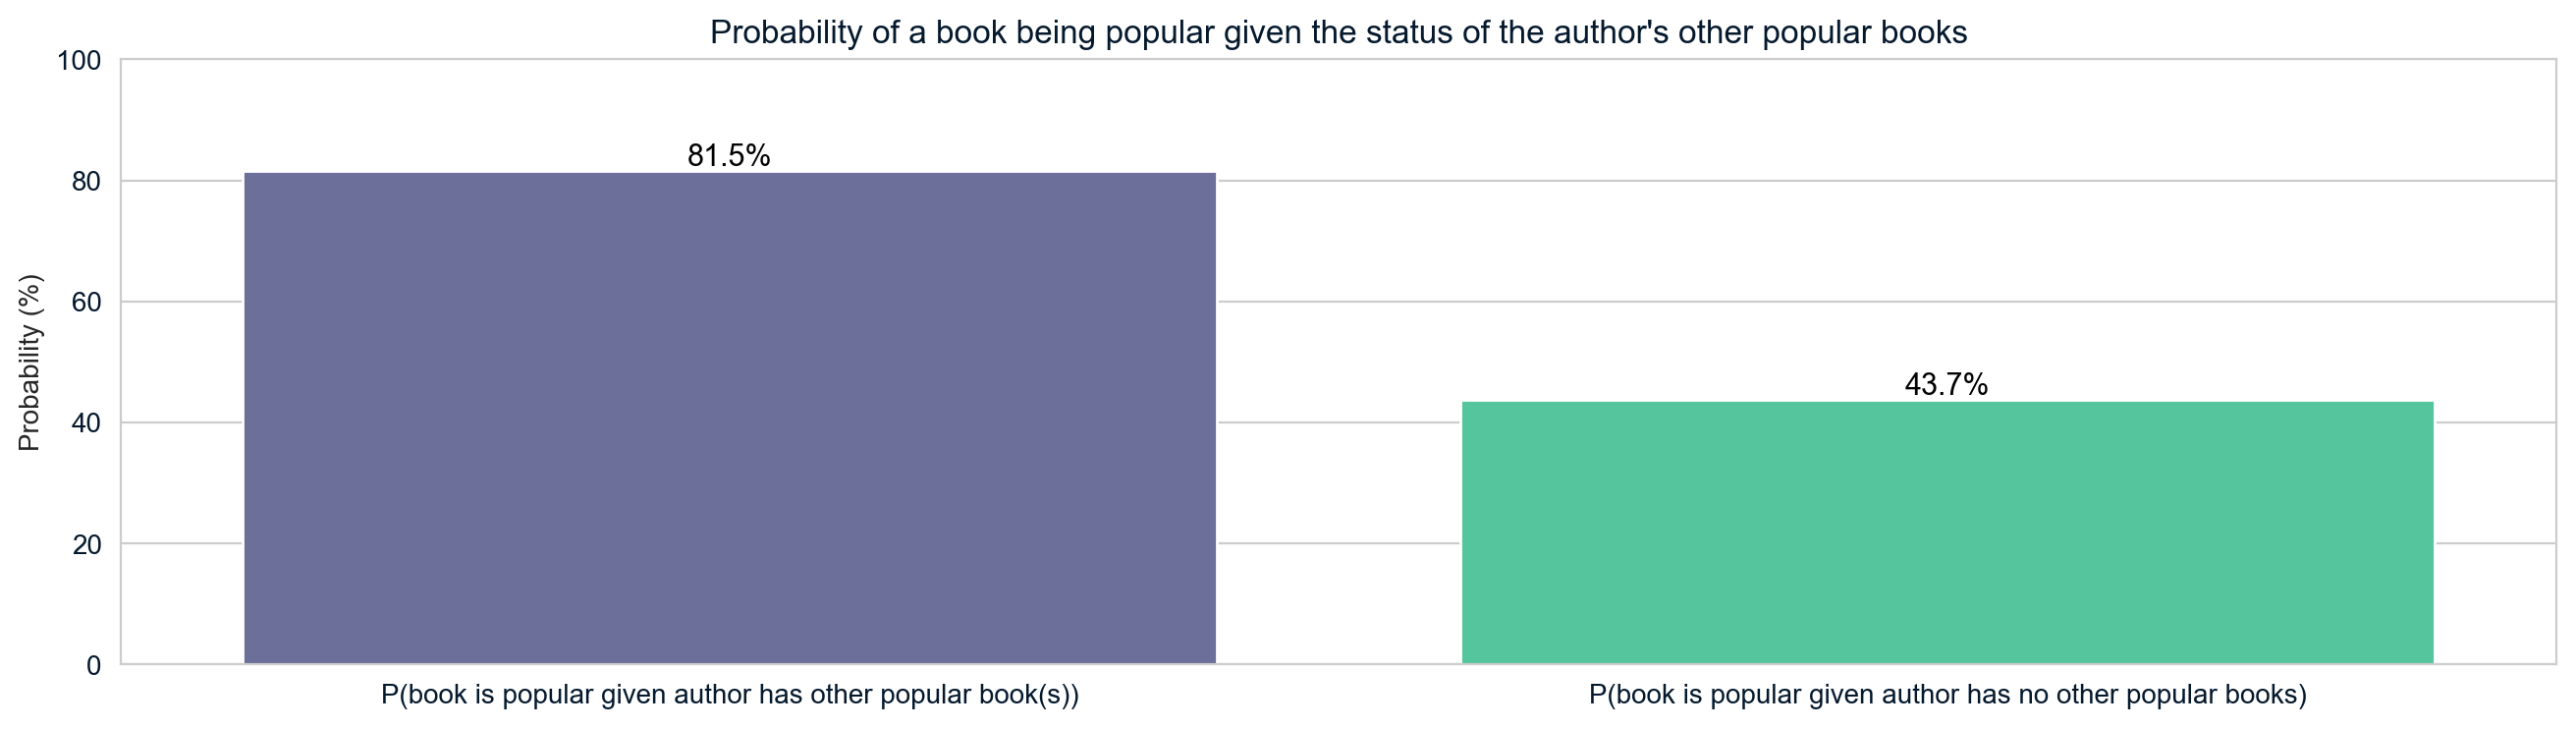

In [45]:
tmp = pop_df.copy()
tmp['has_popular_book'] = tmp['author_other_popular_book_count'].apply(lambda x: 1 if x > 0 else 0)
tmp = tmp[['popular', 'has_popular_book']]

p_is_popular = tmp['popular'].mean()
p_is_not_popular = 1 - p_is_popular

p_other_popular_book = tmp['has_popular_book'].mean()
p_not_other_popular_book = 1 - p_other_popular_book

p_other_popular_book_given_popular = tmp[tmp['popular'] == 1]['has_popular_book'].mean()

p_popular_given_other_popular_book = p_other_popular_book_given_popular * p_is_popular / p_other_popular_book
p_not_other_popular_given_popular = 1 - p_other_popular_book_given_popular
p_popular_given_not_other_popular = p_not_other_popular_given_popular * p_is_popular / p_not_other_popular_book

tmp = pd.DataFrame([
    {
        'P(book is popular given author has other popular book(s))': round(p_popular_given_other_popular_book * 100, 1),
        'P(book is popular given author has no other popular books)': round(p_popular_given_not_other_popular * 100, 1)
    }
])

plt.figure(figsize = (16, 4))
plt.title("Probability of a book being popular given the status of the author's other popular books")
plt.ylabel("Probability (%)")
plt.ylim([0, 100])
sns.barplot(tmp)

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.show()

From this information we can revise our understanding of the following:
- When an author has other popular books, the probability that another book by this author will be popular is quite high (81.5%). This suggests a strong relationship between an author's history of popular books and the success of another book by the same author.
- When an author does not have any other popular books, the probability of their other book being popular is close to the prior probability for the datset.

This newly created feature **author_other_popular_book_count** will prove useful for the machine learning algorithm to distill patterns in our training set.

## Feature Engineering: Book Description

The goal of this next step is to clean the book description text and extract the text sentiment using the TextBlob library. According to my subjective definition, text sentiment polarity less than -0.2 is categorized as 'Negative' sentiment, text sentiment polarity between -0.2 and 0.2 is categorized as 'Neutral' sentiment, and text sentiment polarity greater than 0.2 is categorized as 'Positive' sentiment.

In [46]:
pop_df[['title','description']].head()

,title,description
0,"""Cool Stuff"" They Should Teach in School: Crui...",Offers advices to young people on such topics ...
1,"""Happiness Is Not My Companion"": The Life of G...",The valorous but troubled career of the Civil ...
2,"""Then Junior Said to Jeff. . ."": The Best NASC...",This collection of behind-the-scenes happening...
3,'Filming of Gone With the Wind',Companion publication to the Harry Ransom Cent...
4,.Hack//Legend of the Twilight Vol. 3,The complete three-volume adventure is collect...


In [47]:
pop_df = tc.clean_description_text(pop_df)
pop_df[['title','description', 'description_sentiment', 'desc_sentiment_type']].head()

,title,description,description_sentiment,desc_sentiment_type
0,"""Cool Stuff"" They Should Teach in School: Crui...",offer advices young people topics attitude peo...,0.066667,Neutral
1,"""Happiness Is Not My Companion"": The Life of G...",valorous trouble career civil war general best...,0.083068,Neutral
2,"""Then Junior Said to Jeff. . ."": The Best NASC...",collection behindthescenes happen history belo...,0.216667,Positive
3,'Filming of Gone With the Wind',companion publication harry ransom center exhi...,0.000000,Neutral
4,.Hack//Legend of the Twilight Vol. 3,complete threevolume adventure collect one volume,0.100000,Neutral


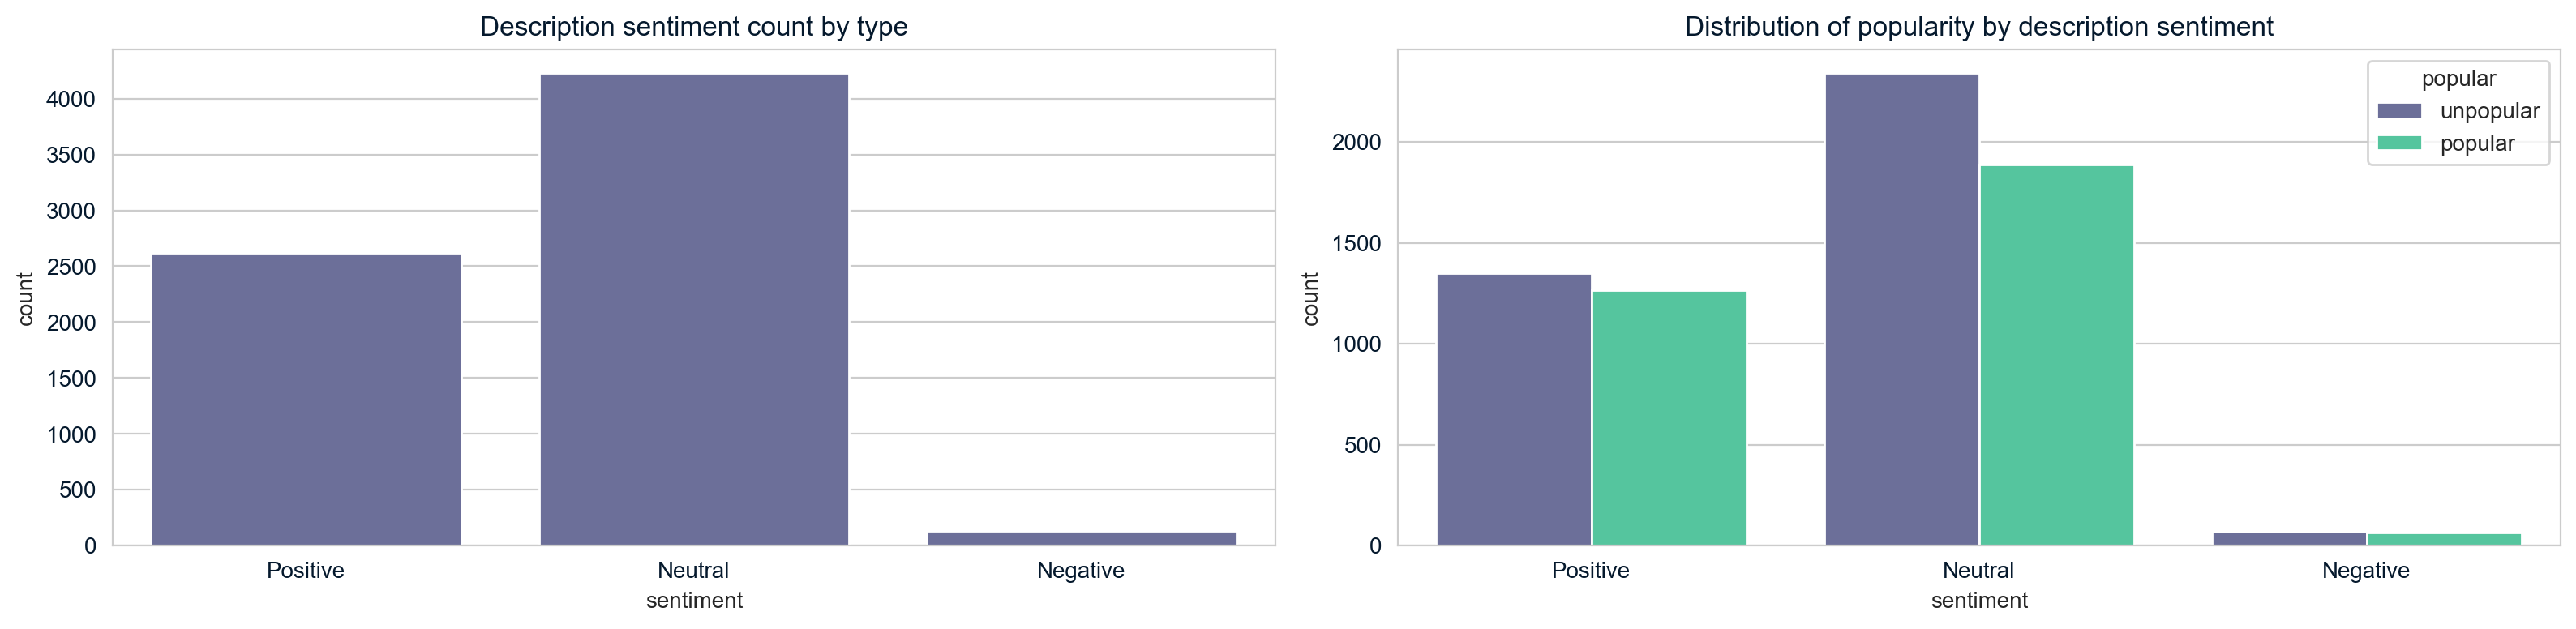

In [48]:
tmp = pop_df['desc_sentiment_type'].value_counts().reset_index()
tmp.columns = ['sentiment','count']
plt.figure(figsize = (16, 4))

plt.subplot(1, 2, 1)
sns.barplot(data = tmp, x = 'sentiment', y = 'count', order = ['Positive', 'Neutral', 'Negative'])
plt.title("Description sentiment count by type")


tmp = pop_df.groupby(["popular", 'desc_sentiment_type'])['title'].count().reset_index()
tmp['popular'] = tmp['popular'].map(m.map_reverse_popular)
tmp.columns = ['popular', 'sentiment', 'count']
plt.subplot(1, 2, 2)
plt.title("Distribution of popularity by description sentiment")
sns.barplot(data = tmp, x = 'sentiment', y = 'count', hue = 'popular', order = ['Positive', 'Neutral', 'Negative'])

desc_sent = tmp.copy()
plt.tight_layout()

In the above charts you can see the overall distribution of text sentiment for the book descriptions. Most entries are classified as neutral and few are categorized as positive. Among the neutral description titles, a majority of instances are unpopular books. Books with a Postive description sentiment are more equally balanced in terms of popularity.

## Feature Engineering: Review helpfulness

There is a column review/helpfulness that is poorly encoded as a string, when its values could be utilized by the model as numeric values. I parsed this feature and created four new features from it: reviews_helpful, total_reviews, reviews_not_helpful, and pct_reviews_helpful. Later, I drop the reviews_helpful and reviews_not_helpful count from the machine learning model to avoid redundancy.

### Separating Reviews

In [49]:
# create copy of books
review_df = books.copy()

# select review columns
review_df = review_df[['title','authors','review/summary','review/text','review/helpfulness']].sort_values(by = 'title')

original_shape = review_df.shape

# drop duplicates
review_df = review_df.drop_duplicates()

print(f"A total of {original_shape[0] - review_df.shape[0]} duplicate rows were dropped.")

# clean text
review_df = tc.clean_review_helpfulness(review_df)

# drop review/helpfulness
review_df = review_df.drop('review/helpfulness', axis = 1)

# add authors foreign key
review_df = ac.clean_authors(review_df)
review_df['authors_fk'] = review_df['authors_list'].apply(lambda x: "".join(x))
review_df = review_df.drop('authors_list', axis = 1)

# add title foreign key
review_df['title_fk'] = review_df['title'].apply(tc.clean_text)

review_df['fk'] = review_df['authors_fk'] + review_df['title_fk']
review_df = review_df.drop(['title_fk', 'authors_fk'], axis = 1)

# count how many distinct reviews
print(f"Now there are {review_df.shape[0]} rows.")

review_df.head()

A total of 4 duplicate rows were dropped.
Now there are 12420 rows.


,title,authors,review/summary,review/text,reviews_helpful,total_reviews,reviews_not_helpful,pct_reviews_helpful,fk
0,"""Cool Stuff"" They Should Teach in School: Crui...","'Kent Healy', 'Kyle Healy'",More style than substance,I bought this on the basis of the reviews. I t...,1.0,1.0,0.0,1.000000,kent healykyle healycool stuff teach school cr...
1,"""Happiness Is Not My Companion"": The Life of G...",'David M. Jordan',Solid Bio on Warren and the Controversy of Fiv...,"Solid bio on General Warren, like George Picke...",2.0,2.0,0.0,1.000000,david m. jordanhappiness companion life genera...
2,"""Then Junior Said to Jeff. . ."": The Best NASC...","'Jim McLaurin', 'David Poole', 'Tom Gillispie'",Great Stories!,"If you like NASCAR stories, facts, trivia, sta...",0.0,0.0,0.0,0.000000,jim mclaurindavid pooletom gillispiejunior say...
3,'Filming of Gone With the Wind','Steve Wilson',A Gone With The Fan's Dream book,This book is a dream come true for any GWTW fa...,20.0,23.0,3.0,0.869565,steve wilsonfilm go wind
4,.Hack//Legend of the Twilight Vol. 3,'Tatsuya Hamazaki',Exciting conclusion to the .hack manga series.,"I've been eagerly awaiting volume 3, the concl...",22.0,23.0,1.0,0.956522,tatsuya hamazakihacklegend twilight vol


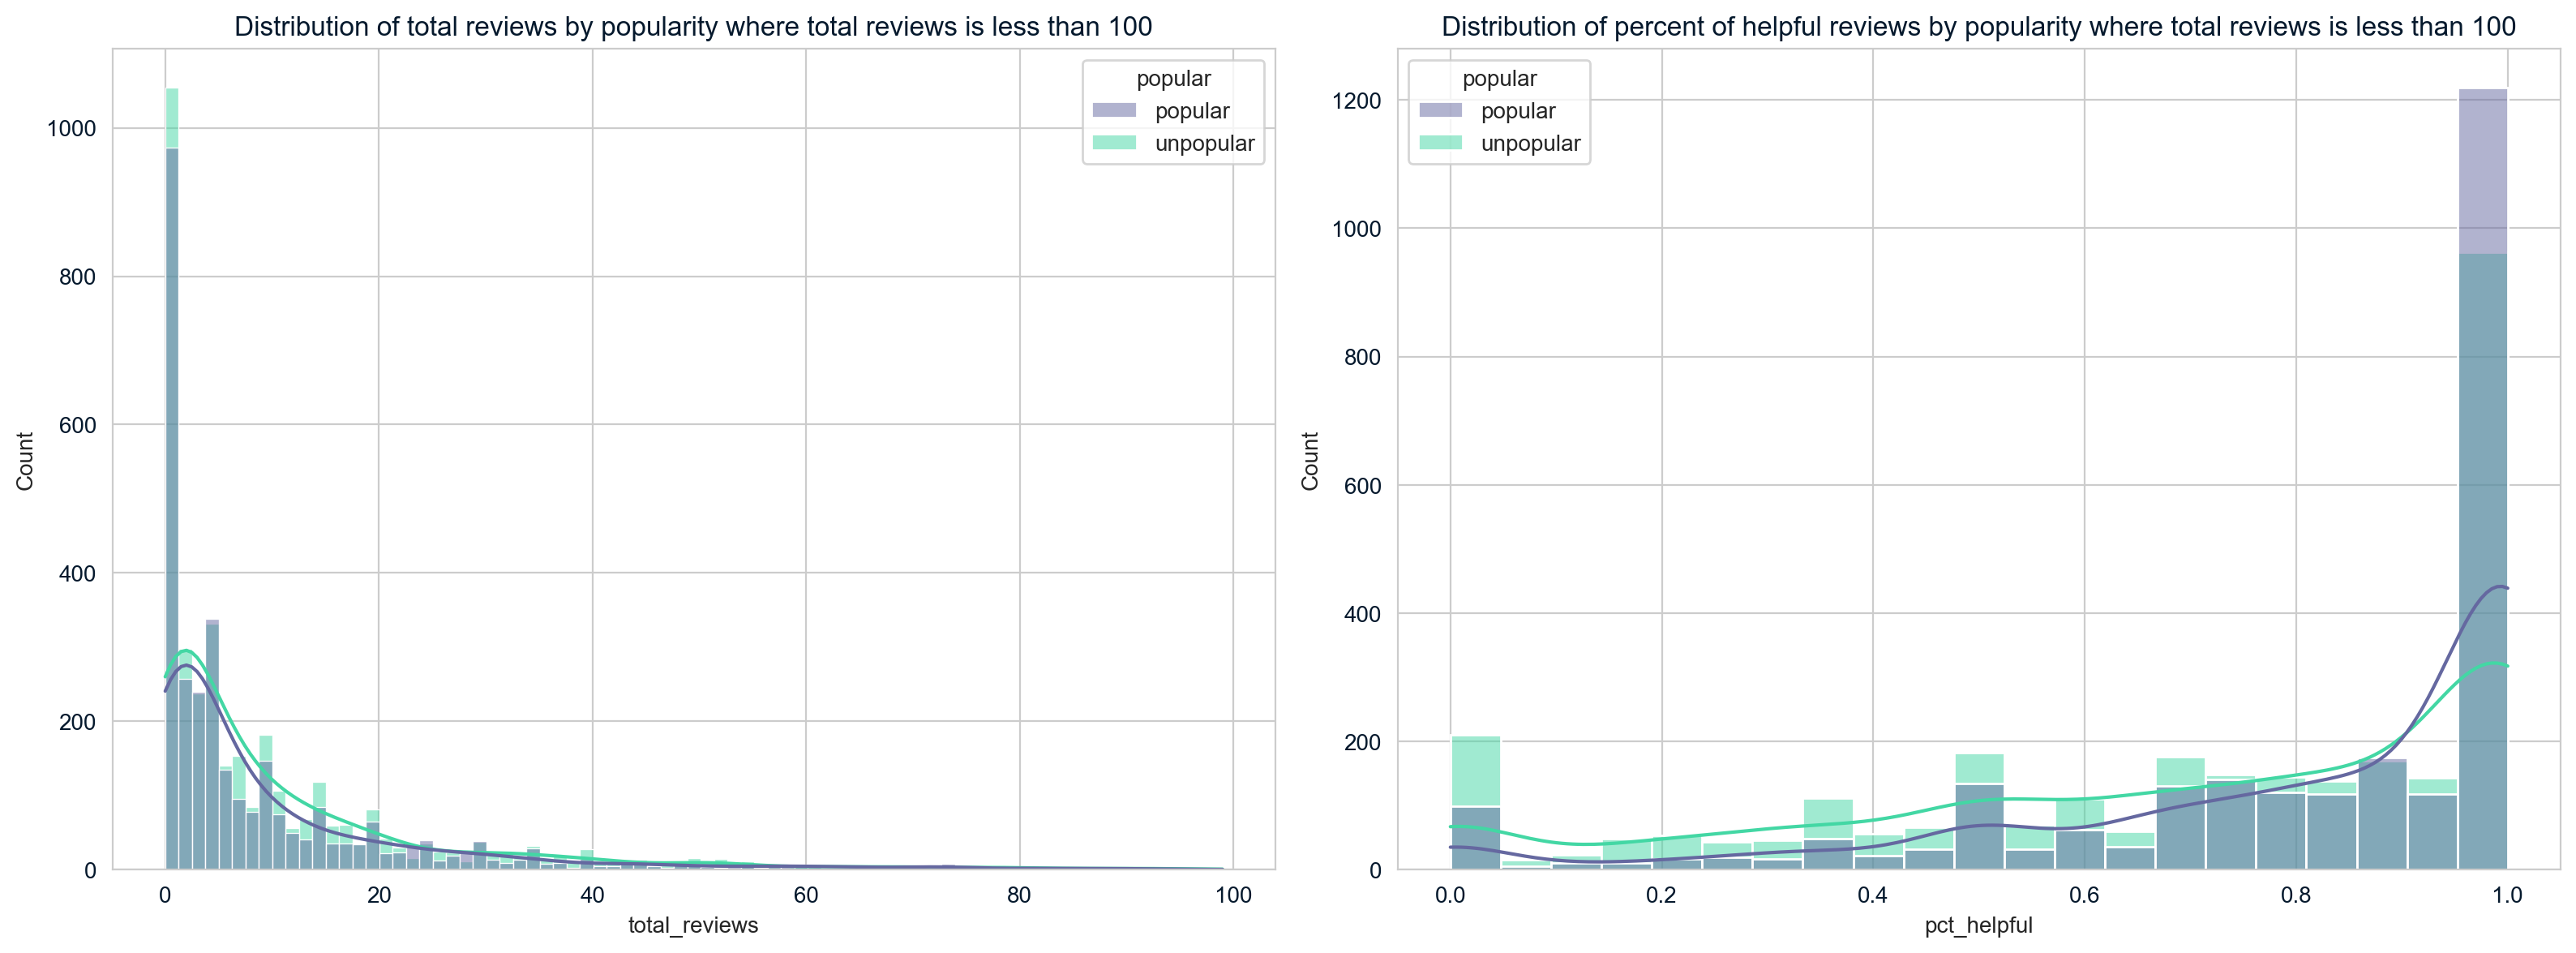

In [50]:
threshold = 100
tmp = pd.merge(review_df, pop_df[['fk','popular']], on = 'fk')
tmp1 = tmp.groupby('fk').agg({'total_reviews': 'sum', 'reviews_helpful': 'sum'}).reset_index()
tmp2 = pd.merge(pop_df, tmp1, on = 'fk')
tmp2['popular'] = tmp2['popular'].map(m.map_reverse_popular)
tmp2['pct_helpful'] = tmp2['reviews_helpful'] / tmp2['total_reviews']

mask1 = tmp2['total_reviews'] < threshold
tmp2 = tmp2[mask1]
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.histplot(data = tmp2, x = 'total_reviews', hue = 'popular', kde = True, hue_order=['popular','unpopular'])
plt.title(f"Distribution of total reviews by popularity where total reviews is less than {threshold}")

plt.subplot(1, 2, 2)
sns.histplot(data = tmp2, x = 'pct_helpful', hue = 'popular', kde = True, hue_order=['popular','unpopular'])
plt.title(f"Distribution of percent of helpful reviews by popularity where total reviews is less than {threshold}")
plt.tight_layout()

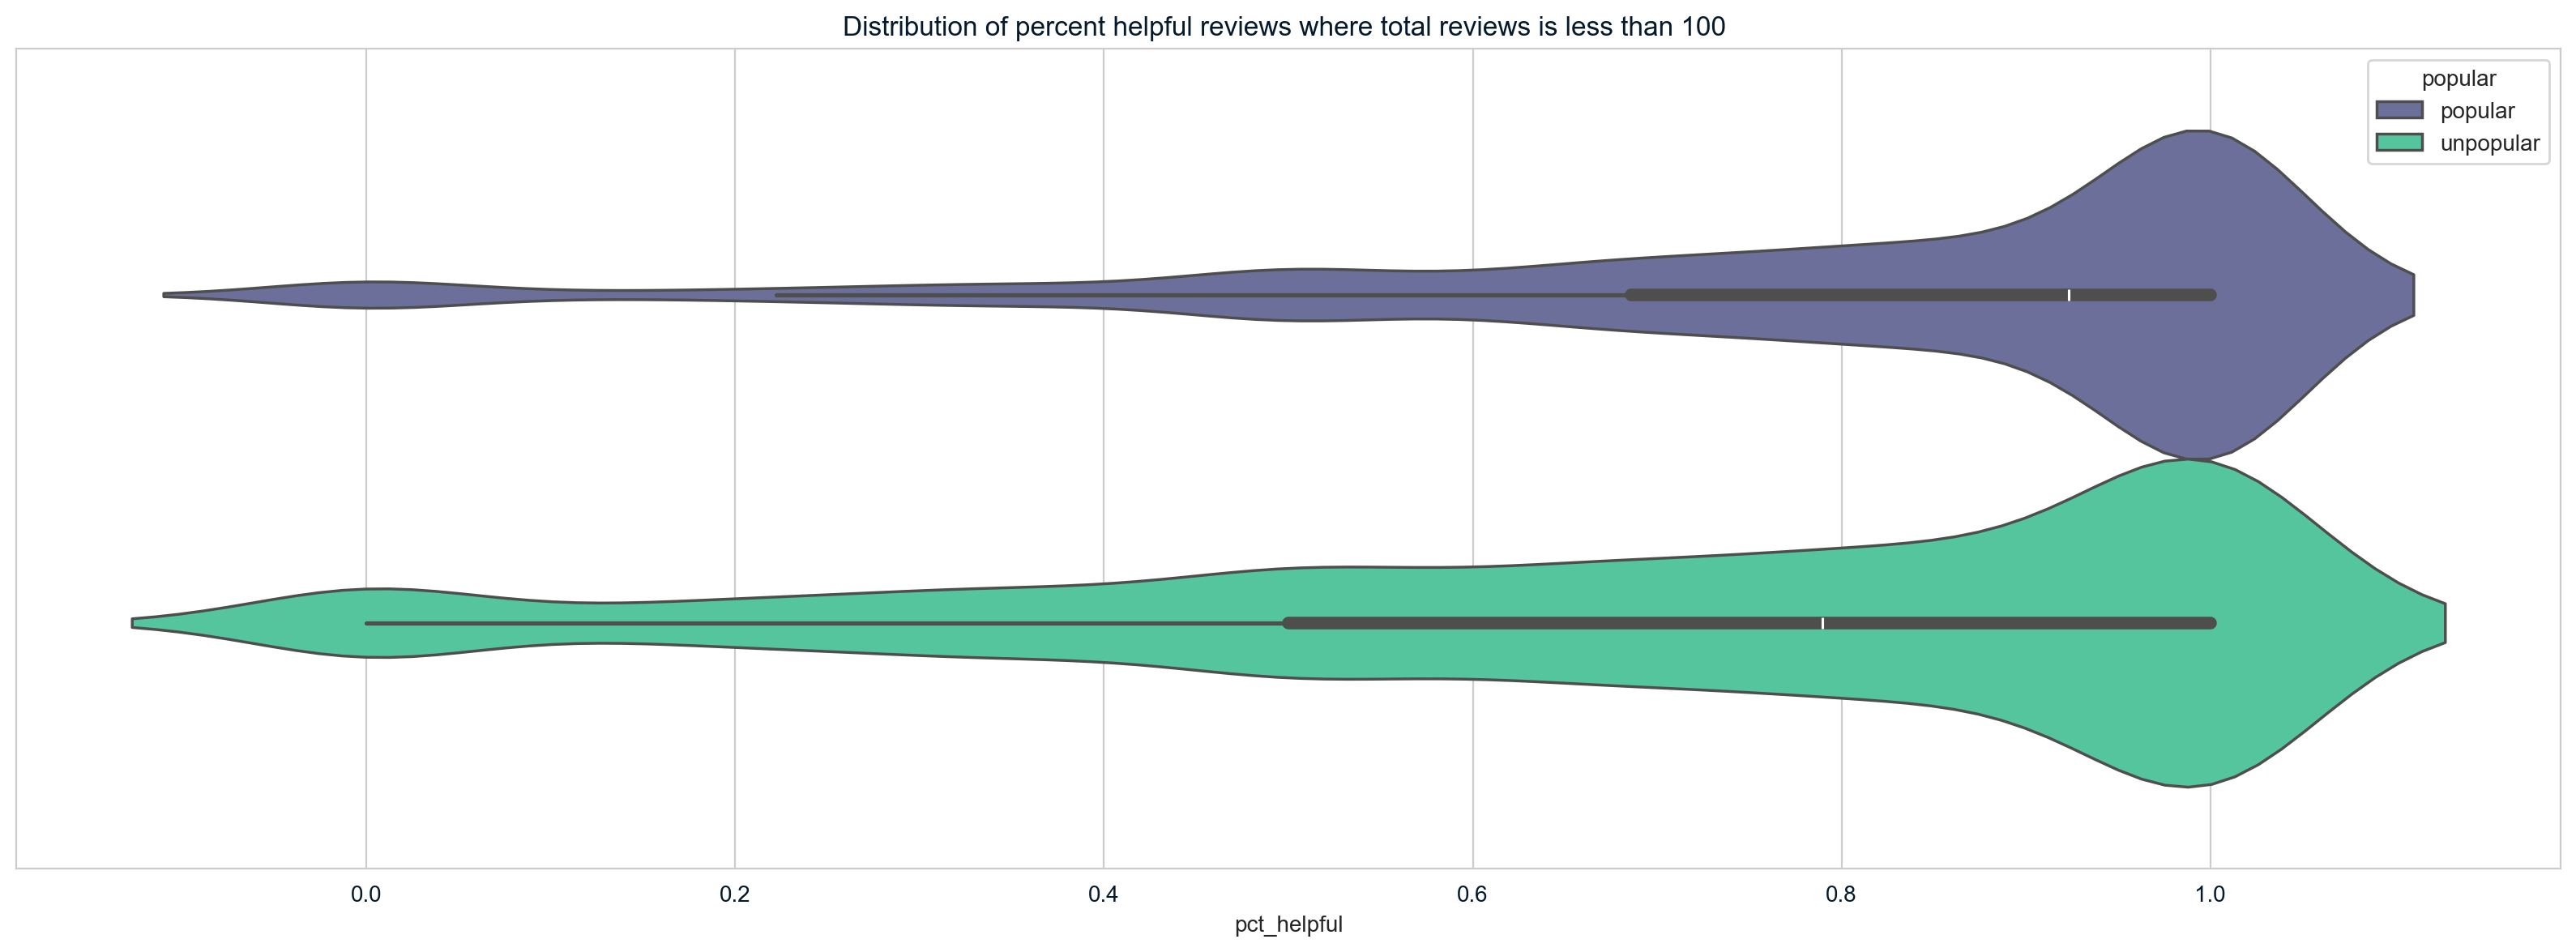

In [51]:
plt.figure(figsize = (16, 6))
sns.violinplot(data = tmp2, x = 'pct_helpful', hue = 'popular', hue_order=['popular','unpopular'])
plt.title(f"Distribution of percent helpful reviews where total reviews is less than 100 ")
plt.tight_layout()

The above chart reviews a distinct pattern in book popularity. For books with fewer than 100 reviews (which is the outright majority of books), popular books tend to have more helpful reviews on average. I notice that books with perfect helpfulness scores (pct_helpful = 100%) have more popular than unpopular book titles. The opposite is true for books with perfect 'unhelpfulness' score (pct_helpful = 0%).

## Feature Engineering: Review Text, Review Summary, and Description

Lastly, I must address the text data in the dataset. Both the description and the review information must be cleaned. The author information must be analyzed for additional feature engineering, and the sentiments of both the reviews and descriptions must be estimated and categorized.

### Review Text

In [52]:
print("original title and text")
review_df[['title','review/text']].head()

original title and text


,title,review/text
0,"""Cool Stuff"" They Should Teach in School: Crui...",I bought this on the basis of the reviews. I t...
1,"""Happiness Is Not My Companion"": The Life of G...","Solid bio on General Warren, like George Picke..."
2,"""Then Junior Said to Jeff. . ."": The Best NASC...","If you like NASCAR stories, facts, trivia, sta..."
3,'Filming of Gone With the Wind',This book is a dream come true for any GWTW fa...
4,.Hack//Legend of the Twilight Vol. 3,"I've been eagerly awaiting volume 3, the concl..."


In [53]:
review_df = tc.clean_review_text(review_df)

print(review_df.shape)
print("post-cleaning text and feature extracted")
review_df[['title','review_text', 'review_sentiment', 'review_sentiment_type']].head()

(12420, 11)
post-cleaning text and feature extracted


,title,review_text,review_sentiment,review_sentiment_type
0,"""Cool Stuff"" They Should Teach in School: Crui...",buy basis review think book pretty good conten...,0.475000,Positive
1,"""Happiness Is Not My Companion"": The Life of G...",solid bio general warren like george picket kn...,0.145134,Neutral
2,"""Then Junior Said to Jeff. . ."": The Best NASC...",like nascar stories facts trivia stats book au...,-0.500000,Negative
3,'Filming of Gone With the Wind',book dream come true gwtw fan lot picture movi...,0.372222,Positive
4,.Hack//Legend of the Twilight Vol. 3,ive eagerly await volume conclusion series sin...,0.164234,Neutral


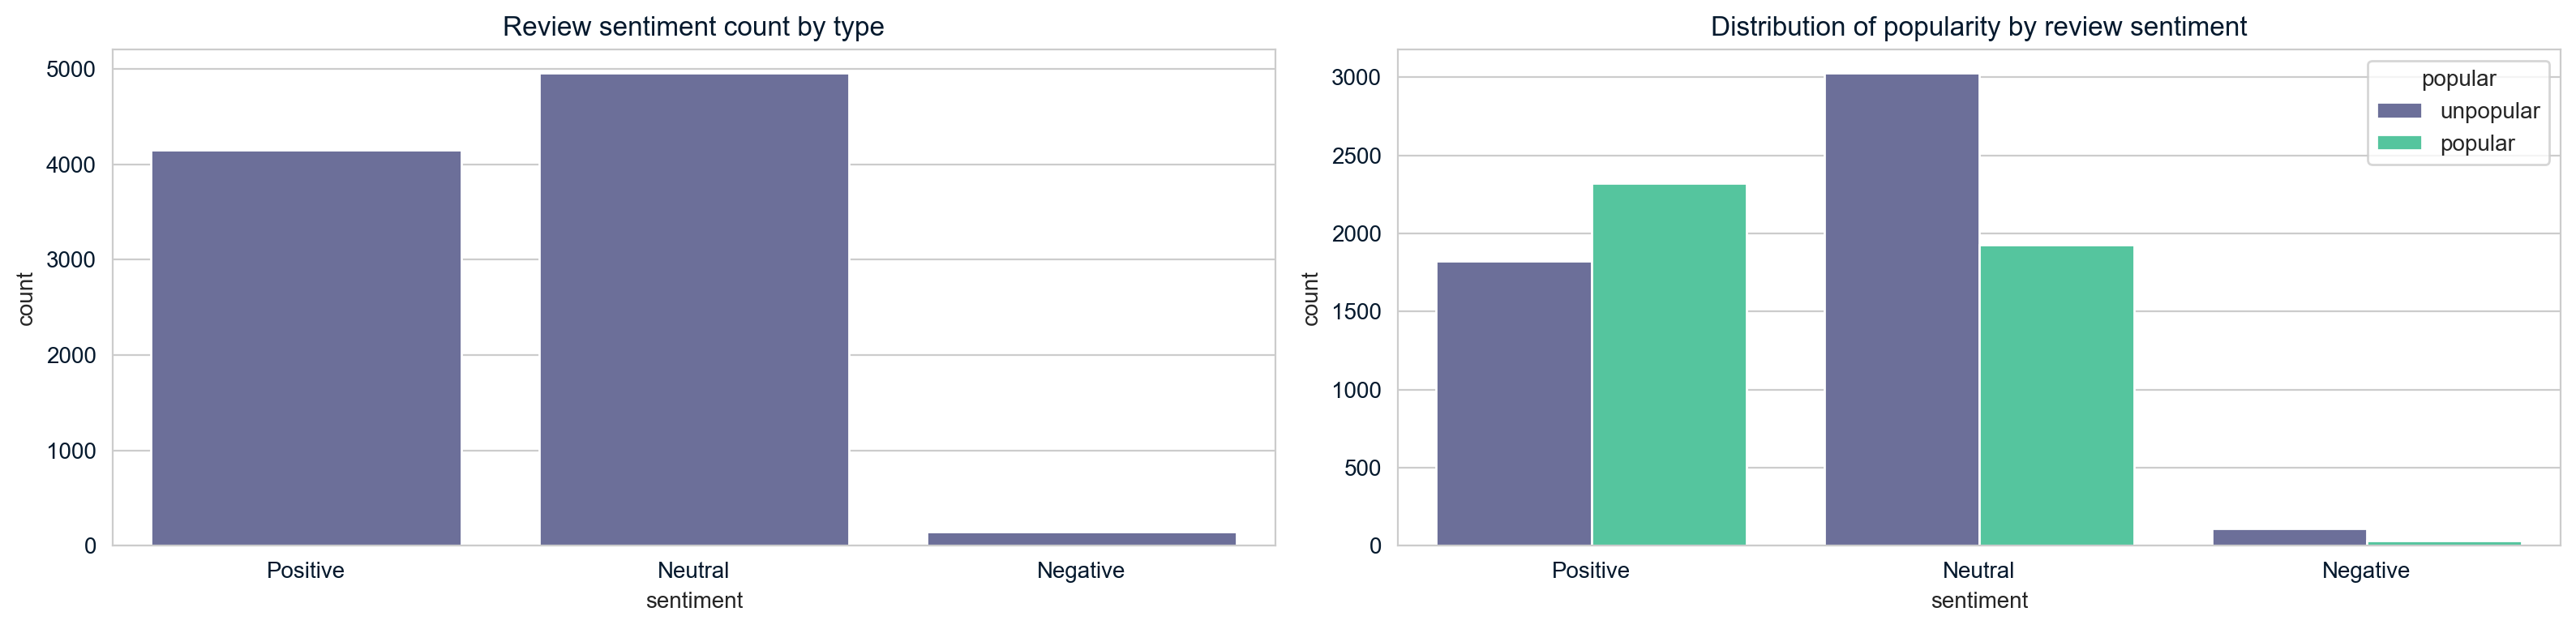

In [54]:
plt.figure(figsize = (16, 4))

# add popularity
tmp = pd.merge(review_df, pop_df[['title', 'authors', 'popular']], on = ['title', 'authors'])

# Plot 1
plt.subplot(1, 2, 1)
tmp1 = tmp['review_sentiment_type'].value_counts().reset_index()
tmp1.columns = ['sentiment','count']
sns.barplot(data = tmp1, x = 'sentiment', y = 'count', order = ['Positive', 'Neutral', 'Negative'])
plt.title("Review sentiment count by type")

# Plot 2
plt.subplot(1, 2, 2)
tmp2 = tmp.groupby(["popular", 'review_sentiment_type'])['title'].count().reset_index()
tmp2['popular'] = tmp2['popular'].map(m.map_reverse_popular)
tmp2.columns = ['popular', 'sentiment', 'count']
sns.barplot(data = tmp2, x = 'sentiment', y = 'count', hue = 'popular', order = ['Positive', 'Neutral', 'Negative'])
plt.title("Distribution of popularity by review sentiment")

review_sent = tmp2.copy()

plt.tight_layout()

The above charts suggest that most reviews are neutral or positive, with neutral reviews being the most frequent. Popularity does not seem strongly correlated with review sentiment, as both popular and unpopular books are distributed across all sentiment categories, albeit with some variance.

In the left chart, Neutral sentiment reviews are the most common, with a count slightly exceeding 5,000. Positive sentiment reviews follow, with a count close to 4,500. Negative sentiment reviews are significantly less common, with a count close to 100.

In the right chart, For Positive sentiment reviews, a notable portion of books are classified as popular, but a slightly larger count is classified as unpopular. Neutral sentiment reviews show a high count of both popular and unpopular books, with popular books being more numerous. For Negative sentiment reviews, both popular and unpopular books are fewer in count, with unpopular books slightly more prevalent.

### Review Summary

In [55]:
print("original")
review_df[['title','authors', 'review/summary']].head()

original


,title,authors,review/summary
0,"""Cool Stuff"" They Should Teach in School: Crui...","'Kent Healy', 'Kyle Healy'",More style than substance
1,"""Happiness Is Not My Companion"": The Life of G...",'David M. Jordan',Solid Bio on Warren and the Controversy of Fiv...
2,"""Then Junior Said to Jeff. . ."": The Best NASC...","'Jim McLaurin', 'David Poole', 'Tom Gillispie'",Great Stories!
3,'Filming of Gone With the Wind','Steve Wilson',A Gone With The Fan's Dream book
4,.Hack//Legend of the Twilight Vol. 3,'Tatsuya Hamazaki',Exciting conclusion to the .hack manga series.


In [56]:
review_df = tc.clean_review_summary_text(review_df)

print(review_df.shape)
print("after cleaning")
review_df[['title','review_summary', 'review_summary_sentiment', 'review_summary_sentiment_type']].head()

(12420, 13)
after cleaning


,title,review_summary,review_summary_sentiment,review_summary_sentiment_type
0,"""Cool Stuff"" They Should Teach in School: Crui...",style substance,0.5,Positive
1,"""Happiness Is Not My Companion"": The Life of G...",solid bio warren controversy five fork,0.0,Neutral
2,"""Then Junior Said to Jeff. . ."": The Best NASC...",great stories,0.8,Positive
3,'Filming of Gone With the Wind',go fan dream book,0.0,Neutral
4,.Hack//Legend of the Twilight Vol. 3,excite conclusion hack manga series,0.3,Positive


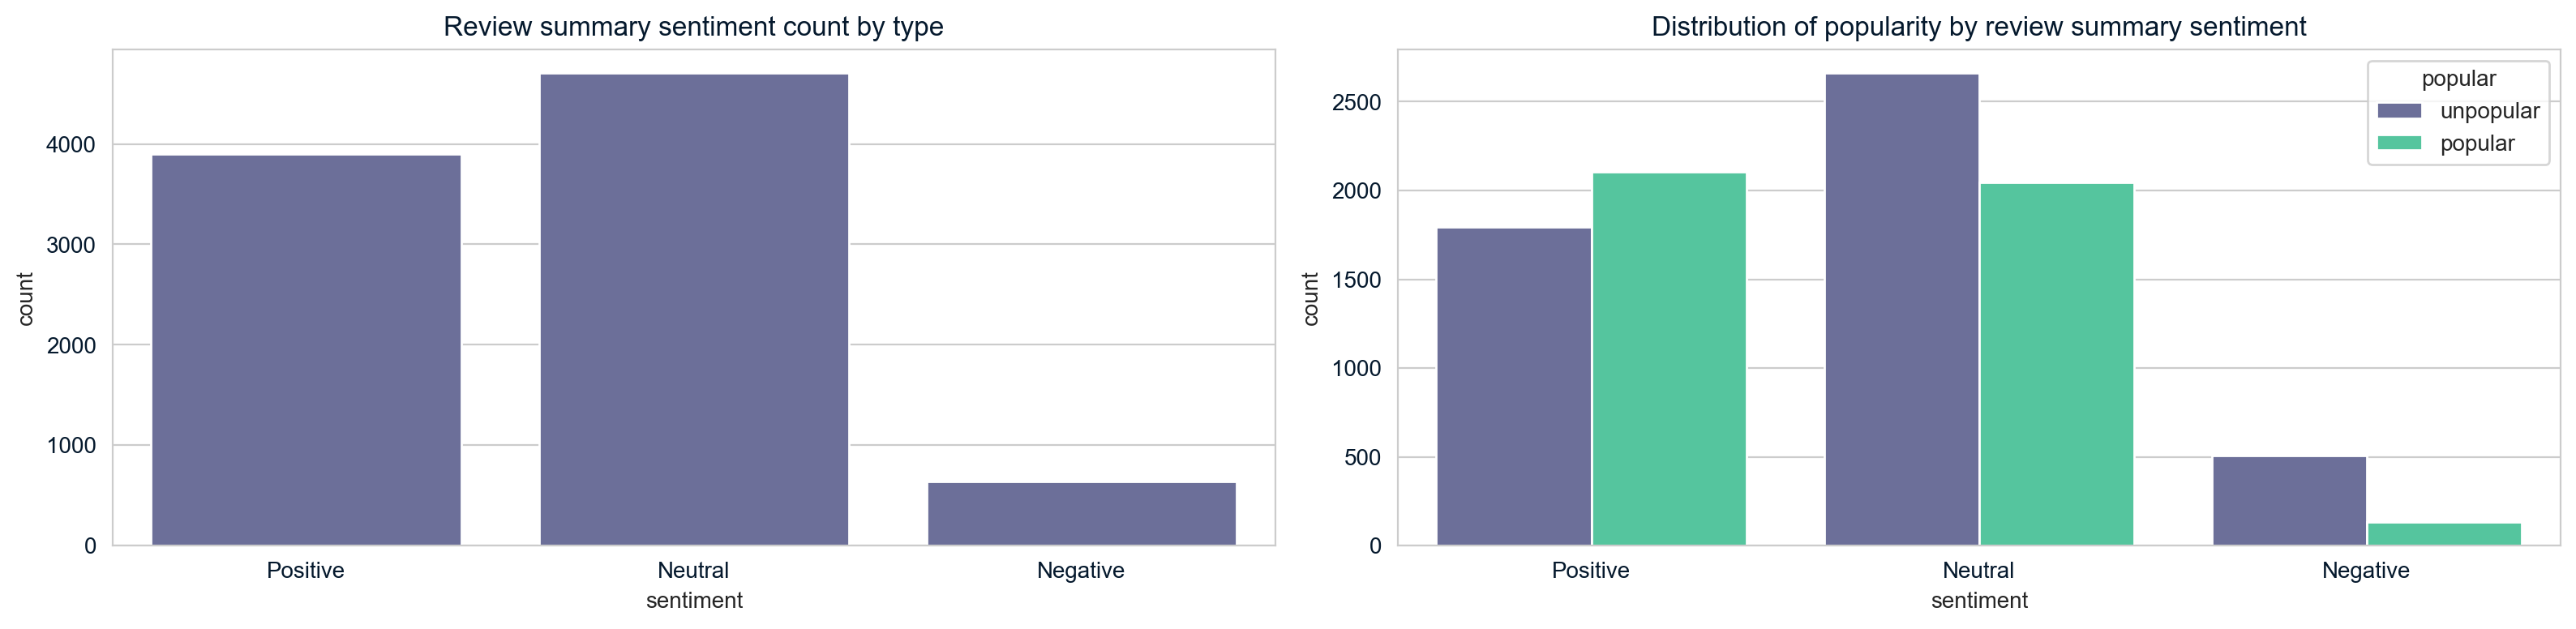

In [57]:
plt.figure(figsize = (16, 4))

# add popularity
tmp = pd.merge(review_df, pop_df[['title', 'authors', 'popular']], on = ['title', 'authors'])

# Plot 1
plt.subplot(1, 2, 1)
tmp1 = tmp['review_summary_sentiment_type'].value_counts().reset_index()
tmp1.columns = ['sentiment','count']
sns.barplot(data = tmp1, x = 'sentiment', y = 'count', order = ['Positive', 'Neutral', 'Negative'])
plt.title("Review summary sentiment count by type")

# Plot 2
plt.subplot(1, 2, 2)
tmp2 = tmp.groupby(["popular", 'review_summary_sentiment_type'])['title'].count().reset_index()
tmp2['popular'] = tmp2['popular'].map(m.map_reverse_popular)
tmp2.columns = ['popular', 'sentiment', 'count']
sns.barplot(data = tmp2, x = 'sentiment', y = 'count', hue = 'popular', order = ['Positive', 'Neutral', 'Negative'])
plt.title("Distribution of popularity by review summary sentiment")

review_summary_sent = tmp2.copy()

plt.tight_layout()

These charts suggest that neutral sentiments dominate review summaries, and popularity does not seem to correlate strongly with any specific sentiment type. However, there are more popular books associated with positive sentiments, while neutral sentiments have a higher count of both popular and unpopular books. Negative sentiment summaries are rare and slightly more associated with unpopular books.

### Text Sentiment Summary

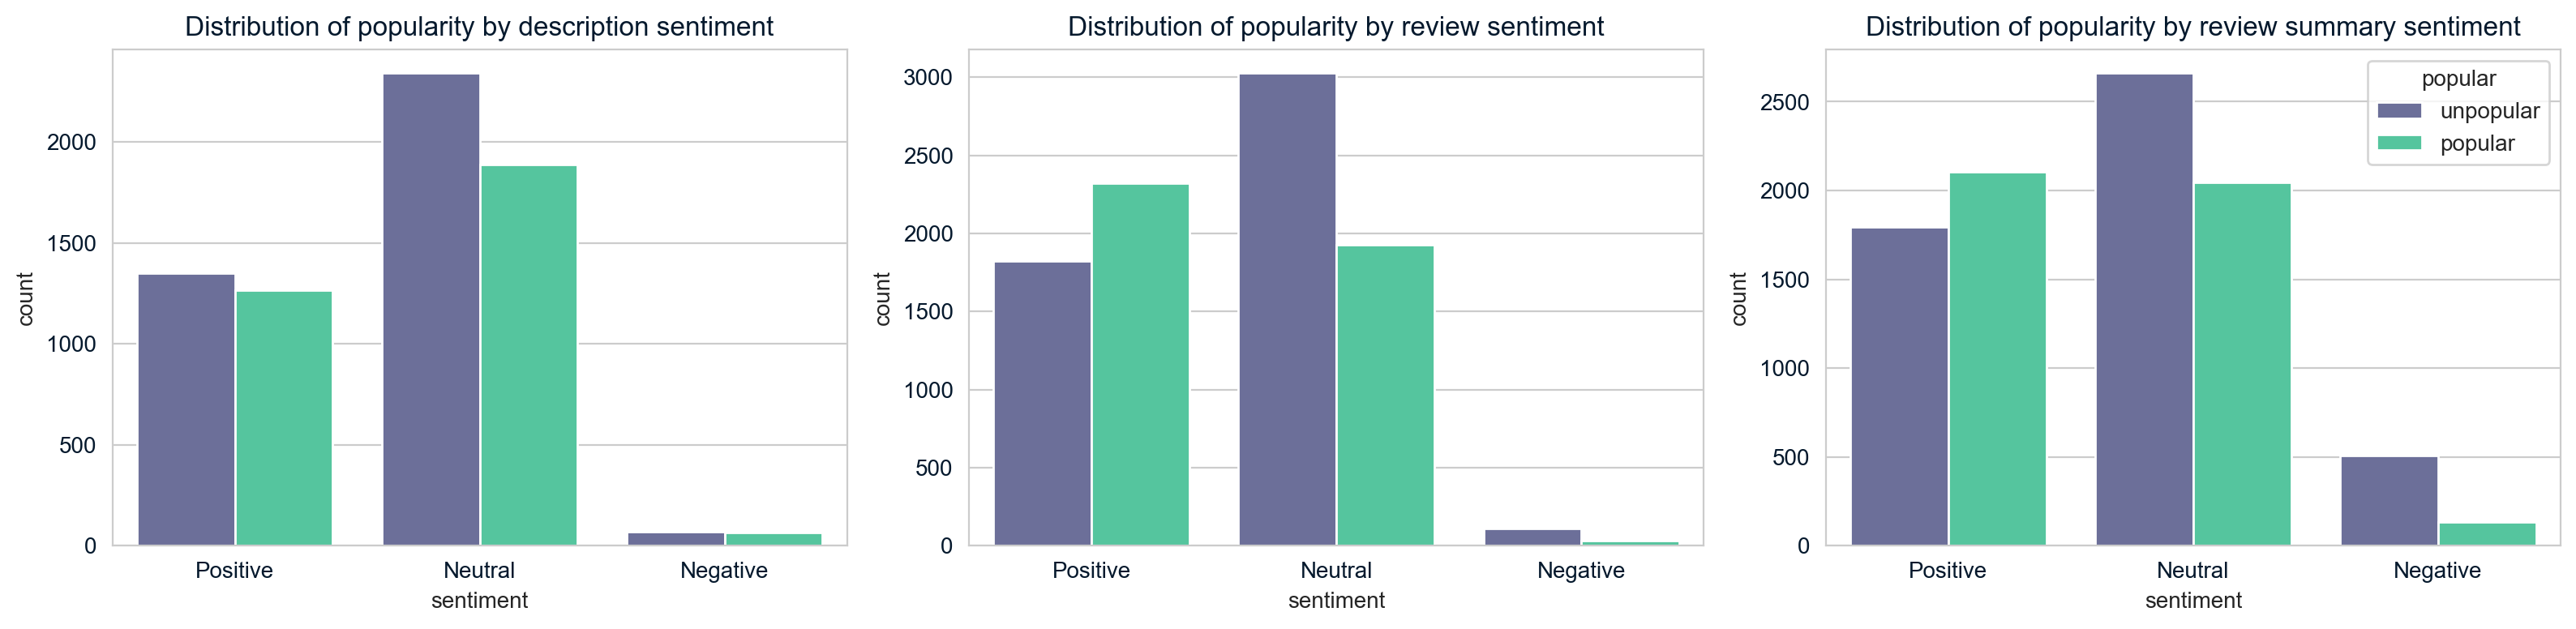

In [58]:
plt.figure(figsize = (16, 4))

plt.subplot(1, 3, 1)
plt.title("Distribution of popularity by description sentiment")
sns.barplot(data = desc_sent, x = 'sentiment', y = 'count', hue = 'popular', order = ['Positive', 'Neutral', 'Negative'])
plt.legend().remove()

plt.subplot(1, 3, 2)
sns.barplot(data = review_sent, x = 'sentiment', y = 'count', hue = 'popular', order = ['Positive', 'Neutral', 'Negative'])
plt.title("Distribution of popularity by review sentiment")
plt.legend().remove()

plt.subplot(1, 3, 3)
sns.barplot(data = review_summary_sent, x = 'sentiment', y = 'count', hue = 'popular', order = ['Positive', 'Neutral', 'Negative'])
plt.title("Distribution of popularity by review summary sentiment")
plt.tight_layout()

Across all charts, neutral sentiments about a book description are most prevalent, and they generally show a higher count of both popular and unpopular books, indicating that neutral sentiments are common across various book popularity levels. Positive sentiments tend to be associated with popular books, while negative sentiments are rare and slightly more linked with unpopular books. These trends suggest that while sentiment may influence popularity, neutral and positive sentiments are more broadly distributed among both popular and unpopular books.

# Finalize Dataset for Model Building

## Merge all data: unique books, reviews, and modified price

Now that all the columns have been cleaned in preparation for model training, I will produce two dataframes to benchmark my progress against my model performance so far. The first dataset I will produce is based on a similar granularity as the previous model's training set, that is, it is based on each unique book review item. I will also produce a dataset that has unique book titles for granularity to see how well our machine learning algorithm can parse the data for patterns.

In [59]:
review = review_df.drop(['title', 'authors', 'review_sentiment'], axis = 1)
price = price_df_final.drop(['title', 'authors', 'description', 'popular', 'book_title_length', 'genre', 'sub_genre'], axis = 1)

print(f"Pop DF has {pop_df.shape[0]} rows")
print(f"Reviews has {review.shape[0]} rows")
print(f"Price has {price.shape[0]} rows")

Pop DF has 6979 rows
Reviews has 12420 rows
Price has 6979 rows


In [60]:
tmp = pd.merge(pop_df, price, on = 'fk')
tmp = pd.merge(tmp, review, on = 'fk')
print(f"Total of {tmp.shape[0]} rows after merge completed.")
tmp.head(3)

Total of 12420 rows after merge completed.


,fk,title,authors,description,popular,book_title_length,genre,sub_genre,authors_list,author_total_book_count,total_popular_book_count,author_other_popular_book_count,total_authors,description_sentiment,desc_sentiment_type,price_block,reviews_helpful,total_reviews,reviews_not_helpful,pct_reviews_helpful,review_text,review_sentiment_type,review_summary,review_summary_sentiment,review_summary_sentiment_type
0,kent healykyle healycool stuff teach school cr...,"""Cool Stuff"" They Should Teach in School: Crui...","'Kent Healy', 'Kyle Healy'",offer advices young people topics attitude peo...,0,83,non-fiction,education,"[kent healy, kyle healy]",1,0,0,2,0.066667,Neutral,q3,1.0,1.0,0.0,1.0,buy basis review think book pretty good conten...,Positive,style substance,0.5,Positive
1,david m. jordanhappiness companion life genera...,"""Happiness Is Not My Companion"": The Life of G...",'David M. Jordan',valorous trouble career civil war general best...,1,65,non-fiction,history,[david m. jordan],1,1,0,1,0.083068,Neutral,q7,2.0,2.0,0.0,1.0,solid bio general warren like george picket kn...,Neutral,solid bio warren controversy five fork,0.0,Neutral
2,jim mclaurindavid pooletom gillispiejunior say...,"""Then Junior Said to Jeff. . ."": The Best NASC...","'Jim McLaurin', 'David Poole', 'Tom Gillispie'",collection behindthescenes happen history belo...,1,66,special topics,sports & recreation,"[jim mclaurin, david poole, tom gillispie]",1,1,0,3,0.216667,Positive,q6,0.0,0.0,0.0,0.0,like nascar stories facts trivia stats book au...,Negative,great stories,0.8,Positive


The above is our newly-cleaned and combined dataset, the majority of whose features will be used for the latter-half of our model building endeavor.

## Dataset 1: Cleaned Dataset Using Reviews

In [61]:
# drop least useful columns
unique_reviews_df = tmp.drop(['fk','authors_list', 'description_sentiment', 'reviews_helpful', 'reviews_not_helpful'], axis = 1)
print(unique_reviews_df.shape)
unique_reviews_df.head(3)

(12420, 20)


,title,authors,description,popular,book_title_length,genre,sub_genre,author_total_book_count,total_popular_book_count,author_other_popular_book_count,total_authors,desc_sentiment_type,price_block,total_reviews,pct_reviews_helpful,review_text,review_sentiment_type,review_summary,review_summary_sentiment,review_summary_sentiment_type
0,"""Cool Stuff"" They Should Teach in School: Crui...","'Kent Healy', 'Kyle Healy'",offer advices young people topics attitude peo...,0,83,non-fiction,education,1,0,0,2,Neutral,q3,1.0,1.0,buy basis review think book pretty good conten...,Positive,style substance,0.5,Positive
1,"""Happiness Is Not My Companion"": The Life of G...",'David M. Jordan',valorous trouble career civil war general best...,1,65,non-fiction,history,1,1,0,1,Neutral,q7,2.0,1.0,solid bio general warren like george picket kn...,Neutral,solid bio warren controversy five fork,0.0,Neutral
2,"""Then Junior Said to Jeff. . ."": The Best NASC...","'Jim McLaurin', 'David Poole', 'Tom Gillispie'",collection behindthescenes happen history belo...,1,66,special topics,sports & recreation,1,1,0,3,Positive,q6,0.0,0.0,like nascar stories facts trivia stats book au...,Negative,great stories,0.8,Positive


## Dataset 2: Cleaned Dataset of Unique Book Titles

In [62]:
tmp = review_df.groupby(['fk']).agg({'reviews_helpful': 'sum', 'total_reviews': 'sum', 'review_sentiment': 'median'}).reset_index()
tmp['review_sentiment_type'] = tmp['review_sentiment'].apply(tc.get_sentiment_category)
tmp['pct_reviews_helpful'] = tmp['reviews_helpful'] / tmp['total_reviews']
tmp['pct_reviews_helpful'] = tmp['pct_reviews_helpful'].fillna(0)

tmp = pd.merge(pop_df, tmp, on = ['fk'])
tmp = tmp.drop(['authors_list','description_sentiment','review_sentiment'], axis = 1)
tmp = pd.merge(tmp, price, on = 'fk')

unique_book_df = tmp.copy()
unique_book_df.head(3)

,fk,title,authors,description,popular,book_title_length,genre,sub_genre,author_total_book_count,total_popular_book_count,author_other_popular_book_count,total_authors,desc_sentiment_type,reviews_helpful,total_reviews,review_sentiment_type,pct_reviews_helpful,price_block
0,kent healykyle healycool stuff teach school cr...,"""Cool Stuff"" They Should Teach in School: Crui...","'Kent Healy', 'Kyle Healy'",offer advices young people topics attitude peo...,0,83,non-fiction,education,1,0,0,2,Neutral,1.0,1.0,Positive,1.0,q3
1,david m. jordanhappiness companion life genera...,"""Happiness Is Not My Companion"": The Life of G...",'David M. Jordan',valorous trouble career civil war general best...,1,65,non-fiction,history,1,1,0,1,Neutral,2.0,2.0,Neutral,1.0,q7
2,jim mclaurindavid pooletom gillispiejunior say...,"""Then Junior Said to Jeff. . ."": The Best NASC...","'Jim McLaurin', 'David Poole', 'Tom Gillispie'",collection behindthescenes happen history belo...,1,66,special topics,sports & recreation,1,1,0,3,Positive,0.0,0.0,Negative,0.0,q6


# Model Training & Evaluation

## Pipeline Model 4: Training on unique book titles only (no text data)

Continuing where we left off in our preliminary model building stage, we first attempt to build a model based only on non-textual data. I show the feature inputs below. Numerical features are all standardized and all categorical features are one-hot encoded. The accuracy score from this analysis provides a benchmark for how much text review and book description information can improve our model thereafter. 

In [63]:
df = unique_book_df.copy()
drop_cols = ['fk','title', 'authors', 'description', 'reviews_helpful', 'total_popular_book_count', 'author_total_book_count']
df = df.drop(drop_cols, axis = 1)
print(df.shape)
df.head(3)

(6979, 11)


,popular,book_title_length,genre,sub_genre,author_other_popular_book_count,total_authors,desc_sentiment_type,total_reviews,review_sentiment_type,pct_reviews_helpful,price_block
0,0,83,non-fiction,education,0,2,Neutral,1.0,Positive,1.0,q3
1,1,65,non-fiction,history,0,1,Neutral,2.0,Neutral,1.0,q7
2,1,66,special topics,sports & recreation,0,3,Positive,0.0,Negative,0.0,q6


In [64]:
num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))    
])

preproc = ColumnTransformer([
    ('numeric_columns', num_transformer, ['book_title_length','author_other_popular_book_count','total_authors','total_reviews','pct_reviews_helpful']),
    ('categories_transformer', cat_transformer, ['genre', 'sub_genre','desc_sentiment_type', 'review_sentiment_type', 'price_block']),
], remainder='drop')

pipeline = Pipeline([
    ('preprocessing', preproc),
    ('classifier', project_classifier)
])

pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_columns',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['book_title_length',
                                                   'author_other_popular_book_count',
                                                   'total_authors',
                                                   'total_reviews',
                                                   'pct_reviews_helpful']),
                                                 ('categories_transformer',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['genre', 'sub_genr...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [65]:
model_name = 'pipeline_model_4'
model_description = 'a model that received maximal data cleaning, only using unique books as the training model dataset granularity, all text columns excluded.'

X = df.drop('popular', axis = 1)
y = df['popular']

print("Splitting into training and test set")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)

print("Processing and fitting model")
pipeline.fit(X_train, y_train)

print("Running cross validation")
result = cross_validate(pipeline, X_test, y_test, cv = 5, n_jobs = -1, scoring = 'accuracy')

accuracy = round(result['test_score'].mean(), 3)
print(f"Cross-validated accuracy score is {accuracy}")
print(f"Achieved goal of 70% accuracy? {accuracy > 0.70}")


result_details = {
    'model_name': model_name,
    'model_desc': model_description,
    'training_observations': X_train.shape[0],
    'accuracy_score': accuracy,
    'dataset_cleaning': 'thoroughly cleaned'
}

results.append(result_details)

if accuracy > 0.70:
    result_details['model'] = pipeline
    good_models.append(result_details)

Splitting into training and test set
Processing and fitting model
Running cross validation
Cross-validated accuracy score is 0.589
Achieved goal of 70% accuracy? False


### Result Assessments

Using the cleaned dataset and none of the text features has yielded our worst performing model so far, with a cross-validated accuracy score below 60%. The unique features of a book alone are insufficient for building a model that achieves our target performance threshold. In fact, a model trained only on the unique book titles performs almost as badly as a model that merely predicts "Unpopular" for every book title fed into it. The machine learning algorithm is struggling to find the pattern in the data using book title information alone.

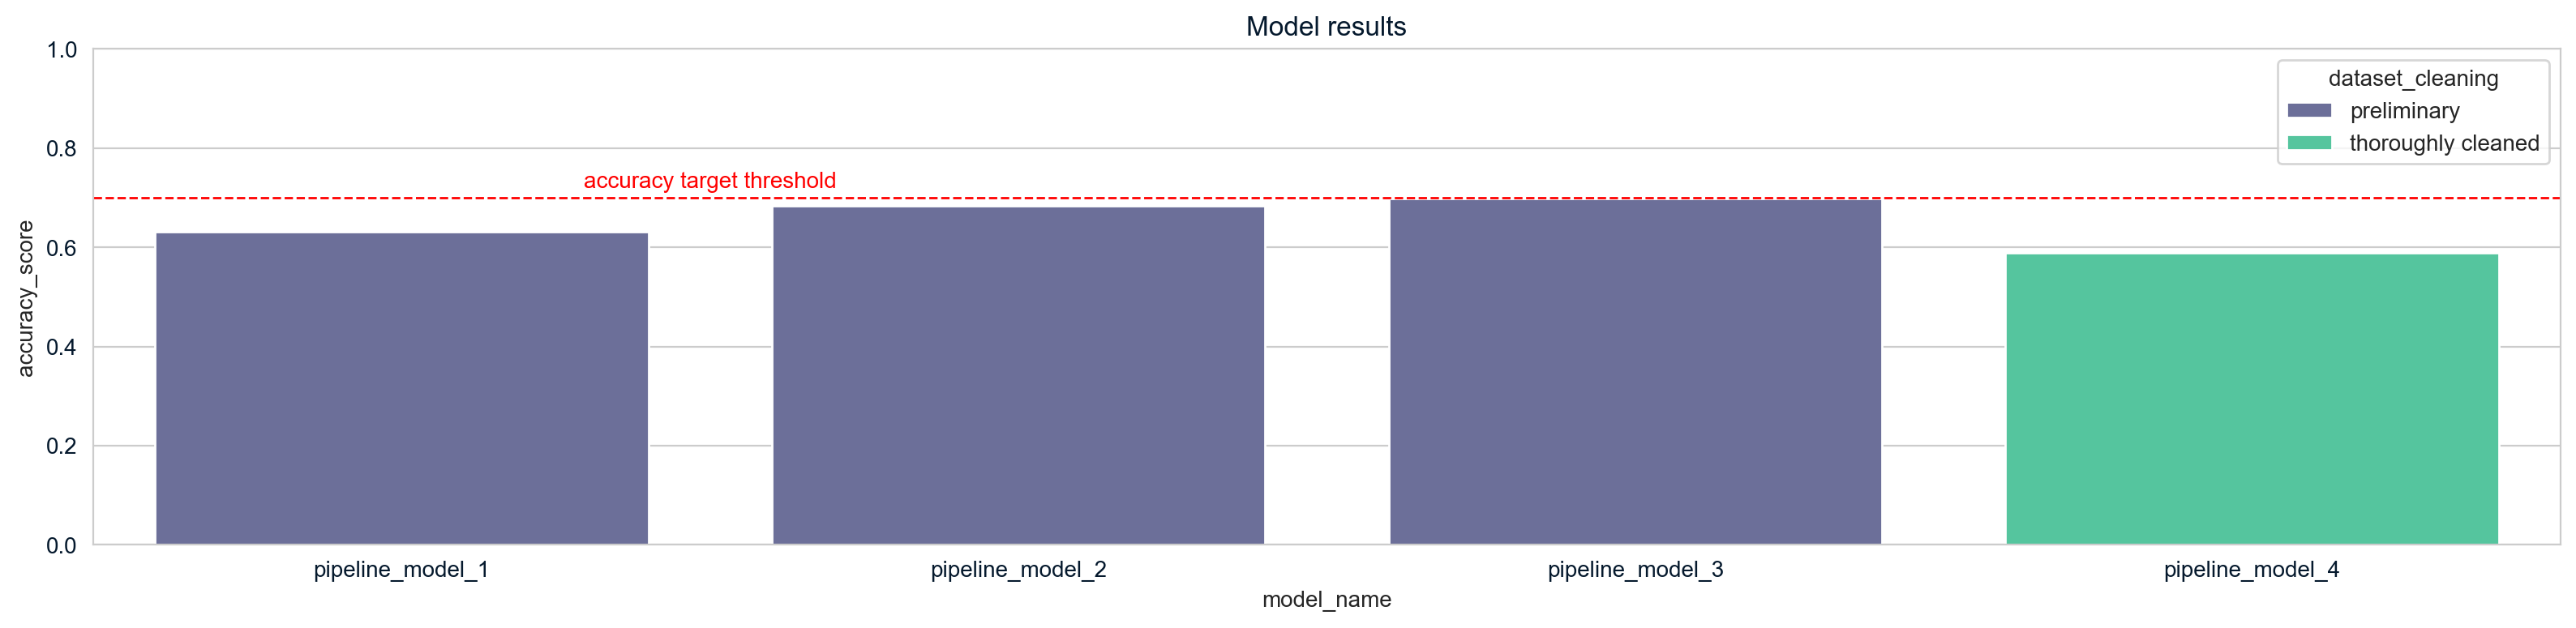

In [66]:
plt.figure(figsize = (16, 4))

tmp = pd.DataFrame(results)
ax = sns.barplot(data = tmp, x = 'model_name', y = 'accuracy_score', hue = 'dataset_cleaning')
ax.axhline(0.70, color = 'red', linestyle='--', linewidth = 1)
annotation = "accuracy target threshold"
ax.text(x = 0.5, y = 0.72, s = annotation, color = 'red', ha = 'center')

plt.title("Model results")
plt.ylim([0, 1])
plt.tight_layout()

## Pipeline Model 5: Reintroducing CountVectorizer

For the fifth model, I will reintroduce all of the text data column information - review text, review summary, and description. Moreover, I apply the CountVectorizer sentiment summary technique employed during the first and third models to quantify sentiment.

All numeric information is standardized and the book categories, price blocks, and sentiment categories are one-hot encoded. The text columns are all vectorized using the CountVectorizer. Each column is evaluated based on the count of 'positive' or 'negative' sentiment words (sourced for nltk.opinion_lexicon). The word count for the respective text column is then standardized.

In [67]:
drop_cols = ['title', 'authors', 'total_popular_book_count', 'author_total_book_count', 'review_summary_sentiment']
df = unique_reviews_df.drop(drop_cols, axis = 1)
df.head(3)

,description,popular,book_title_length,genre,sub_genre,author_other_popular_book_count,total_authors,desc_sentiment_type,price_block,total_reviews,pct_reviews_helpful,review_text,review_sentiment_type,review_summary,review_summary_sentiment_type
0,offer advices young people topics attitude peo...,0,83,non-fiction,education,0,2,Neutral,q3,1.0,1.0,buy basis review think book pretty good conten...,Positive,style substance,Positive
1,valorous trouble career civil war general best...,1,65,non-fiction,history,0,1,Neutral,q7,2.0,1.0,solid bio general warren like george picket kn...,Neutral,solid bio warren controversy five fork,Neutral
2,collection behindthescenes happen history belo...,1,66,special topics,sports & recreation,0,3,Positive,q6,0.0,0.0,like nascar stories facts trivia stats book au...,Negative,great stories,Positive


In [68]:
num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))    
])

text_transformer = Pipeline([
    ('vectorize', FeatureUnion([
        ('positive', ct.VectorizeCount(sentiment = 'positive')),
        ('negative', ct.VectorizeCount(sentiment = 'negative'))
    ])),
    ('scaler', StandardScaler())
])

preproc = ColumnTransformer([
    ('numeric_columns', num_transformer, ['author_other_popular_book_count','total_authors','total_reviews','pct_reviews_helpful']),
    ('categories_transformer', cat_transformer, ['genre', 'sub_genre', 'price_block', 'desc_sentiment_type', 'review_sentiment_type', 'review_summary_sentiment_type']),
    ('text_transformer', text_transformer, ['review_text', 'review_summary', 'description']),        

], remainder='drop')

pipeline = Pipeline([
    ('preprocessing', preproc),
    ('classifier', project_classifier)
])

pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_columns',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['author_other_popular_book_count',
                                                   'total_authors',
                                                   'total_reviews',
                                                   'pct_reviews_helpful']),
                                                 ('categories_transformer',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['genre', 'sub_genre',
                                                   'price_block',
                                                   'de...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [69]:
model_name = 'pipeline_model_5'
model_description = 'a model that received maximal data cleaning, only using unique books as the training model dataset granularity, all text columns included now.'

X = df.drop('popular', axis = 1)
y = df['popular']

print("Splitting into training and test set")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)

print("Processing and fitting model")
pipeline.fit(X_train, y_train)

print("Running cross validation")
result = cross_validate(pipeline, X_test, y_test, cv = 5, n_jobs = -1, scoring = 'accuracy')

accuracy = round(result['test_score'].mean(), 3)
print(f"Cross-validated accuracy score is {accuracy}")
print(f"Achieved goal of 70% accuracy? {accuracy > 0.70}")

result_details = {
    'model_name': model_name,
    'model_desc': model_description,
    'training_observations': X_train.shape[0],
    'accuracy_score': accuracy,
    'dataset_cleaning': 'thoroughly cleaned'
}

results.append(result_details)

if accuracy > 0.70:
    result_details['model'] = pipeline
    good_models.append(result_details)

Splitting into training and test set
Processing and fitting model
Running cross validation
Cross-validated accuracy score is 0.667
Achieved goal of 70% accuracy? False


### Results Assessment

Reintroducing the text information to our training set has substantially improved our model performance compared to our previous model that was trained on unique book titles only. We remain below our threshold target, but have some potential to meet it if our model performs as well as pipeline_model_2.

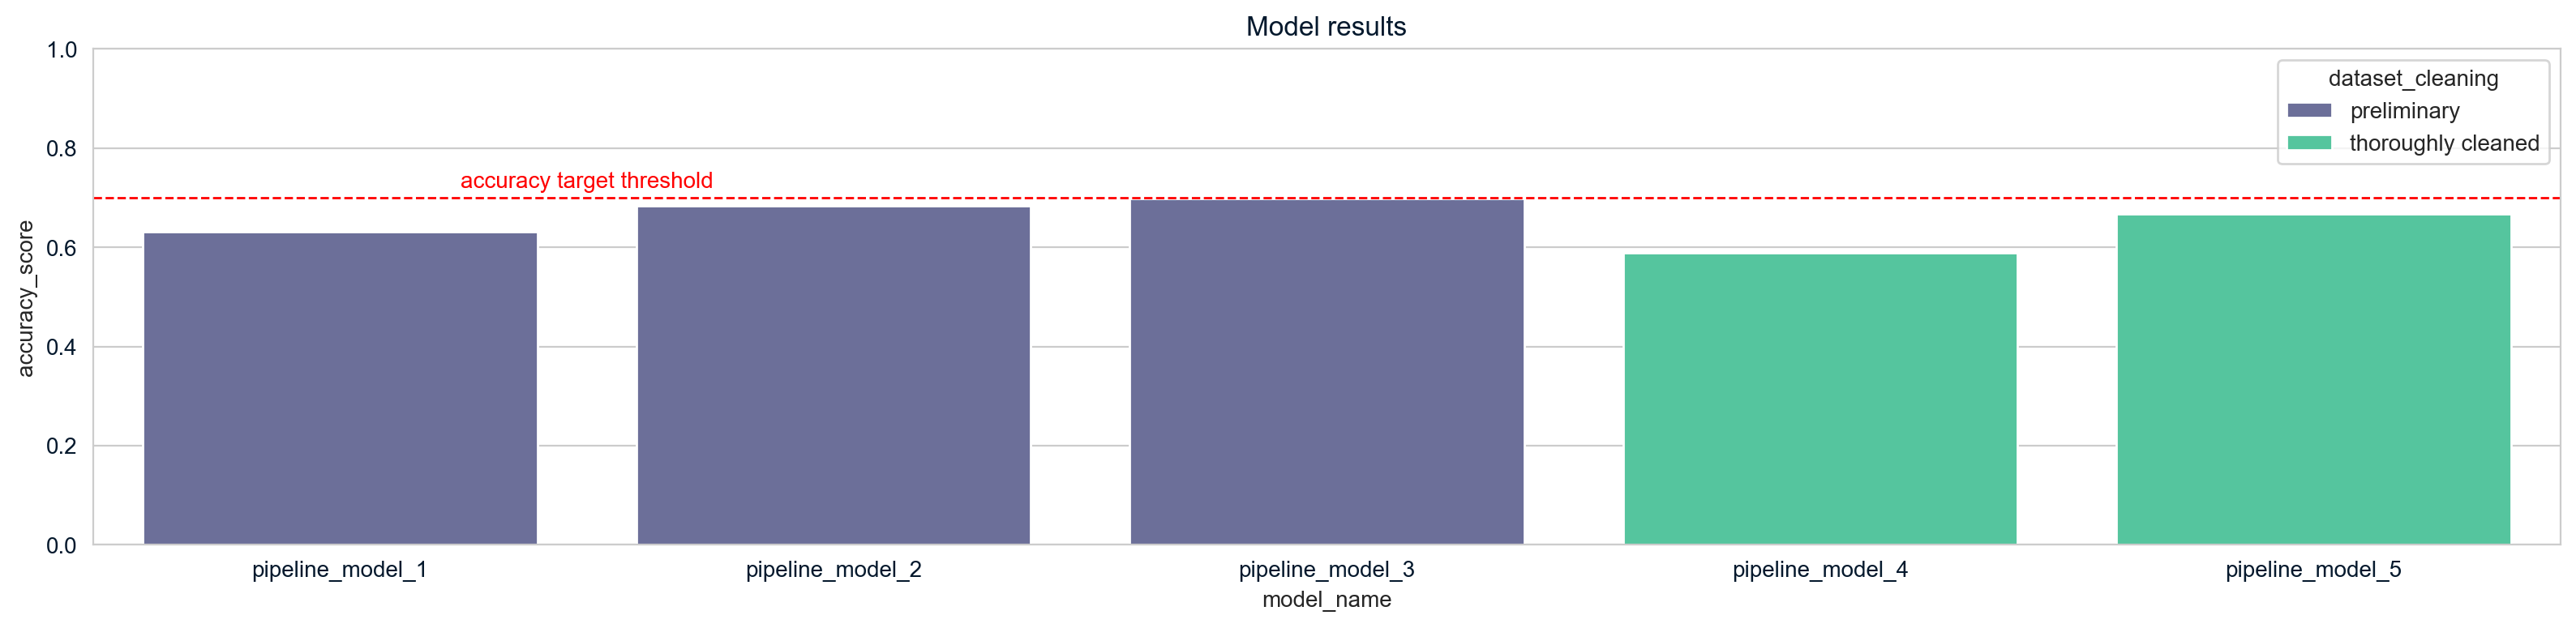

In [70]:
plt.figure(figsize = (16, 4))

tmp = pd.DataFrame(results)
ax = sns.barplot(data = tmp, x = 'model_name', y = 'accuracy_score', hue = 'dataset_cleaning')
ax.axhline(0.70, color = 'red', linestyle='--', linewidth = 1)
annotation = "accuracy target threshold"
ax.text(x = 0.5, y = 0.72, s = annotation, color = 'red', ha = 'center')

plt.title("Model results")
plt.ylim([0, 1])
plt.tight_layout()

## Pipeline Model 6: Reintroducing TFIDF Vectorizer

The sixth model also absorbs nearly all the main dataset features. All numeric features are standardized. The categories, price block, and sentiment categories are all one-hot encoded.

Unlike the previous model, the three text columns are all vectorized using the TfIDF Vectorizer alone. For the review text and description, a limit of 300 features is enforced on the number of features created by each vectorizer in order to prevent overfitting and the curse of dimensionality problem. A limit of 200 features is applied to the review summary Vectorizer. I cleaned the text columns outside of the pipeline.

In [71]:
drop_cols = ['title', 'authors', 'total_popular_book_count', 'author_total_book_count', 'review_summary_sentiment']
df = unique_reviews_df.drop(drop_cols, axis = 1)
df.head(3)

,description,popular,book_title_length,genre,sub_genre,author_other_popular_book_count,total_authors,desc_sentiment_type,price_block,total_reviews,pct_reviews_helpful,review_text,review_sentiment_type,review_summary,review_summary_sentiment_type
0,offer advices young people topics attitude peo...,0,83,non-fiction,education,0,2,Neutral,q3,1.0,1.0,buy basis review think book pretty good conten...,Positive,style substance,Positive
1,valorous trouble career civil war general best...,1,65,non-fiction,history,0,1,Neutral,q7,2.0,1.0,solid bio general warren like george picket kn...,Neutral,solid bio warren controversy five fork,Neutral
2,collection behindthescenes happen history belo...,1,66,special topics,sports & recreation,0,3,Positive,q6,0.0,0.0,like nascar stories facts trivia stats book au...,Negative,great stories,Positive


In [72]:
num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))    
])

preproc = ColumnTransformer([
    ('numeric_columns', num_transformer, ['author_other_popular_book_count','total_authors','total_reviews','pct_reviews_helpful']),
    ('categories_transformer', cat_transformer, ['genre', 'sub_genre','desc_sentiment_type', 'review_sentiment_type', 'review_summary_sentiment_type', 'price_block']),
    ('tfidf_reviews', TfidfVectorizer(max_features=300, token_pattern=token_pattern), 'review_text'),
    ('tfidf_summary', TfidfVectorizer(max_features=200, token_pattern=token_pattern), 'review_summary'),
    ('tfidf_description', TfidfVectorizer(max_features=300, token_pattern=token_pattern), 'description'),

], remainder='drop')

pipeline = Pipeline([
    ('preprocessing', preproc),
    ('classifier', project_classifier)
])

pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_columns',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['author_other_popular_book_count',
                                                   'total_authors',
                                                   'total_reviews',
                                                   'pct_reviews_helpful']),
                                                 ('categories_transformer',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['genre', 'sub_genre',
                                                   'desc_sentiment_t...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [73]:
model_name = 'pipeline_model_6'
model_description = 'a model that received maximal data cleaning, only using unique books as the training model dataset granularity, all text columns included now.'

X = df.drop('popular', axis = 1)
y = df['popular']

print("Splitting into training and test set")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)

print("Processing and fitting model")
pipeline.fit(X_train, y_train)

print("Running cross validation")
result = cross_validate(pipeline, X_test, y_test, cv = 5, n_jobs = -1, scoring = 'accuracy')

accuracy = round(result['test_score'].mean(), 3)
print(f"Cross-validated accuracy score is {accuracy}")
print(f"Achieved goal of 70% accuracy? {accuracy > 0.70}")

result_details = {
    'model_name': model_name,
    'model_desc': model_description,
    'training_observations': X_train.shape[0],
    'accuracy_score': accuracy,
    'dataset_cleaning': 'thoroughly cleaned'
}

results.append(result_details)

if accuracy > 0.70:
    result_details['model'] = pipeline
    good_models.append(result_details)

Splitting into training and test set
Processing and fitting model
Running cross validation
Cross-validated accuracy score is 0.71
Achieved goal of 70% accuracy? True


### Results Assessment

We have finally eclipsed 70% test set accuracy! Our model using the TFIDF Vectorizer on our textual data has met our objective. This was achieved on a balanced training and test set. We could conclude here, but first let's employ our last model that combines the output of our CountVectorizer as well.

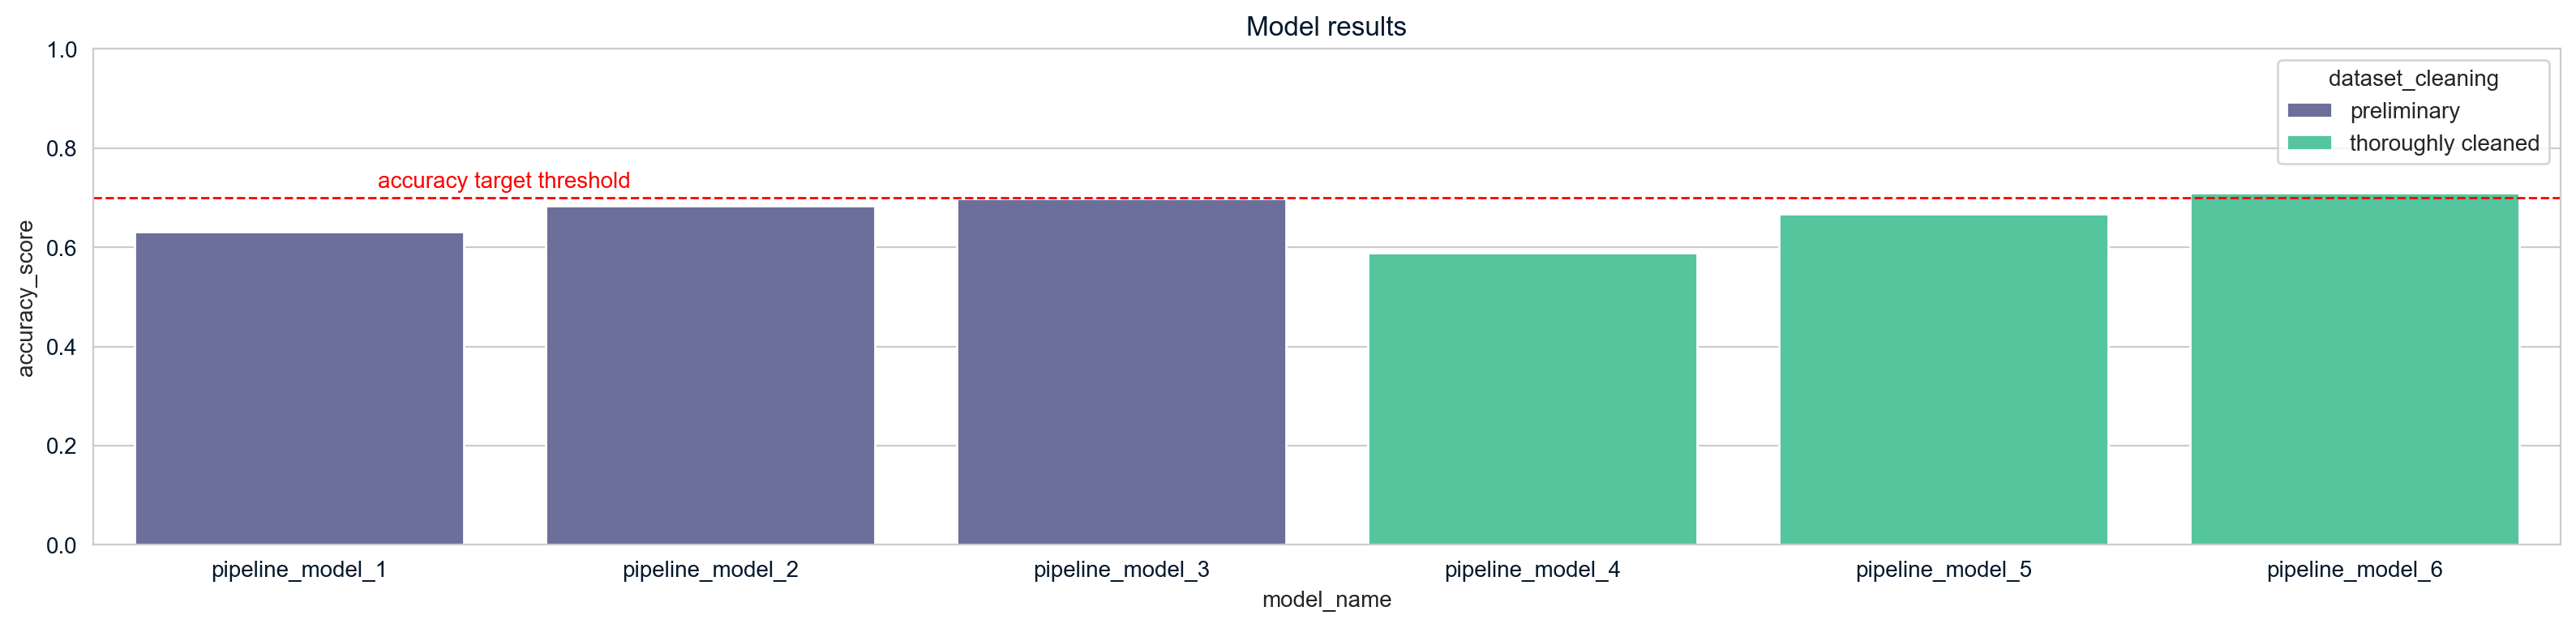

In [74]:
plt.figure(figsize = (16, 4))

tmp = pd.DataFrame(results)
ax = sns.barplot(data = tmp, x = 'model_name', y = 'accuracy_score', hue = 'dataset_cleaning')
ax.axhline(0.70, color = 'red', linestyle='--', linewidth = 1)
annotation = "accuracy target threshold"
ax.text(x = 0.5, y = 0.72, s = annotation, color = 'red', ha = 'center')

plt.title("Model results")
plt.ylim([0, 1])
plt.tight_layout()

## Pipeline Model 7: Combining CountVectorizer and TFIDF Vectorizer

The final model also absorbs nearly all the main dataset features. All numeric features are standardized. The categories, price block, and sentiment categories are all one-hot encoded.

The three text columns are all vectorized using the TfIDF Vectorizer and the CountVectorizer for sentiment. 

Regarding the TFIDF Vectorizer, as before, a limit of 300 features is enforced on the number of features created by each vectorizer for review text and description information. For review summary, a feature cap of 200 is applied. For the CountVectorizer, each column is evaluated based on the count of 'positive' or 'negative' sentiment words (sourced for nltk.opinion_lexicon). The word count for the respective text column is then standardized. The text columns were cleaned outside of the pipeline.

In [75]:
drop_cols = ['title', 'authors', 'total_popular_book_count', 'author_total_book_count', 'review_summary_sentiment']
df = unique_reviews_df.drop(drop_cols, axis = 1)
df.head(3)

,description,popular,book_title_length,genre,sub_genre,author_other_popular_book_count,total_authors,desc_sentiment_type,price_block,total_reviews,pct_reviews_helpful,review_text,review_sentiment_type,review_summary,review_summary_sentiment_type
0,offer advices young people topics attitude peo...,0,83,non-fiction,education,0,2,Neutral,q3,1.0,1.0,buy basis review think book pretty good conten...,Positive,style substance,Positive
1,valorous trouble career civil war general best...,1,65,non-fiction,history,0,1,Neutral,q7,2.0,1.0,solid bio general warren like george picket kn...,Neutral,solid bio warren controversy five fork,Neutral
2,collection behindthescenes happen history belo...,1,66,special topics,sports & recreation,0,3,Positive,q6,0.0,0.0,like nascar stories facts trivia stats book au...,Negative,great stories,Positive


In [76]:
tmp = df[['description','review_text','review_summary']]

text_transformer = Pipeline([
    ('vectorize', FeatureUnion([
        ('positive', ct.VectorizeCount(sentiment = 'positive')),
        ('negative', ct.VectorizeCount(sentiment = 'negative'))
    ]))
])

preproc = ColumnTransformer([
    ('text_transformer', text_transformer, ['review_text', 'review_summary', 'description'])
], remainder = 'drop')

cols = ['pos_count_review_text','pos_count_review_summary','pos_count_description','neg_count_review_text','neg_count_review_summary','neg_count_description']
tmp = pd.DataFrame(preproc.fit_transform(tmp), columns = cols)
df1 = pd.concat([df, tmp], axis = 1)

In [77]:
num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))    
])

preproc = ColumnTransformer([
    ('numeric_columns', num_transformer, ['author_other_popular_book_count','total_authors','total_reviews','pct_reviews_helpful'] + cols),
    ('categories_transformer', cat_transformer, ['genre', 'sub_genre','desc_sentiment_type', 'review_sentiment_type', 'review_summary_sentiment_type', 'price_block']),
    ('tfidf_reviews', TfidfVectorizer(max_features=300, token_pattern=token_pattern), 'review_text'),
    ('tfidf_summary', TfidfVectorizer(max_features=200, token_pattern=token_pattern), 'review_summary'),
    ('tfidf_description', TfidfVectorizer(max_features=300, token_pattern=token_pattern), 'description'),

], remainder='drop')

pipeline = Pipeline([
    ('preprocessing', preproc),
    ('classifier', project_classifier)
])

pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_columns',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['author_other_popular_book_count',
                                                   'total_authors',
                                                   'total_reviews',
                                                   'pct_reviews_helpful',
                                                   'pos_count_review_text',
                                                   'pos_count_review_summary',
                                                   'pos_count_description',
                                                   'neg_count_review_text',
                                                   'neg_count_review_summary',
                                                   'neg_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [78]:
model_name = 'pipeline_model_7'
model_description = 'a model that received maximal data cleaning, only using unique books as the training model dataset granularity, all text columns included now. Sentiment count vectorizer included.'

X = df1.drop('popular', axis = 1)
y = df1['popular']

print("Splitting into training and test set")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)

print("Processing and fitting model")
pipeline.fit(X_train, y_train)

print("Running cross validation")
result = cross_validate(pipeline, X_test, y_test, cv = 5, n_jobs = -1, scoring = 'accuracy')

accuracy = round(result['test_score'].mean(), 3)
print(f"Cross-validated accuracy score is {accuracy}")
print(f"Achieved goal of 70% accuracy? {accuracy > 0.70}")

result_details = {
    'model_name': model_name,
    'model_desc': model_description,
    'training_observations': X_train.shape[0],
    'accuracy_score': accuracy,
    'dataset_cleaning': 'thoroughly cleaned'
}

results.append(result_details)

if accuracy > 0.70:
    result_details['model'] = pipeline
    good_models.append(result_details)

Splitting into training and test set
Processing and fitting model
Running cross validation
Cross-validated accuracy score is 0.715
Achieved goal of 70% accuracy? True


### Results Assessment

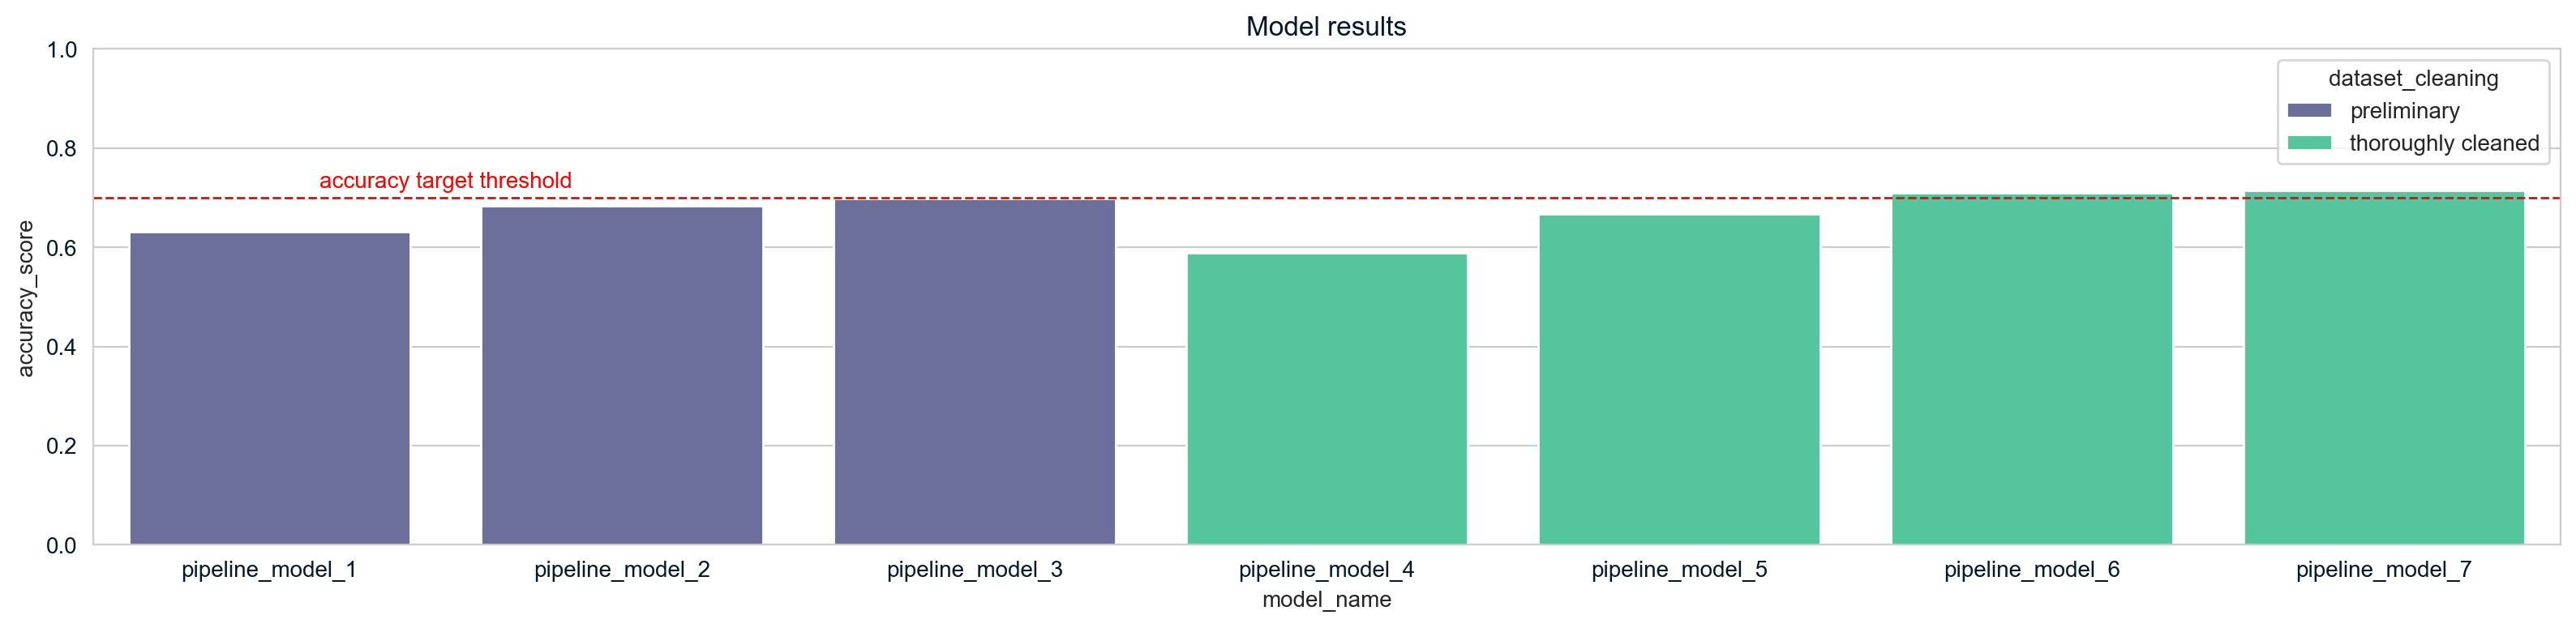

In [79]:
plt.figure(figsize = (16, 4))

tmp = pd.DataFrame(results)
ax = sns.barplot(data = tmp, x = 'model_name', y = 'accuracy_score', hue = 'dataset_cleaning')
ax.axhline(0.70, color = 'red', linestyle='--', linewidth = 1)
annotation = "accuracy target threshold"
ax.text(x = 0.5, y = 0.72, s = annotation, color = 'red', ha = 'center')

plt.title("Model results")
plt.ylim([0, 1])
plt.tight_layout()

# Model Deployment

Let's preview our model if it were deployed in our company. A sample instance is provided in its original encoding and the model output is compared to the actual class instance.

In [80]:
print(f"There are {len(good_models)} models that met our threshold. Now, let's deploy the most recent instance (pipeline_model_7)")

model = good_models[-1]['model']

There are 2 models that met our threshold. Now, let's deploy the most recent instance.


## Example Case

In [81]:
# produce array of predicted outcomes
y_pred = model.predict(X_test)

# example case index
index = 201

print("****************************")
print("        BOOK DETAILS      ")
print("****************************")

for i, row in X_test.iloc[index:index+1].iterrows():
    for col in X_test.columns:
        print(f"{col}: {row[col]}")

model_result = 'Unpopular' if y_pred[index] == 0 else 'Popular'
actual_result = 'Unpopular' if y_test.iloc[index] == 0 else 'Popular'

print("")
print("****************************")
print("      MODEL PREDICTION      ")
print("****************************")

print(f"Model predicts: {model_result}")
print(f"Actual classification: {actual_result}")
print(f"Is this accurate? {model_result == actual_result}")

****************************
        BOOK DETAILS      
****************************
description: extraordinary work reportage epic political story time newsweek—from bob woodward carl bernstein pulitzer prizewinning coauthors president men final days new york time bestselling classic behindthescenes account richard nixon dramatic last months president moment moment bernstein woodward portray taut postwatergate white house nixon family staff many members congress strain desperately prevent inevitable resignation brilliant book reveal ordeal nixon fall office—one gravest crises presidential history
book_title_length: 14
genre: non-fiction
sub_genre: history
author_other_popular_book_count: 0
total_authors: 2
desc_sentiment_type: Neutral
price_block: q4
total_reviews: 20.0
pct_reviews_helpful: 0.55
review_text: book write well feel right people room air force one wherever barbara olson acutely place clintons place first four years bill hillarys term president unite state yes thats right 

# Which Features Make a Book Popular?

The benefit of a decision-tree classifier such as XGBoost is that it offers insight into the feature importances in predicting the target class. The importance score helps in understanding which features have the most influence on the model's decisions.

For our final model, the feature **author_other_popular_book_count** stands out as the most important. This makes some intuitive sense because of the strong association between book popularity classification and authors who have other popular books classified as such in the dataset. In short, authors with a track record of popular books are more likely to produce another successful book.

As for sentiment features, **review_sentiment_type_Positive** (0.014) and **review_summary_sentiment_type_Negative** (0.008), show that sentiment analysis plays a role in predicting book popularity, though their importance is relatively lower. Positive reviews seem more influential than negative summaries in this model.

Several features are based on specific words in book descriptions, reviews, and summaries (e.g., **description_has_word_public**, **reviews_has_word_plot**, **summary_has_word_good**). The presence of certain words appears to provide predictive value, perhaps indicating common themes or elements that appeal to readers.

The feature **sub_genre_fiction** (0.008) indicates that the genre or sub-genre of a book is a factor, though not a dominant one. This could reflect varying popularity levels across different genres.

A mix of sentiment, content-specific words, and genre-related features all contribute to predicting book popularity. The lower importance scores of many features suggest that book popularity is influenced by a wide range of factors, each contributing to a small extent.

In [82]:
preprocessor = pipeline.named_steps['preprocessing']
feature_names = helper.get_feature_names_from_column_transformer(preprocessor)
feature_names = feature_names[:-1]

classifier = pipeline.named_steps['classifier']
feature_importances = classifier.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by = 'importance', ascending = False).reset_index(drop = True)

print("The most important features for determining book popularity")
print("feature (importance score)")
print("")
for i, row in importance_df.iterrows():
    importance_val = round(row['importance'], 4)
    if row['feature'][:5] == 'tfidf':
        feature_name = row['feature'].replace("__","_has_word_")
        feature_name = feature_name.replace("tfidf_","")
        print(f"{i+1}) {feature_name} ({importance_val})")
    else:
        feature_name = row['feature'].split("__")[-1]
        print(f"{i+1}) {feature_name} ({importance_val})")

    if i == 19:
        break

The most important features for determining book popularity
feature (importance score)

1) author_other_popular_book_count (0.0323)
2) review_sentiment_type_Positive (0.0142)
3) description_has_word_public (0.0119)
4) sub_genre_fiction (0.0082)
5) reviews_has_word_plot (0.0081)
6) review_summary_sentiment_type_Negative (0.008)
7) summary_has_word_good (0.0067)
8) description_has_word_child (0.0063)
9) reviews_has_word_highly (0.0063)
10) description_has_word_sell (0.006)
11) description_has_word_night (0.0055)
12) description_has_word_york (0.0054)
13) description_has_word_three (0.0052)
14) summary_has_word_best (0.0052)
15) description_has_word_men (0.005)
16) neg_count_review_summary (0.0049)
17) reviews_has_word_seem (0.0045)
18) reviews_has_word_sense (0.0045)
19) description_has_word_form (0.0043)
20) description_has_word_science (0.0043)


# Conclusion

Thanks for reading to the end! Wish you well on your machine learning journey!